# **Libraries**

In [1]:
#Library

#!pip install plotly --user
from utils import check_and_install

# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "xgboost",
    "lightgbm",
    "tqdm",
    "ipywidgets",
    "pandarallel",
    "plotly",
    "unidecode",
    'ipympl',
    "jupyterlab",
    "ipywidgets"

]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)


import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np
import warnings
import plotly.graph_objects as go
import ipywidgets as widgets

import re
from unidecode import unidecode

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression


from scipy  import stats



from pandarallel import pandarallel

# Our imports
from data_pred_code.utils import (
    create_prediction_visualizations,
    create_segment_analysis,
    errors_visualization,
    preprocess_helper_imputer,
    preprocess_helper_scaler
)

from data_pred_code.densities_based import predict_feature_density, print_density_info
from data_pred_code.regressors_based import compare_regressors
from data_pred_code.KNNImputer_based import predict_feature_knnimp
from IPython.display import display



pandarallel.initialize(progress_bar=True)
widgets.Widget.widgets = {}  # Clear widget state



scikit-learn not found, installing...
scikit-learn has been installed
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Dataset import on pandas Data framedict_keys([2, 20, 72, 74, 75, 76, 77])
DatasetCyclists = pd.read_csv("dataset/cyclists_updated.csv")
DatasetRace = pd.read_csv("dataset/races_updated.csv")

# Drop redundant columns
# _url from DatasetCyclist this information is in DatasetRace under the column 'cyclist'
# name from DatasetRace this information is in DatasetCyclist under the column 'name'
MergedDataset = pd.merge(DatasetCyclists, DatasetRace.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 

MergedDataset.head(3)

name  birth_year  weight  height nationality  \
0  Bruno  Surra      1964.0     NaN     NaN       Italy   
1   Gérard  Rué      1965.0    74.0   182.0      France   
2   Gérard  Rué      1965.0    74.0   182.0      France   

                      _url_race  points  uci_points    length  climb_total  \
0  vuelta-a-espana/1989/stage-1       0         NaN   20100.0        588.0   
1   tour-de-france/1997/stage-2       0         NaN  262000.0       2808.0   
2   tour-de-france/1990/stage-1       0         NaN  138500.0       1232.0   

   ...  average_temperature                 date  position      cyclist  \
0  ...                  NaN  1989-04-24 00:25:18       111  bruno-surra   
1  ...                  NaN  1997-07-07 06:27:47       133   gerard-rue   
2  ...                  NaN  1990-07-01 03:19:01        67   gerard-rue   

   cyclist_age is_tarmac  is_cobbled  is_gravel  \
0           24      True       False      False   
1           32      True       False      False   
2           24      True       False      False   

                         cyclist_team  delta  
0  Titanbonifica - Benotto - Sidermec   15.0  
1                                 GAN    0.0  
2                           Castorama  635.0  

[3 rows x 22 columns]

### Plot tools

In [3]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [4]:
def PlotDistributionFeatures(Dataset, Features):
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins=10, alpha=0.7, color="blue")]
    
    # Calculate the number of rows needed based on the feature count
    num_cols = 2
    num_rows = (len(Features) + 1) // num_cols  # This rounds up to ensure enough rows
    
    fig = plt.figure(figsize=(5*len(PlotsLambda), 2*len(Features)))
    gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, wspace=0.4, hspace=0.4)
      
    for i, feature in enumerate(Features):
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.set_title(feature)
        for plot in PlotsLambda:    
            plot(feature, ax)
        

    plt.tight_layout()  # Avoid overlapping plots
    plt.show()
    
    Fs = []
    i = 0
    r = 4

    while i + r < len(Features):
        Fs.append(Features[i: i + r])
        i += r
        
    if i < len(Features) - 1: 
        Fs.append(Features[i:])
    
    # Normalize the dataset for selected features
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
        seaborn.boxenplot(data=Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(data=Dataset[fs], kind="box")
        plt.show()

# **Data understanding**

## Dataset cyclists

### Missing values distributions

              Total values  Missing values  Usable values
Elements                                                 
_url                  6324               0           6324
name                  6324               0           6324
birth_year            6324              21           6303
weight                6324            3241           3083
height                6324            3176           3148
nationality           6324               1           6323
expected_url          6324               0           6324


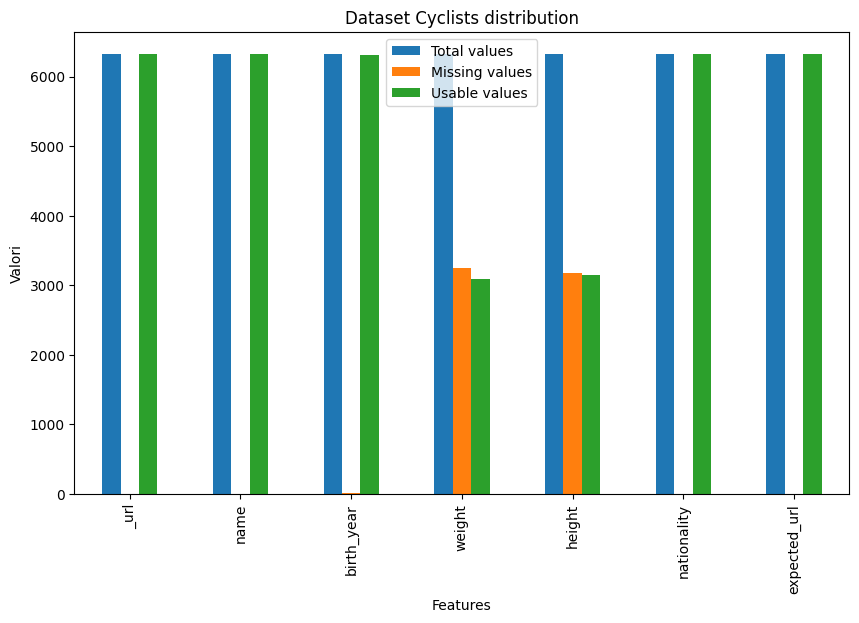

In [20]:
PlotMissingUsableData(DatasetCyclists, "Cyclists")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "weight" e "height".
- Nella colonna "birth_year" manca qualche dato e su "nationality" un solo dato.

### Correct values check (Margherita)

In [21]:
DatasetCyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6324 entries, 0 to 6323
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _url          6324 non-null   object 
 1   name          6324 non-null   object 
 2   birth_year    6303 non-null   float64
 3   weight        3083 non-null   float64
 4   height        3148 non-null   float64
 5   nationality   6323 non-null   object 
 6   expected_url  6324 non-null   object 
dtypes: float64(3), object(4)
memory usage: 346.0+ KB


In [22]:
DatasetCyclists.head()

_url                  name  birth_year  weight  height  \
0           bruno-surra          Bruno  Surra      1964.0     NaN     NaN   
1            gerard-rue           Gérard  Rué      1965.0    74.0   182.0   
2              jan-maas             Jan  Maas      1996.0    69.0   189.0   
3  nathan-van-hooydonck  Nathan Van Hooydonck      1995.0    78.0   192.0   
4      jose-felix-parra     José Félix  Parra      1997.0    55.0   171.0   

   nationality          expected_url  
0        Italy          bruno--surra  
1       France           gerard--rue  
2  Netherlands             jan--maas  
3      Belgium  nathan-van-hooydonck  
4        Spain     jose-felix--parra

In [23]:
DatasetCyclists.describe()

birth_year       weight       height
count  6303.000000  3083.000000  3148.000000
mean   1973.526733    68.649562   179.800191
std      15.707938     6.356160     6.456703
min    1933.000000    48.000000   154.000000
25%    1962.000000    64.000000   175.000000
50%    1974.000000    69.000000   180.000000
75%    1986.000000    73.000000   184.000000
max    2004.000000    94.000000   204.000000

Possiamo vedere il valore minimo e massimo di ogni attributo numerico e constatare che sono valori ammissibili

In [24]:
# Controllo dei valori mancanti
print("Valori mancanti in DatasetCyclists:\n", DatasetCyclists.isnull().sum())

Valori mancanti in DatasetCyclists:
 _url               0
name               0
birth_year        21
weight          3241
height          3176
nationality        1
expected_url       0
dtype: int64


In [25]:
DatasetCyclists[DatasetCyclists.duplicated()]

Empty DataFrame
Columns: [_url, name, birth_year, weight, height, nationality, expected_url]
Index: []

In [26]:
# controllo Duplicati
print("Duplicati in DatasetCyclists:", DatasetCyclists.duplicated().sum())

Duplicati in DatasetCyclists: 0


In [27]:
# Controllo del formato dei nomi
# Regex che include lettere latine estese e trattini
name_pattern = re.compile(r"^[\wÀ-ÖØ-öø-ÿ\s'-]+$")

invalid_names = DatasetCyclists[~DatasetCyclists['name'].str.match(name_pattern, na=False)]
print("Numero di nomi non validi:", invalid_names[['name']].shape[0])

Numero di nomi non validi: 0


In [28]:
#controllo dei valori di url
# Crea la colonna 'expected_url' generata dai valori in 'name' senza accenti
DatasetCyclists['expected_url'] = DatasetCyclists['name'].apply(lambda x: unidecode(x.lower()).replace(' ', '-'))

# Trova righe in cui '_url' non coincide con 'expected_url'
invalid_urls = DatasetCyclists[DatasetCyclists['_url'] != DatasetCyclists['expected_url']]

print("Numero di URL non conformi:", len(invalid_urls))
print("Esempi di URL non conformi:\n", invalid_urls[['_url', 'name', 'expected_url']].head(10))

Numero di URL non conformi: 5938
Esempi di URL non conformi:
                           _url                         name  \
0                  bruno-surra                 Bruno  Surra   
1                   gerard-rue                  Gérard  Rué   
2                     jan-maas                    Jan  Maas   
4             jose-felix-parra            José Félix  Parra   
5              manuel-penalver             Manuel  Peñalver   
6                 willy-moonen                Willy  Moonen   
7                    chad-haga                   Chad  Haga   
9                 scott-davies                Scott  Davies   
10                 stian-remme                 Stian  Remme   
11  jose-angel-gomez-marchante  José Ángel  Gómez Marchante   

                   expected_url  
0                  bruno--surra  
1                   gerard--rue  
2                     jan--maas  
4             jose-felix--parra  
5              manuel--penalver  
6                 willy--moonen  
7     

In [29]:
#controllo dei valori di 'nationality' (non ho altre idee per farlo)

unique_nationalities = DatasetCyclists['nationality'].unique()
print("Nazionalità uniche:\n", unique_nationalities)

Nazionalità uniche:
 ['Italy' 'France' 'Netherlands' 'Belgium' 'Spain' 'United States' nan
 'Norway' 'Russia' 'Poland' 'Germany' 'Australia' 'Switzerland' 'Ireland'
 'Denmark' 'Great Britain' 'Colombia' 'South Africa' 'Argentina'
 'New Zealand' 'Lithuania' 'Portugal' 'Austria' 'Yugoslavia' 'Estonia'
 'Romania' 'Slovenia' 'Canada' 'Latvia' 'Luxembourg' 'Sweden'
 'Czech Republic' 'Slovakia' 'Morocco' 'Ukraine' 'Ethiopia' 'Belarus'
 'Venezuela' 'Japan' 'Mexico' 'Croatia' 'Kazakhstan' 'Uruguay' 'Israel'
 'Namibia' 'Eritrea' 'Costa Rica' 'Taiwan' 'Azerbaijan' 'Hungary'
 'Moldova' 'Panama' 'Finland' 'Bulgaria' 'Serbia' 'Brazil' 'Iran' 'Greece'
 'Chile' 'Ecuador' 'China' 'Albania' 'Guatemala' 'Uzbekistan' 'Algeria'
 'Tunisia' 'Monaco' 'Rwanda' 'Dominican Republic' 'Liechtenstein'
 'Zimbabwe' 'Puerto Rico' 'Hongkong']


### Features distributions

/tmp/ipykernel_776275/56667317.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Avoid overlapping plots


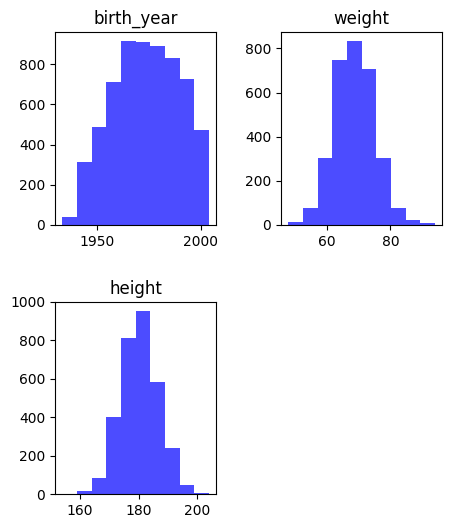

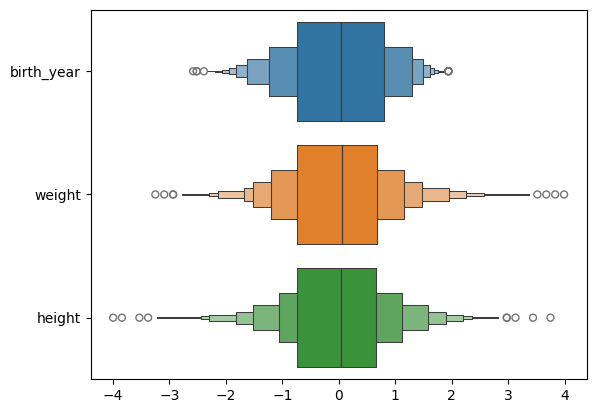

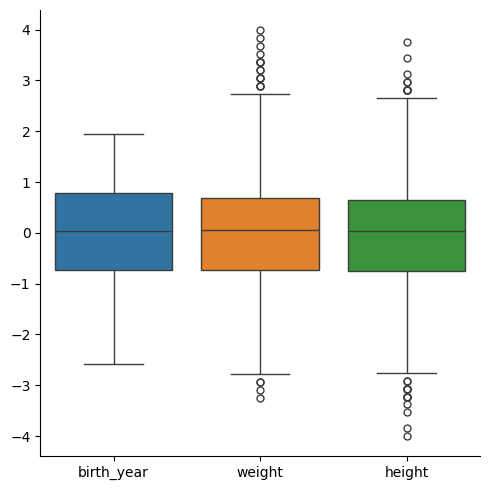

In [30]:
InterestingFeatures = ["birth_year", "weight", "height"]

PlotDistributionFeatures(DatasetCyclists, InterestingFeatures)

Le distribuzioni seguono tutte una distribuzione gaussiana è la presenza di outlier è più (ma non troppo) presente sulle colonne "weight" e "height".

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **cyclists**:

- 

## Dataset race

We discovered three main issues in the dataset:

1. Points Duplication Issue

   - The points and uci_points columns contained identical values across all cyclists within each race
   - These values appeared to be copied from the first-place finisher's point allocation

2. Position Recording Issue

   - Disqualified cyclists retained their original positions in the dataset
   - Subsequent riders were incorrectly shifted down one position
   - Example: If a cyclist in 15th place was disqualified, the replacement rider was incorrectly listed in 16th place

3. Missing cyclists
   
   - Since when we scraped the website, we removed the disqualified cyclist from the race, therefore the cyclists dataset contains cyclist which are not present in the races dataset
   - After scaping we notice that we had competing cyclist that weren't present in the cyclists dataset, we fixed it by scraping the same site for the cyclist's features. 

Based on our investigation, we identified [ProCyclingStats](https://www.procyclingstats.com/index.php) as the likely source of the original data scraping. To ensure data accuracy, we decided to perform a new scraping of this website. The code implementing this improved scraping process is available in our data scraping notebook [OleksiyDataScraping.ipynb](extra_notebooks/OleksiyDataScraping.ipynb).

The code below uses the updated cyclists and races datasets.


### Missing values distributions

                     Total values  Missing values  Usable values
Elements                                                        
_url                       597005               0         597005
name                       597005               0         597005
points                     597005               0         597005
uci_points                 597005          345887         251118
length                     597005               0         597005
climb_total                597005          153584         443421
profile                    597005          154993         442012
startlist_quality          597005               0         597005
average_temperature        597005          567082          29923
date                       597005               0         597005
position                   597005               0         597005
cyclist                    597005               0         597005
cyclist_age                597005               0         597005
is_tarmac                

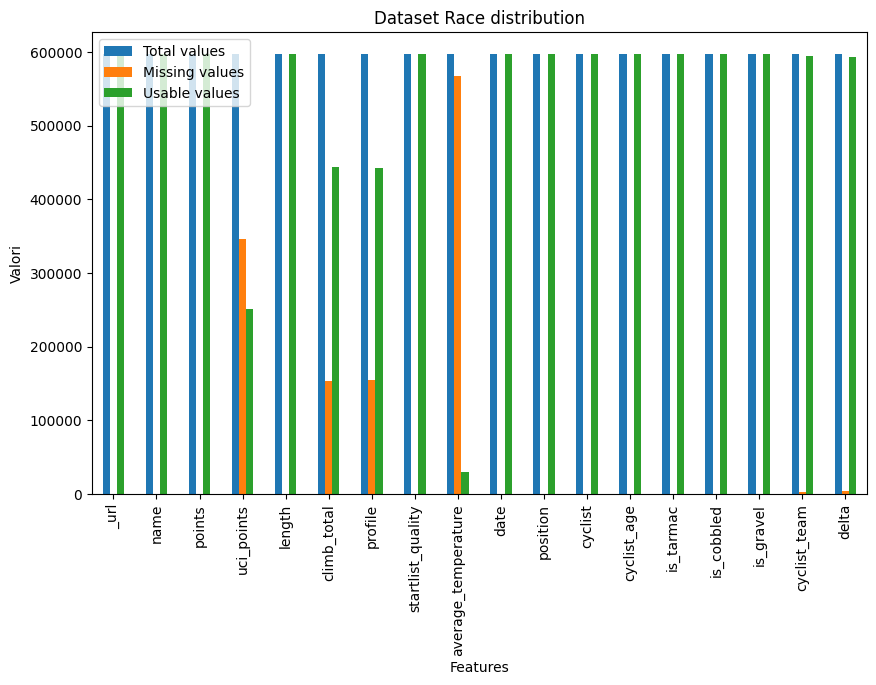

In [31]:
PlotMissingUsableData(DatasetRace, "Race")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "uci_points", "average_temperature", "cyclists_team", "climb_total" e "profile".

### Correct values check (Margherita)

In [32]:
DatasetRace.head()

_url            name  points  uci_points    length  \
0  tour-de-france/1978/stage-6  Tour de France     100         NaN  162000.0   
1  tour-de-france/1978/stage-6  Tour de France      70         NaN  162000.0   
2  tour-de-france/1978/stage-6  Tour de France      50         NaN  162000.0   
3  tour-de-france/1978/stage-6  Tour de France      40         NaN  162000.0   
4  tour-de-france/1978/stage-6  Tour de France      32         NaN  162000.0   

   climb_total  profile  startlist_quality  average_temperature  \
0       1101.0      1.0               1241                  NaN   
1       1101.0      1.0               1241                  NaN   
2       1101.0      1.0               1241                  NaN   
3       1101.0      1.0               1241                  NaN   
4       1101.0      1.0               1241                  NaN   

                  date  position           cyclist  cyclist_age  is_tarmac  \
0  1978-07-05 04:02:24         1        sean-kelly           22       True   
1  1978-07-05 04:02:24         2  gerrie-knetemann           27       True   
2  1978-07-05 04:02:24         3    rene-bittinger           23       True   
3  1978-07-05 04:02:24         4    joseph-bruyere           29       True   
4  1978-07-05 04:02:24         5  sven-ake-nilsson           26       True   

   is_cobbled  is_gravel                 cyclist_team  delta  
0       False      False      Velda - Lano - Flandria    0.0  
1       False      False                 TI - Raleigh    0.0  
2       False      False      Velda - Lano - Flandria    0.0  
3       False      False                          C&A    0.0  
4       False      False  Miko - Mercier - Hutchinson    0.0

In [33]:
DatasetRace.describe()

points     uci_points         length    climb_total  \
count  597005.000000  251118.000000  597005.000000  443421.000000   
mean        3.562880       1.937707  167091.533672    2330.876724   
std        15.182517      18.106511   64547.065467    1377.510425   
min         0.000000       0.000000    1000.000000       2.000000   
25%         0.000000       0.000000  153000.000000    1308.000000   
50%         0.000000       0.000000  178500.000000    2255.000000   
75%         0.000000       0.000000  204000.000000    3274.000000   
max       350.000000     800.000000  338000.000000    6974.000000   

             profile  startlist_quality  average_temperature       position  \
count  442012.000000      597005.000000         29923.000000  597005.000000   
mean        2.612343        1097.638244            21.731377      75.501523   
std         1.491743         380.303561             5.884112      48.611708   
min         1.000000         115.000000            10.000000       1.000000   
25%         1.000000         842.000000            17.000000      33.000000   
50%         2.000000         981.000000            22.000000      72.000000   
75%         4.000000        1309.000000            26.000000     113.000000   
max         5.000000        2047.000000            36.000000     995.000000   

         cyclist_age          delta  
count  597005.000000  592923.000000  
mean       27.937017     442.324560  
std         3.881386    1834.720316  
min         0.000000   -6906.000000  
25%        25.000000      11.000000  
50%        28.000000     161.000000  
75%        31.000000     640.000000  
max        45.000000  132780.000000

Possiamo vedere il valore minimo e massimo di ogni attributo numerico e constatare che sono valori ammissibili, dobbiamo capire il significato di delta<0

In [34]:
DatasetRace[DatasetRace["delta"] < 0]

_url             name  points  uci_points  \
72072   vuelta-a-espana/1992/stage-19  Vuelta a España       5         NaN   
72073   vuelta-a-espana/1992/stage-19  Vuelta a España       4         NaN   
72074   vuelta-a-espana/1992/stage-19  Vuelta a España       3         NaN   
72075   vuelta-a-espana/1992/stage-19  Vuelta a España       2         NaN   
72076   vuelta-a-espana/1992/stage-19  Vuelta a España       1         NaN   
...                               ...              ...     ...         ...   
232883       paris-nice/1990/stage-7a     Paris - Nice       4         NaN   
232884       paris-nice/1990/stage-7a     Paris - Nice       3         NaN   
232885       paris-nice/1990/stage-7a     Paris - Nice       2         NaN   
232886       paris-nice/1990/stage-7a     Paris - Nice       1         NaN   
527809    tour-de-suisse/1993/stage-4   Tour de Suisse      30         NaN   

          length  climb_total  profile  startlist_quality  \
72072    37900.0        294.0      NaN               1033   
72073    37900.0        294.0      NaN               1033   
72074    37900.0        294.0      NaN               1033   
72075    37900.0        294.0      NaN               1033   
72076    37900.0        294.0      NaN               1033   
...          ...          ...      ...                ...   
232883  102000.0          NaN      NaN                995   
232884  102000.0          NaN      NaN                995   
232885  102000.0          NaN      NaN                995   
232886  102000.0          NaN      NaN                995   
527809  212300.0          NaN      NaN                655   

        average_temperature                 date  position  \
72072                   NaN  1992-05-15 00:46:18        11   
72073                   NaN  1992-05-15 00:46:18        12   
72074                   NaN  1992-05-15 00:46:18        13   
72075                   NaN  1992-05-15 00:46:18        14   
72076                   NaN  1992-05-15 00:46:18        15   
...                     ...                  ...       ...   
232883                  NaN  1990-03-11 02:27:45         7   
232884                  NaN  1990-03-11 02:27:45         8   
232885                  NaN  1990-03-11 02:27:45         9   
232886                  NaN  1990-03-11 02:27:45        10   
527809                  NaN  1993-06-18 00:02:25         2   

                         cyclist  cyclist_age  is_tarmac  is_cobbled  \
72072             johan-bruyneel           27       True       False   
72073                raul-alcala           28       True       False   
72074          joachim-halupczok           23       True       False   
72075   djamolidine-abduzhaparov           28       True       False   
72076             guido-bontempi           32       True       False   
...                          ...          ...        ...         ...   
232883            francis-moreau           24       True       False   
232884          laurent-jalabert           21       True       False   
232885        claudio-chiappucci           27       True       False   
232886       jean-claude-colotti           28       True       False   
527809            marco-saligari           28       True       False   

        is_gravel              cyclist_team   delta  
72072       False   O.N.C.E. - Look - Mavic -2635.0  
72073       False   PDM - Ultima - Concorde -2638.0  
72074       False          GB-MG Maglificio -2541.0  
72075       False  Carrera Jeans - Vagabond -2542.0  
72076       False  Carrera Jeans - Vagabond -2545.0  
...           ...                       ...     ...  
232883      False            Histor - Sigma -5562.0  
232884      False                   Toshiba -5562.0  
232885      False  Carrera Jeans - Vagabond -5562.0  
232886      False     RMO - Mavic - Liberia -6906.0  
527809      False                  Ariostea  -106.0  

[86 rows x 18 columns]

In [35]:
#controllo che delta = 0 per position = 0
pos = DatasetRace["position"] == 0
d = DatasetRace["delta"] != 0
print("numero di righe dove la posizione è 0 e delta è diverso da zero: ",DatasetRace[pos & d].shape[0])

numero di righe dove la posizione è 0 e delta è diverso da zero:  0


In [36]:
# Controlla che il delta sia crescente all'aumentare della posizione

# Ordinare il dataset per 'position' e 'delta'
tour = DatasetRace[DatasetRace['_url'] == "vuelta-a-espana/1992/stage-19"]
print(tour[['_url', 'position', 'delta']])

DatasetRace_sorted = tour.sort_values(by=['position', 'delta'])

invalid_deltas = DatasetRace_sorted[DatasetRace_sorted['delta'].diff() < 0]

# Filtrare per mostrare solo i casi in cui la posizione aumenta
invalid_deltas = invalid_deltas[DatasetRace_sorted['position'].diff() > 0]

print("Numero di righe con delta non coerente rispetto alla posizione:", len(invalid_deltas))
print("Esempi di righe con delta non coerente:\n", invalid_deltas[['_url', 'position', 'delta']].head())

                                _url  position   delta
72062  vuelta-a-espana/1992/stage-19         1     0.0
72063  vuelta-a-espana/1992/stage-19         2    52.0
72064  vuelta-a-espana/1992/stage-19         3    68.0
72065  vuelta-a-espana/1992/stage-19         4    93.0
72066  vuelta-a-espana/1992/stage-19         5   100.0
...                              ...       ...     ...
72143  vuelta-a-espana/1992/stage-19        82 -2391.0
72144  vuelta-a-espana/1992/stage-19        83 -2393.0
72145  vuelta-a-espana/1992/stage-19        84 -2394.0
72146  vuelta-a-espana/1992/stage-19        85 -2397.0
72147  vuelta-a-espana/1992/stage-19        86 -2399.0

[86 rows x 3 columns]
Numero di righe con delta non coerente rispetto alla posizione: 62
Esempi di righe con delta non coerente:
                                 _url  position   delta
72072  vuelta-a-espana/1992/stage-19        11 -2635.0
72073  vuelta-a-espana/1992/stage-19        12 -2638.0
72075  vuelta-a-espana/1992/stage-19        

/tmp/ipykernel_776275/3236545019.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  invalid_deltas = invalid_deltas[DatasetRace_sorted['position'].diff() > 0]


In [37]:
# Controllo dei valori mancanti
print("Valori mancanti in DatasetRace:\n", DatasetRace.isnull().sum())

Valori mancanti in DatasetRace:
 _url                        0
name                        0
points                      0
uci_points             345887
length                      0
climb_total            153584
profile                154993
startlist_quality           0
average_temperature    567082
date                        0
position                    0
cyclist                     0
cyclist_age                 0
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team             2457
delta                    4082
dtype: int64


Dal momento che l'attributo average_temperature 557121 valori mancanti su un totale di 586982, questa colonna verrà tolta dal dataset perchè non ha abbastanza valori da essere significativa.

In [38]:
# controllo dei Duplicati
print("Duplicati in DatasetRace:", DatasetRace.duplicated().sum())

Duplicati in DatasetRace: 0


Dopo l'operazione di scraping sono emerse righe duplicate che non erano presenti nel dataset race originale, questo perchè in quest'ultimo ci sono delle righe in cui è presente lo stesso ciclista nella stessa tappa della stessa gara con due posizioni diverse. Quindi dopo aver corretto le posizioni tramite scraping, abbiamo eliminato le 43 righe duplicate.

In [39]:
len(DatasetRace)

597005

In [40]:
DatasetRace = DatasetRace.drop_duplicates()

In [41]:
len(DatasetRace)

597005

In [42]:
# _url
# Controllo che non ci siano spazi o caratteri non validi negli URL
invalid_urls = DatasetRace[~DatasetRace['_url'].str.match(r'^[\w/:.-]+$', na=False)]

print("Numero di URL non validi:", invalid_urls.shape[0])

Numero di URL non validi: 0


In [43]:
# Controllo nomi 
import re
# Regex che include lettere latine estese, trattini e anche il carattere '/'
name_pattern = re.compile(r"^[\wÀ-ÖØ-öø-ÿ\s'/-]+$")

invalid_names_race = DatasetRace[~DatasetRace['name'].str.match(name_pattern, na=False)]
print("Numero di nomi non validi:", invalid_names_race['name'].shape[0])

Numero di nomi non validi: 0


In [44]:
# Controllo che le date siano valide
invalid_dates = DatasetRace[~DatasetRace['date'].str.match(r'^\d{4}-\d{2}-\d{2}.*$', na=False)]
print("Numero di date non valide:", invalid_dates['date'].shape[0])

Numero di date non valide: 0


In [45]:
# Controllo cyclist
invalid_cyclists = DatasetRace[~DatasetRace['cyclist'].str.match(r"^[\w-]+$", na=False)]
print("Numero di nomi dei ciclisti non validi:", invalid_cyclists['cyclist'].shape[0])

Numero di nomi dei ciclisti non validi: 0


In [46]:
# cerco se ci sono ciclisti in DatasetRace che non sono presenti in DatasetCyclists
missing_cyclists = DatasetRace[~DatasetRace['cyclist'].isin(DatasetCyclists['_url'])]

print("Numero di ciclisti non presenti in DatasetCyclists:", len(missing_cyclists))

Numero di ciclisti non presenti in DatasetCyclists: 0


In [47]:
# cerco se ci sono ciclisti in DatasetCyclists che non sono presenti in DatasetRace
SetCyclistsURL = set(DatasetCyclists["_url"])
SetRaceCyclist = set(DatasetRace["cyclist"])

Intersection = SetCyclistsURL.intersection(SetRaceCyclist)

print(f"Numero di ciclisti che non gareggiano: {len(SetCyclistsURL.difference(Intersection))}")
print(f"Numero di ciclisti che gareggiano ma non sono presenti nel race dataset: {len(SetRaceCyclist.difference(Intersection))}")

Numero di ciclisti che non gareggiano: 40
Numero di ciclisti che gareggiano ma non sono presenti nel race dataset: 0


In [48]:
# Controllo team dei ciclisti
invalid_teams = DatasetRace[DatasetRace['cyclist_team'].notna() & ~DatasetRace['cyclist_team'].str.match(r"^[\w\s\-.&/]+$", na=False)]

print("Numero di team non validi in DatasetRace:", invalid_teams.shape[0])

Numero di team non validi in DatasetRace: 19565


In [49]:
#controllo i che i valori di is_tarmac, is_cobbled e is_gravel siano True o False
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_tarmac'].isin([True, False])].shape[0])
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_cobbled'].isin([True, False])].shape[0])
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_gravel'].isin([True, False])].shape[0])

Valori non booleani in DatasetRace: 0
Valori non booleani in DatasetRace: 0
Valori non booleani in DatasetRace: 0


In [50]:
# controllo se almeno uno tra is_tarmac(asfalto), is_cobbled(acciottolato) e is_gravel(di ghiaia) è vero
unknown_surface = DatasetRace[(~DatasetRace['is_tarmac']) & 
                                  (~DatasetRace['is_cobbled']) & 
                                  (~DatasetRace['is_gravel'])]

unique_url = unknown_surface.drop_duplicates(subset=['_url'])

print("Numero di gare con tipo di strada sconosciuto:", len(unique_url))
print("Esempi di gare con tipo di strada sconosciuto:\n", unique_url[['name','is_tarmac','is_cobbled','is_gravel']].head(10))


Numero di gare con tipo di strada sconosciuto: 636
Esempi di gare con tipo di strada sconosciuto:
                                            name  is_tarmac  is_cobbled  \
1270   Ronde van Vlaanderen / Tour des Flandres      False       False   
1485                             Milano-Sanremo      False       False   
5436                         La Flèche Wallonne      False       False   
6119                         E3-Prijs Harelbeke      False       False   
7731                   Liège - Bastogne - Liège      False       False   
8325                              Paris-Roubaix      False       False   
11525                        La Flèche Wallonne      False       False   
11891                  Liège - Bastogne - Liège      False       False   
12291        World Championships ME - Road Race      False       False   
12881                          Amstel Gold Race      False       False   

       is_gravel  
1270       False  
1485       False  
5436       False  
6119      

Troppe strade hanno tipo di strada sconosciuto per poterle riempire

In [51]:
print("Numero di gare con tipo di strada gravel:", len(DatasetRace[DatasetRace['is_gravel']]))
print("Numero di gare con tipo di strada gravel:", len(DatasetRace[DatasetRace['is_cobbled']]))

Numero di gare con tipo di strada gravel: 0
Numero di gare con tipo di strada gravel: 0


Dal momento che le due valiabili 'is_gravel' e 'is_cobbled' contengono solo valori False, verranno ignorate nell'analisi

In [52]:
# controllo se birth_year+cyclist_age=race_year
# Unione dei dataset sulla colonna 'name' e 'cyclist'
merged_data = pd.merge(DatasetRace, DatasetCyclists.rename(columns={'name': 'cyclist_name'}), left_on='cyclist', right_on='cyclist_name', how='inner')

merged_data['race_year'] = pd.to_datetime(merged_data['date']).dt.year

# Calcolo l'anno di nascita previsto (race_year - cyclist_age)
merged_data['expected_birth_year'] = merged_data['race_year'] - merged_data['cyclist_age']

# cercare le righe dove birth_year non corrisponde con l'expected_birth_year
invalid_birth_years = merged_data[merged_data['birth_year'] != merged_data['expected_birth_year']]

print("Numero di righe con discrepanze negli anni di nascita:")
print(invalid_birth_years[['cyclist_name', 'cyclist', 'birth_year', 'cyclist_age', 'race_year', 'expected_birth_year']].shape[0])


Numero di righe con discrepanze negli anni di nascita:
0


### Features distributions

/tmp/ipykernel_776275/56667317.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Avoid overlapping plots


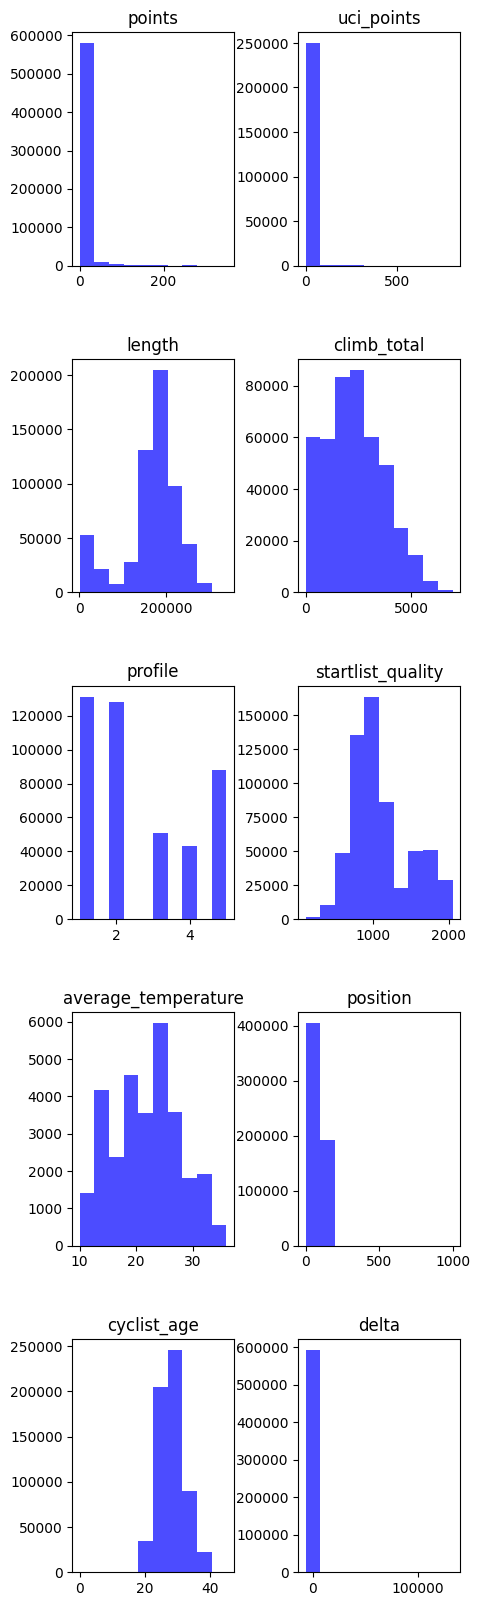

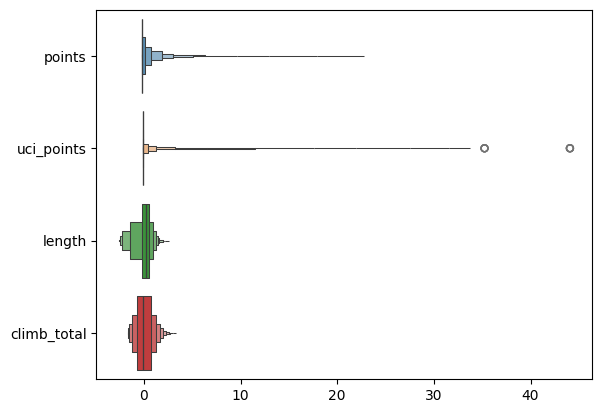

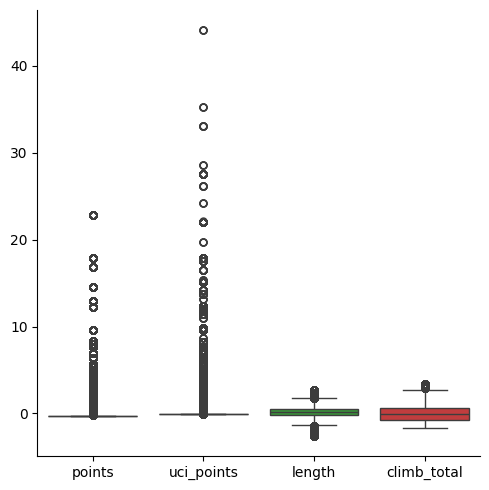

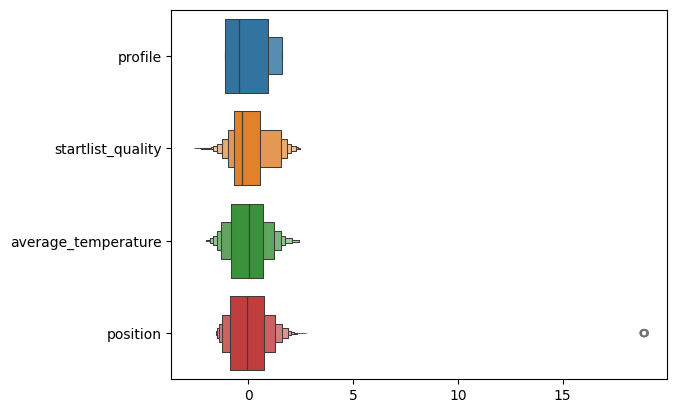

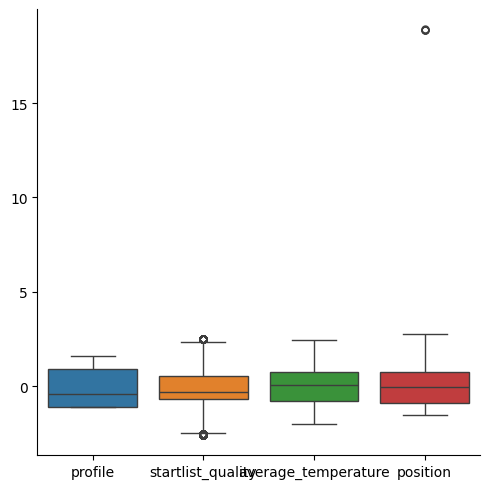

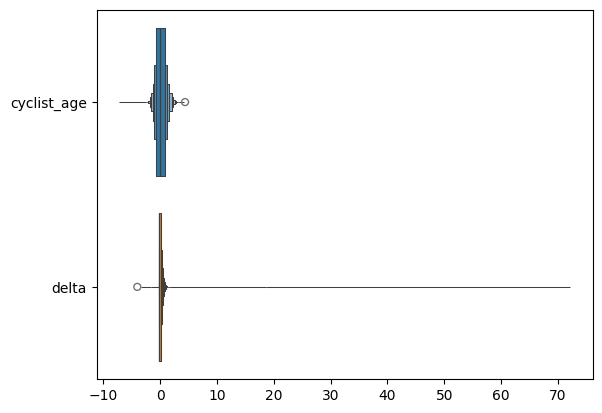

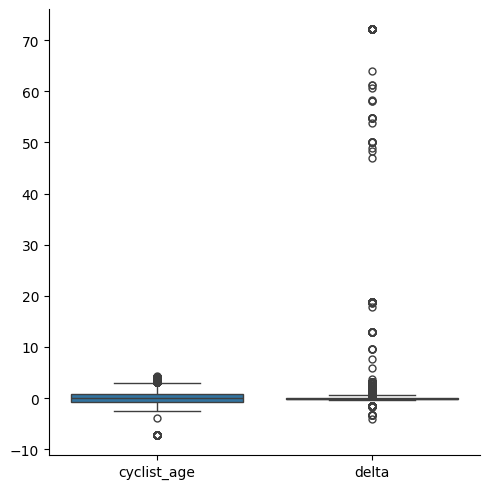

In [53]:
InterestingFeatures = ["points", "uci_points", "length", "climb_total", "profile",
                       "startlist_quality", "average_temperature", "position", "cyclist_age", "delta"]

PlotDistributionFeatures(DatasetRace, InterestingFeatures)

Nella maggior parte delle colonne ci sono distribuzioni non uniformi e la presenza di outlier è sopratutto su "delta", "cyclists_age" e "climb_total" 

## Relationship Between Features

What follows are the most important relationships between features, in my opinion, to show.
To see a complete analysis go to file [OleksiyRelFeature.ipynb](extra_notebooks/OleksiyRelFeature.ipynb)

In [54]:
all_cyclists_not_in_race = DatasetCyclists[~DatasetCyclists['_url'].isin(DatasetRace['cyclist'])]
cyclists_only_in_race = DatasetRace[~DatasetRace['cyclist'].isin(DatasetCyclists['_url'])]
print("Numero di ciclisti non presenti in DatasetRace:", len(all_cyclists_not_in_race))
print("Numero di ciclisti non presenti in DatasetCyclists:", len(cyclists_only_in_race))

# DatasetCyclists[DatasetCyclists['_url'] == "miroslav-uryga"]
# all_cyclists_not_in_race
# cyclists_only_in_race[cyclists_only_in_race['cyclist'] == "oscar-pelliccioli"]
DatasetCyclists[DatasetCyclists['_url'].str.contains("ignacio-garci")]

Numero di ciclisti non presenti in DatasetRace: 40
Numero di ciclisti non presenti in DatasetCyclists: 0


_url             name  birth_year  weight  height  \
2171   ignacio-garcia  Ignacio  García      1968.0     NaN     NaN   
6134  ignacio-garcia3  Ignacio  García      1968.0     NaN     NaN   

     nationality     expected_url  
2171       Spain  ignacio--garcia  
6134       Spain  ignacio--garcia

### Begin the analysis with a correlation matrix

Let's begin the analysis with a big correlation matrix that contains all the significant features from the `DatasetCyclists` and `DatasetRaces` frames.


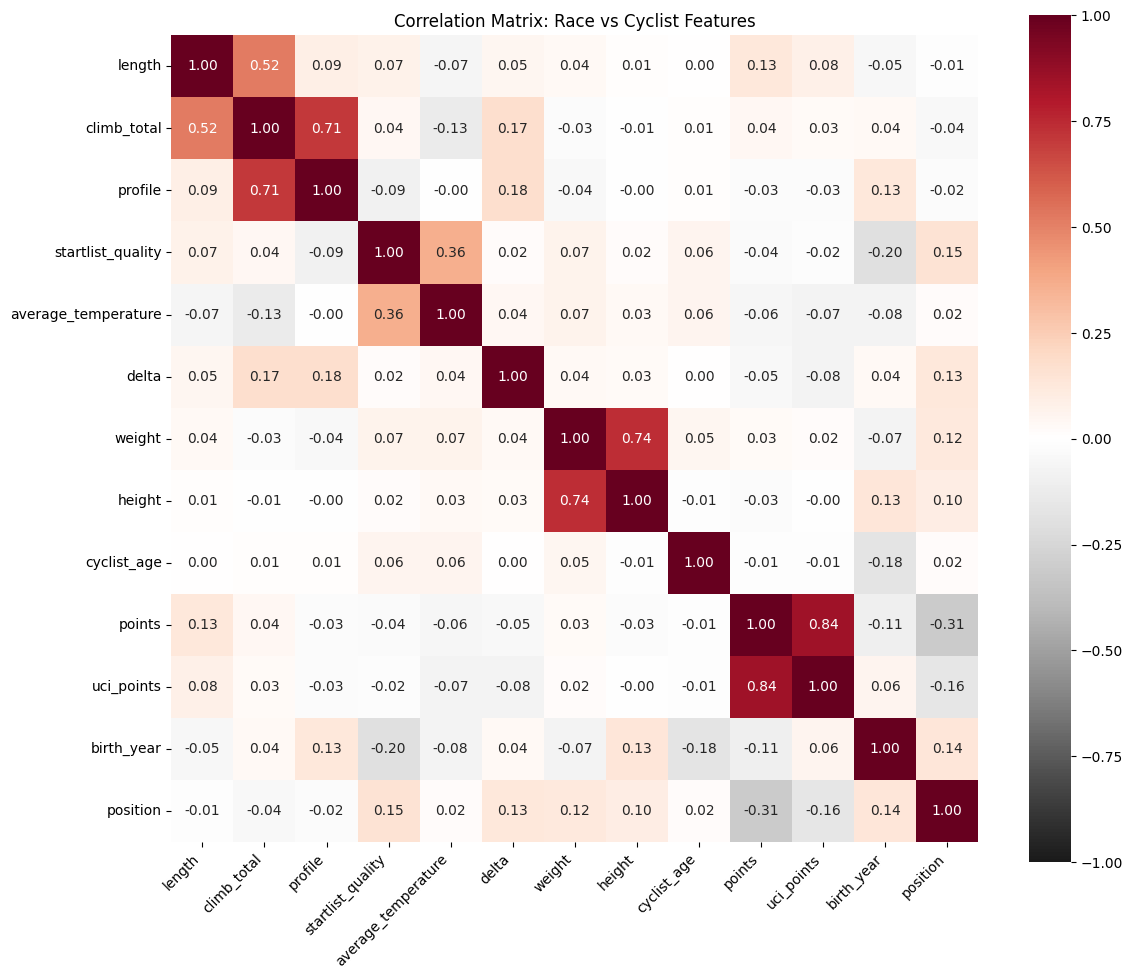

In [55]:
from correl_code import create_correlation_matrix

columns_of_interest = [
        'length', 'climb_total', 'profile', 'startlist_quality', 
        'average_temperature', 'delta', 'weight', 'height', 
        'cyclist_age', 'points', 'uci_points', 'birth_year', 'position'
]


fig,corr_matrix = create_correlation_matrix(merged_df=MergedDataset, columns_of_interest=columns_of_interest)
plt.show()
plt.close(fig)


#### Since the best correlations might be hard to see, I will show below the top 6 positive and negative ones.


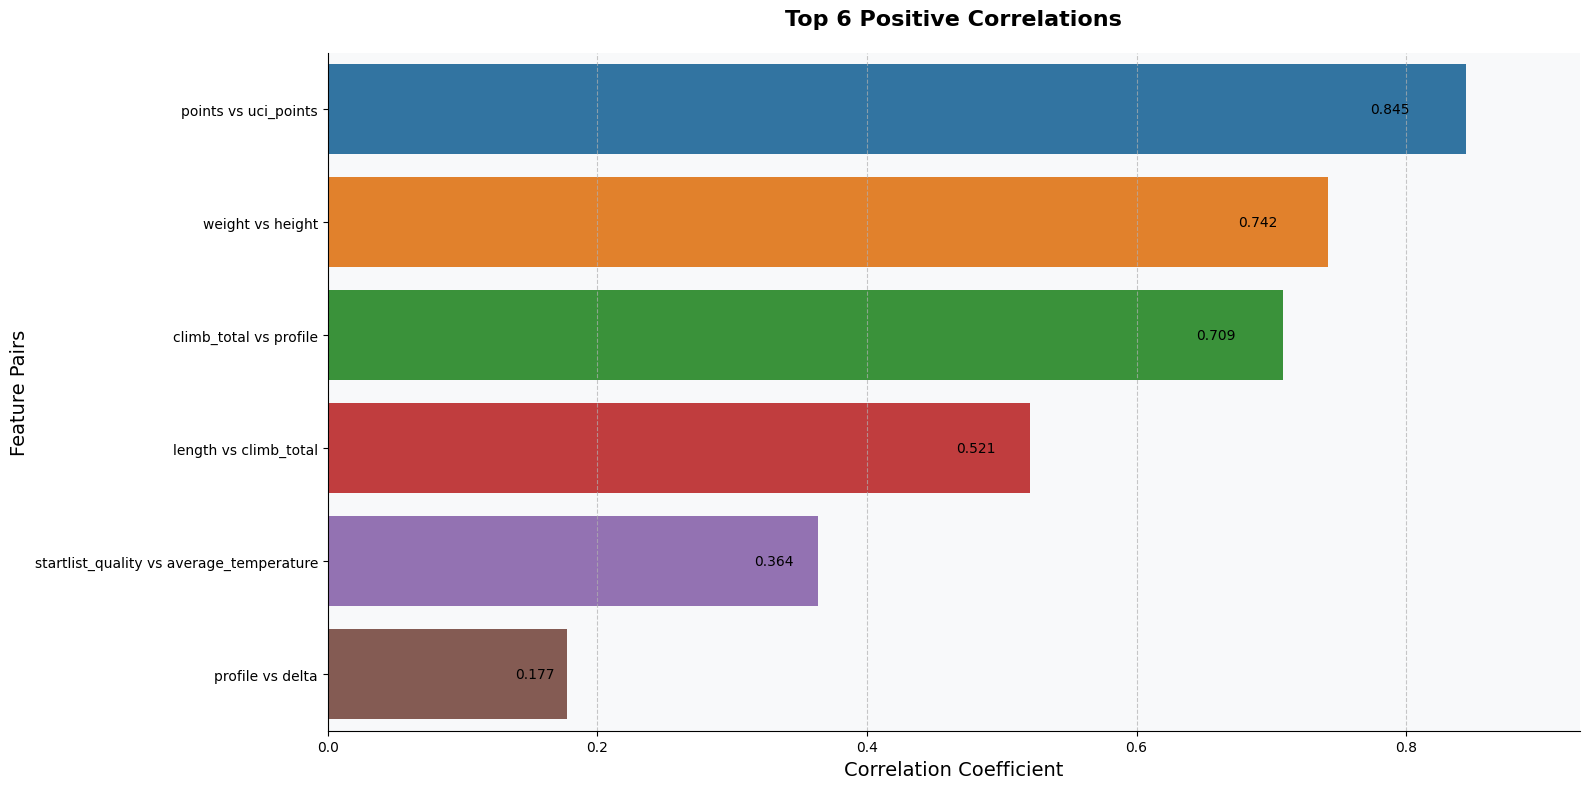

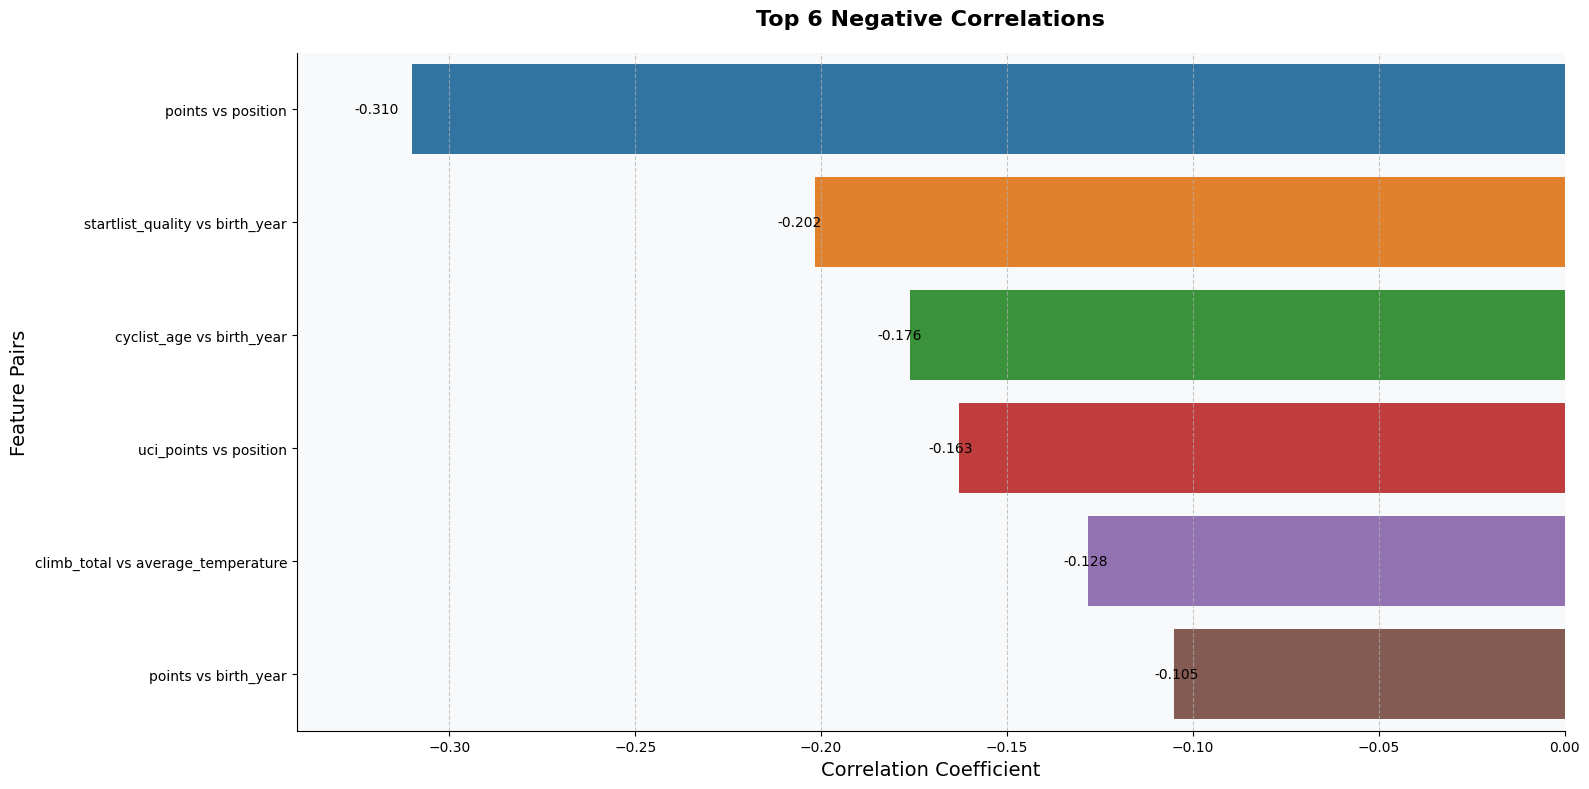

In [56]:
from correl_code import display_top_correlations, print_top_positive_correlations, print_top_negative_correlations
dfs = display_top_correlations(corr_matrix)

# Create the figure and axis with a specific size
print_top_positive_correlations(dfs[0], "Top 6 Positive Correlations")
print_top_negative_correlations(dfs[1], "Top 6 Negative Correlations")


#### Comments on the positive correlations
There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.

#### Comments on the negative correlations

There is a small correlation between the ```startlist_quality``` feature and the birth_year, which might suggest that if the race has many young riders, it will have lower `startlist_quality`. The negative correlation between points and `birth_year` makes sense since younger cyclists tend to have fewer `points`.

There is a slightly negative correlation between the `average_temperature` and `uci_points` that can be further investigated.


#### `weight`, `height` and race `profile` influence the `position`? 

Let's see if the `weight` and `height` of the riders, coupled with the race `profile`, influence the position of the cyclist.

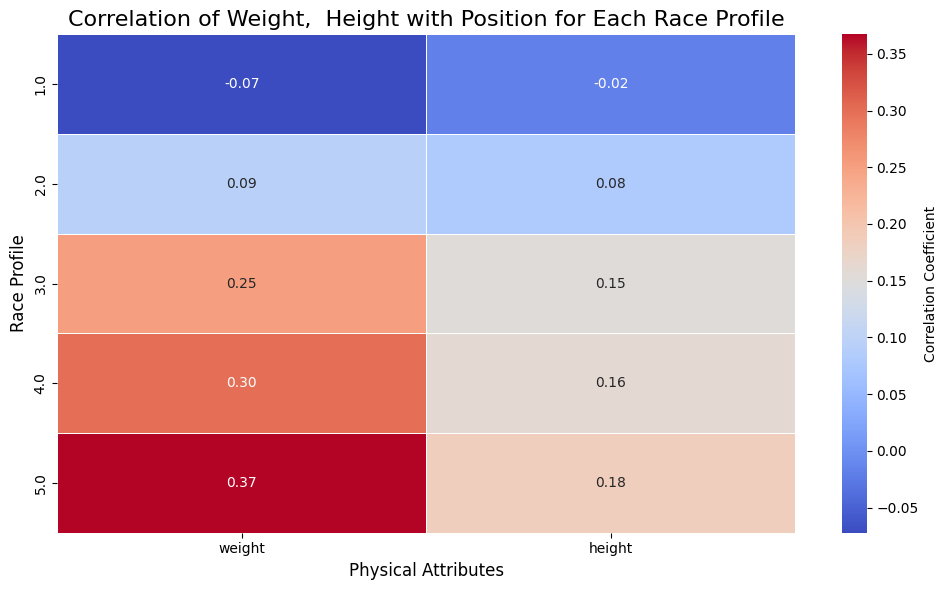

In [57]:
whpp_cor_feat = ['weight', 'height', 'position', 'profile']
whpp_cor_df = MergedDataset[whpp_cor_feat].copy()

correlations = whpp_cor_df.groupby('profile')[['weight', 'height', 'position']].corr()

correlations = correlations.xs('position', level=1).drop('position', axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = seaborn.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Customize the heatmap
heatmap.set_title('Correlation of Weight,  Height with Position for Each Race Profile', fontsize=16)
heatmap.set_xlabel('Physical Attributes', fontsize=12)
heatmap.set_ylabel('Race Profile', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()
del whpp_cor_df

It clearly shows that lighter riders tend to finish in better positions when the climbing is significant, which makes perfect sense. The height has a smaller correlation, but we can still say that height might influence the final position of the rider if the race has a high profile.

### Correlation between `average_temperature`, `nationality`, and `age_group`

Even though the `average_temperature` column has many `NaN` values, it is interesting to examine the mentioned correlations.



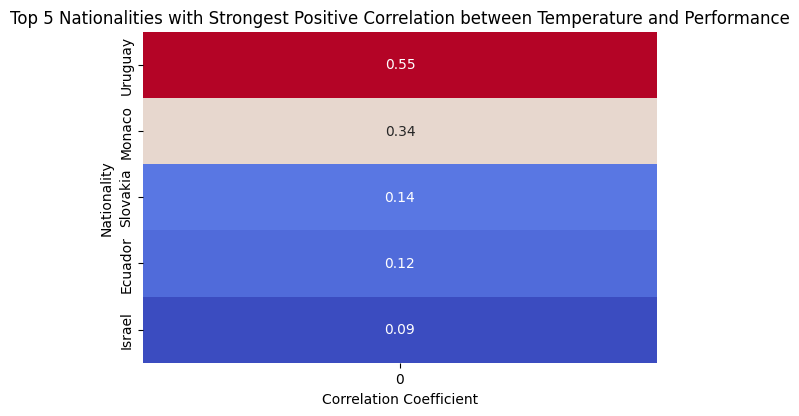

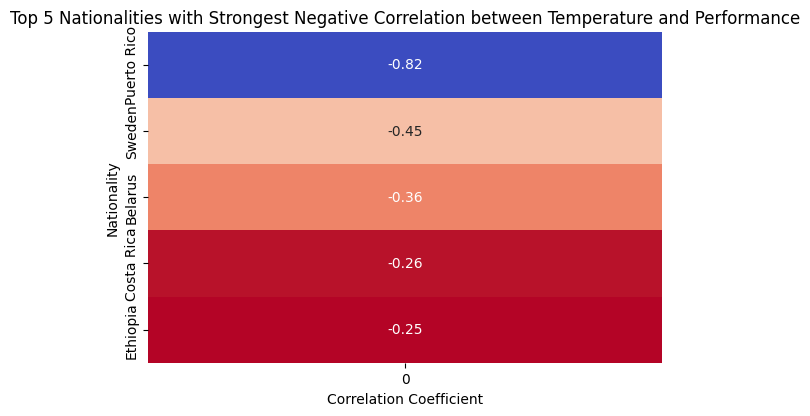

In [58]:
from correl_code import calc_group_correlations

ana_cor_feat = ['average_temperature', 'points', 'uci_points', 'position', 'nationality', 'cyclist_age']
ana_cor_df = MergedDataset[ana_cor_feat].copy()

# where uci_points is not null and position is null insert insert uci_points in position
ana_cor_df['position'] = ana_cor_df['position'].fillna(ana_cor_df['uci_points'])
ana_cor_df.dropna(subset=['points', 'average_temperature'], inplace=True)

nationality_correlations = calc_group_correlations(ana_cor_df, 'nationality')

heatmap_data = nationality_correlations.nlargest(5).to_frame()


heatmap = seaborn.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Positive Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()

heatmap = seaborn.heatmap(nationality_correlations.nsmallest(5).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Negative Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()


As the correlation shows, riders coming from warmer countries may perform better in higher temperatures. In contrast, athletes from colder countries might struggle as temperatures rise. The outlier here is Puerto Rico, which could be interesting to investigate further.

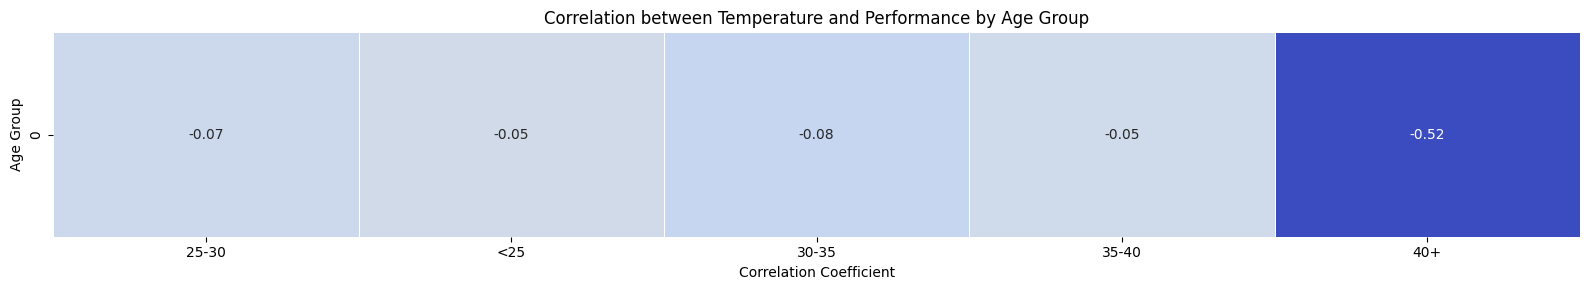

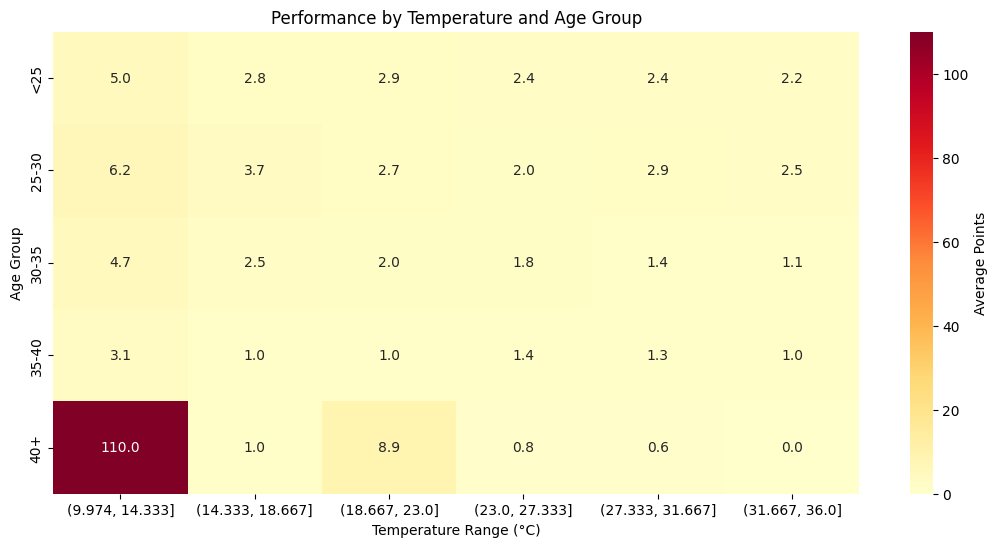

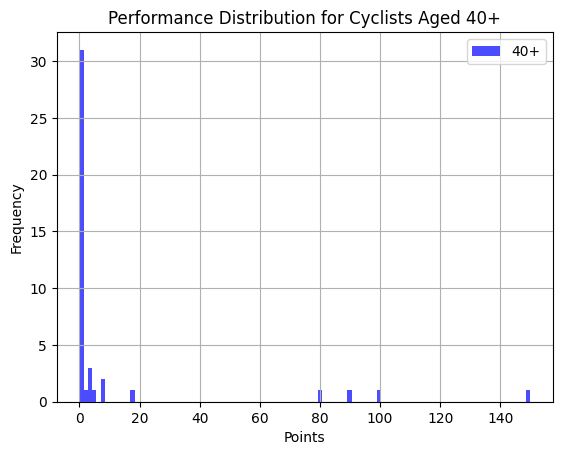

In [59]:
plt.figure(figsize=(16, 3))
ana_cor_df['age_group'] = pd.cut(ana_cor_df['cyclist_age'], bins=[0, 25, 30, 35, 40, 100], labels=['<25', '25-30', '30-35', '35-40', '40+'])
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
age_group_correlations = calc_group_correlations(ana_cor_df, 'age_group')

heatmap = seaborn.heatmap(age_group_correlations.to_frame().T, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", cbar=False)
heatmap.set_title('Correlation between Temperature and Performance by Age Group')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Age Group')

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(13, 6))
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
seaborn.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Average Points'})
plt.title('Performance by Temperature and Age Group')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Age Group')
plt.show()
plt.close()
ana_cor_df[ana_cor_df['age_group'] == '40+']['points'].hist(bins='auto', alpha=0.7, color='blue', label='40+')
plt.title('Performance Distribution for Cyclists Aged 40+')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.close()

del ana_cor_df


The correlation between temperature and age groups might suggest that the older the rider, the stronger the temperature influences the rider's performance. However, as we can see in the second figure, there is an anomalously high average points in the colder temperature range for the 40+ age group, which might indicate outliers. Moreover, the histogram clearly shows that these are outliers due to their frequency.

### Cyclist's Career Span

Next, we will see the career span of top cyclists and how age influences their performance.


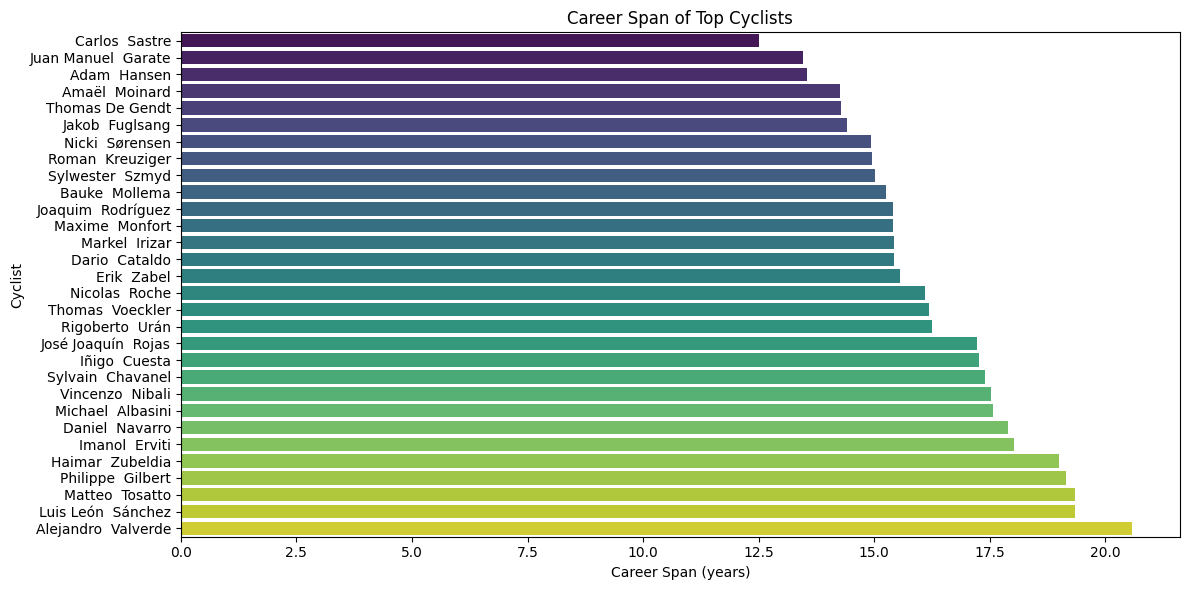

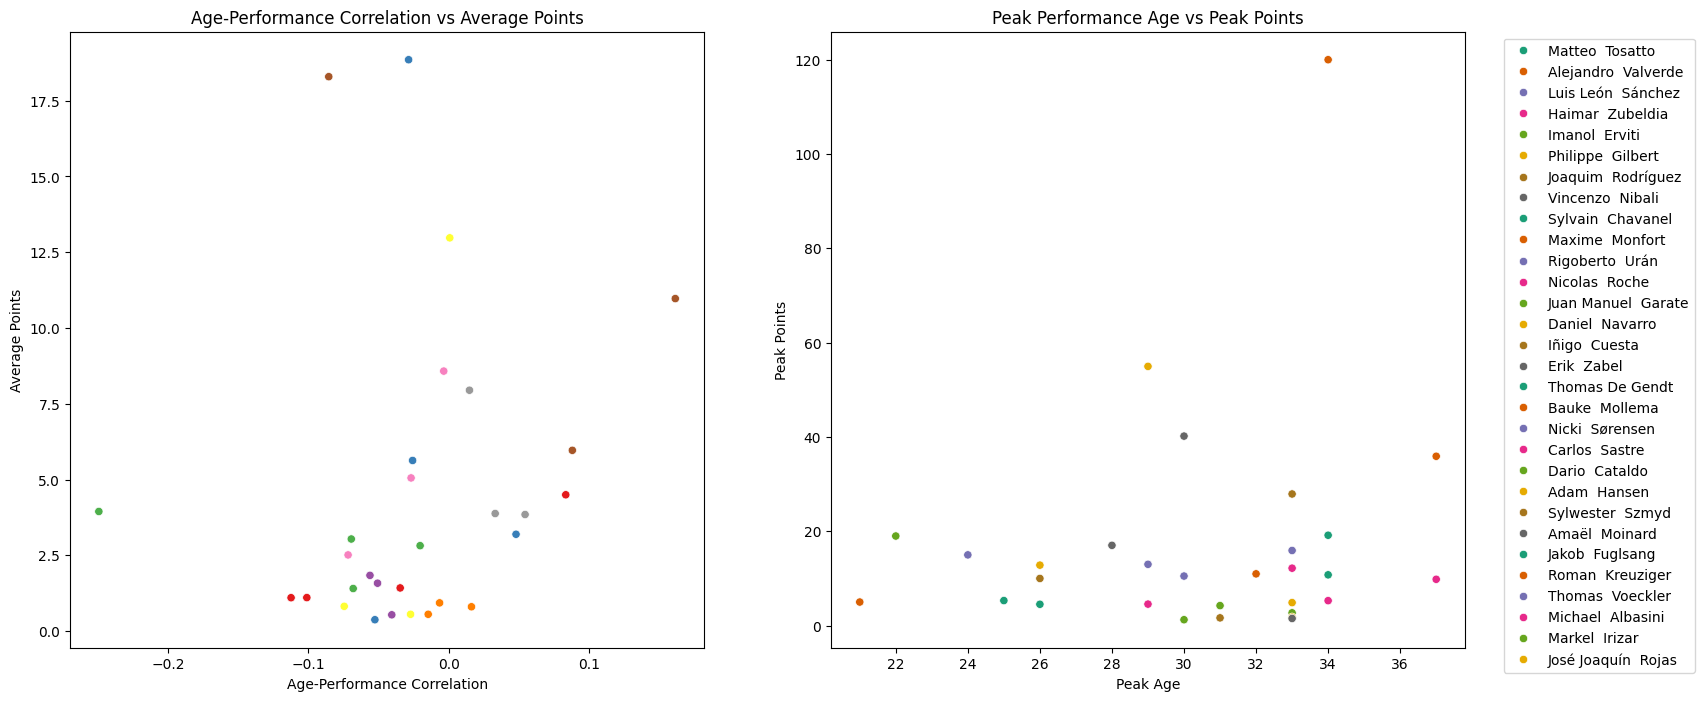

In [60]:
from correl_code import analyze_cyclist_progression, analyze_performance_peaks

cs_cor_feat = ['points', 'uci_points', 'position', 'date', 'name', 'cyclist_age', 'cyclist', 'birth_year']
cs_cor_dr = MergedDataset[cs_cor_feat].copy()
cs_cor_dr['date'] = pd.to_datetime(cs_cor_dr['date'])
cs_cor_dr['year'] = cs_cor_dr['date'].dt.year
top_cyclists = cs_cor_dr['cyclist'].value_counts().index[:30]
progression_data = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in top_cyclists]

progression_df = pd.DataFrame([data for data in progression_data if data is not None])

plt.figure(figsize=(12, 6))
seaborn.barplot(
    x='career_span', 
    y='name', 
    data=progression_df.sort_values('career_span'), 
    hue='name', 
    dodge=False,  # This avoids separating bars by hue
    palette='viridis', 
    legend=False
)
plt.title('Career Span of Top Cyclists')
plt.xlabel('Career Span (years)')
plt.ylabel('Cyclist')
plt.tight_layout()
plt.show()
plt.close()




# Visualize age-performance correlation
fig = plt.figure(figsize=(18, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='age_performance_correlation', y='avg_points', data=progression_df, hue='name', palette='Set1')
ax1.set_title('Age-Performance Correlation vs Average Points')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Average Points')
ax1.get_legend().remove()

peak_df = pd.DataFrame([analyze_performance_peaks(cyclist, cs_cor_dr) for cyclist in top_cyclists])

ax2 = fig.add_subplot(gs[0, 1])
# Visualize peak ages with annotations
seaborn.scatterplot(x='peak_age', y='peak_points', data=peak_df, hue='name', palette='Dark2')
ax2.set_title('Peak Performance Age vs Peak Points')
ax2.set_xlabel('Peak Age')
ax2.set_ylabel('Peak Points')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()
plt.close()


del peak_df 
del progression_df


We can see that there aren't many cyclists with long careers. We can also see that for some, age has a negative effect, while for others, it has a slightly positive one. The peak performance, for the majority, occurs in the span between 25 and 35 years. Some outliers are noticeable for peak performance and peak age.

#### Let's plot the age-performance correlation for each rider.

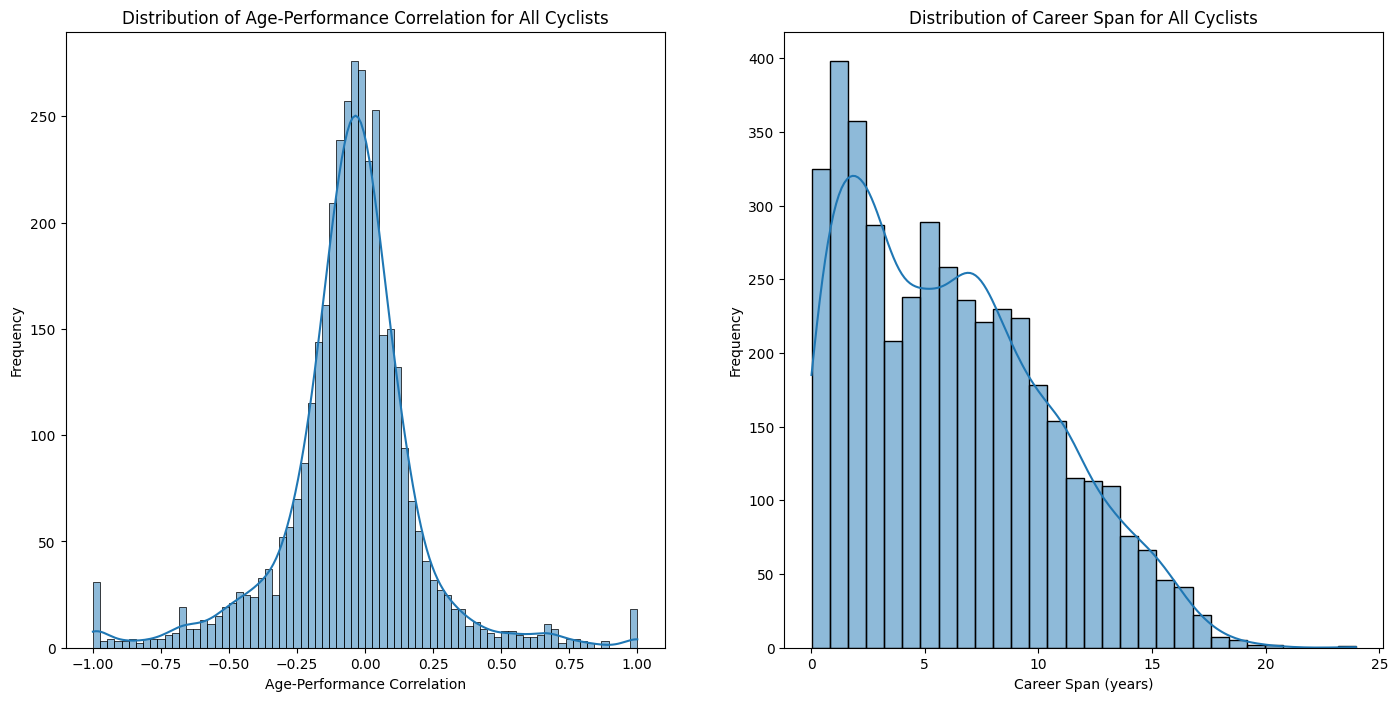

In [61]:
all_cyclists = cs_cor_dr['cyclist'].unique()
progression_data_all_cyclists = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in all_cyclists]
progression_data_all_cyclists = [data for data in progression_data_all_cyclists if data is not None]

prog_df = pd.DataFrame(progression_data_all_cyclists)


# Visualize age-performance correlation for all cyclists
fig = plt.figure(figsize=(17, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = plt.subplot(gs[0, 0])
seaborn.histplot([data['age_performance_correlation'] for data in progression_data_all_cyclists], bins="auto", kde=True)
ax1.set_title('Distribution of Age-Performance Correlation for All Cyclists')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Frequency')

ax2 = plt.subplot(gs[0, 1])
seaborn.histplot(prog_df['career_span'], bins=30, kde=True)
ax2.set_title('Distribution of Career Span for All Cyclists')
ax2.set_xlabel('Career Span (years)')
ax2.set_ylabel('Frequency')
plt.show()
plt.close(fig)
del prog_df
del cs_cor_dr

The results show a clearly bell-shaped distribution, which isn't surprising. For some, age does hinder performance, but for most, it doesn't.

As regards the histogram of career span, we can see that the distribution is right-skewed, meaning there are very few cyclists with long careers. Surprisingly, the number of riders that have a cycling span between 0 and 3 years is high, which might mean that cycling is a very physically demanding sport.

### Physical Attributes of Top Performers by Race Type


In [62]:
from correl_code import radar_plot

tprt_rad_feat = ['name', 'height', 'weight', 'date', 'profile', 'points', 'cyclist_age']

tprt_rad_df = MergedDataset[tprt_rad_feat].copy().dropna(subset=['height', 'weight', 'points'])

# Calculate BMI
tprt_rad_df['bmi'] = tprt_rad_df['weight'] / ((tprt_rad_df['height'] / 100) ** 2)

# Calculate years of experience
tprt_rad_df['career_start'] = tprt_rad_df.groupby('name')['date'].transform('min')
tprt_rad_df['experience'] = (pd.to_datetime(tprt_rad_df['date']) - pd.to_datetime(tprt_rad_df['career_start'])).dt.days / 365.25

# Function to categorize race profile
def categorize_profile(profile):
    if profile < 1.5:
        return 'Flat'
    elif profile < 3:
        return 'Hilly'
    elif profile < 4:
        return 'Mountainous'
    elif profile < 5:
        return 'High Mountainous'
    else:
        return 'Really High Mountainous'

# Add race category to the dataframe
tprt_rad_df['race_category'] = tprt_rad_df['profile'].apply(categorize_profile)

# Function to get top performer for each race category
def get_top_performer(category):
    category_data = tprt_rad_df[tprt_rad_df['race_category'] == category]
    top_cyclist = category_data.groupby('name')['points'].mean().idxmax()
    return category_data[category_data['name'] == top_cyclist].iloc[0]

# Get top performers
top_performers = {
    'Flat': get_top_performer('Flat'),
    'Hilly': get_top_performer('Hilly'),
    'Mountainous': get_top_performer('Mountainous'),
    'High Mountainous': get_top_performer('High Mountainous'),
    'Really High Mountainous': get_top_performer('Really High Mountainous')
}

# Prepare data for radar plot
attributes = ['height', 'weight', 'bmi', 'cyclist_age', 'experience']
data = {category: [cyclist[attr] for attr in attributes] for category, cyclist in top_performers.items()}

# Normalize the data separately for each attribute
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pd.DataFrame(data, index=attributes).T).T



# Create the plot with normalized data and cyclist names
cyclist_names = {category: cyclist['name'] for category, cyclist in top_performers.items()}
fig = radar_plot(dict(zip(top_performers.keys(), normalized_data)), 
                 "Physical Attributes of Top Performers by Race Type", cyclist_names, attributes)

# Show the plot
fig.show()
del tprt_rad_feat

We can see that there is a relationship between terrain difficulty and the rider's BMI, which in some cases has a positive impact. It can be said that the more extreme the terrain is, the more tactical experience matters.

### Relationship Between Race Property and (UCI) Points

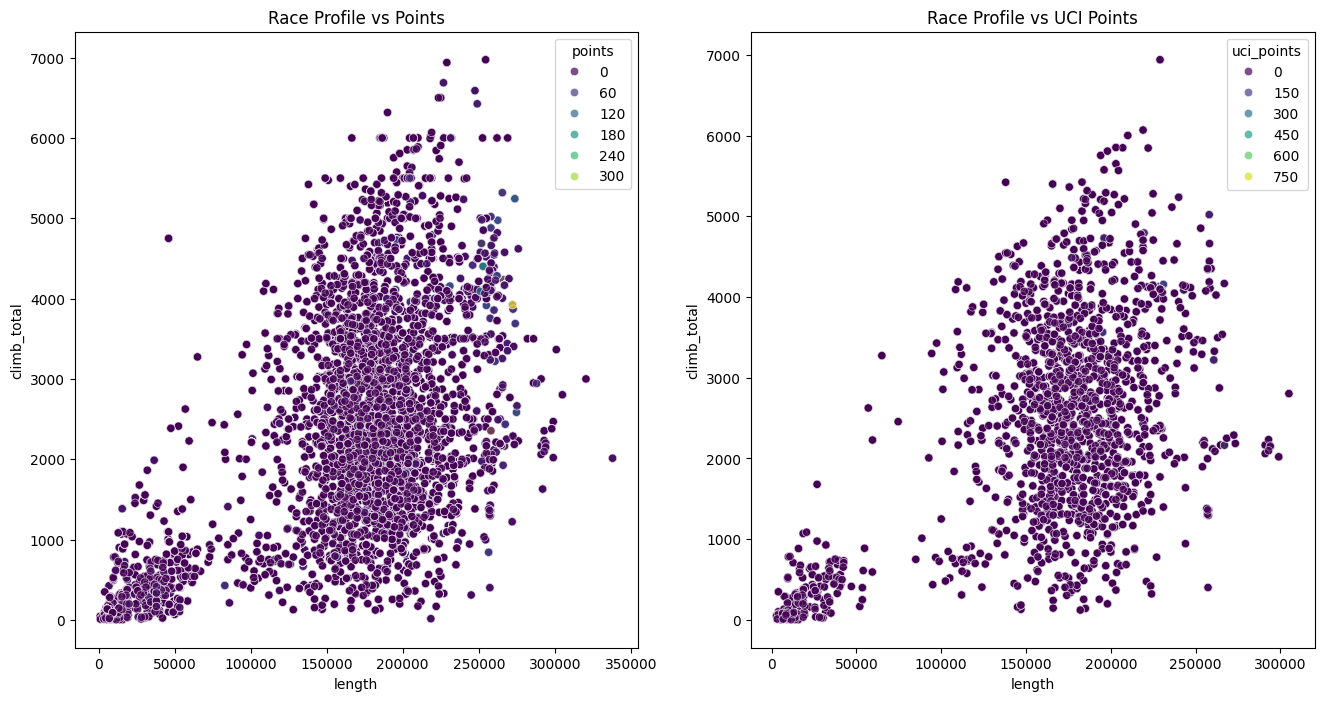

In [63]:
rppu_scat_feat = ['length', 'climb_total', 'points', 'uci_points', 'profile']
rppu_scat_df = MergedDataset[rppu_scat_feat].copy()

# 3.1 Race Profile vs Cyclist Performance
fig = plt.figure(figsize=(16, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='length', y='climb_total', hue='points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax1.set_title('Race Profile vs Points')


# 3.2 Race Profile vs Cyclist UCI Points
ax2 = fig.add_subplot(gs[0, 1])
seaborn.scatterplot(x='length', y='climb_total', hue='uci_points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax2.set_title('Race Profile vs UCI Points')


plt.show()
plt.close()
del rppu_scat_feat

We can see the correlation between `points` and `uci_points`, as the scatter plots are very similar. The only notable difference is that `uci_points` tend to have higher values. Additionally, `uci_points` are more selective, with fewer high-point races compared to the general point system. However, this might be due to the fact that we have fewer `uci_points` values.

We can observe a trend where longer races with more climbing tend to award more points. These plots show that to earn high points, cyclists need to excel in both endurance and climbing ability. Riders in very short flat races have fewer opportunities for high point gains.

#### Tarmac vs Points/UCI Points and Profiles vs Points/UCI points box plots

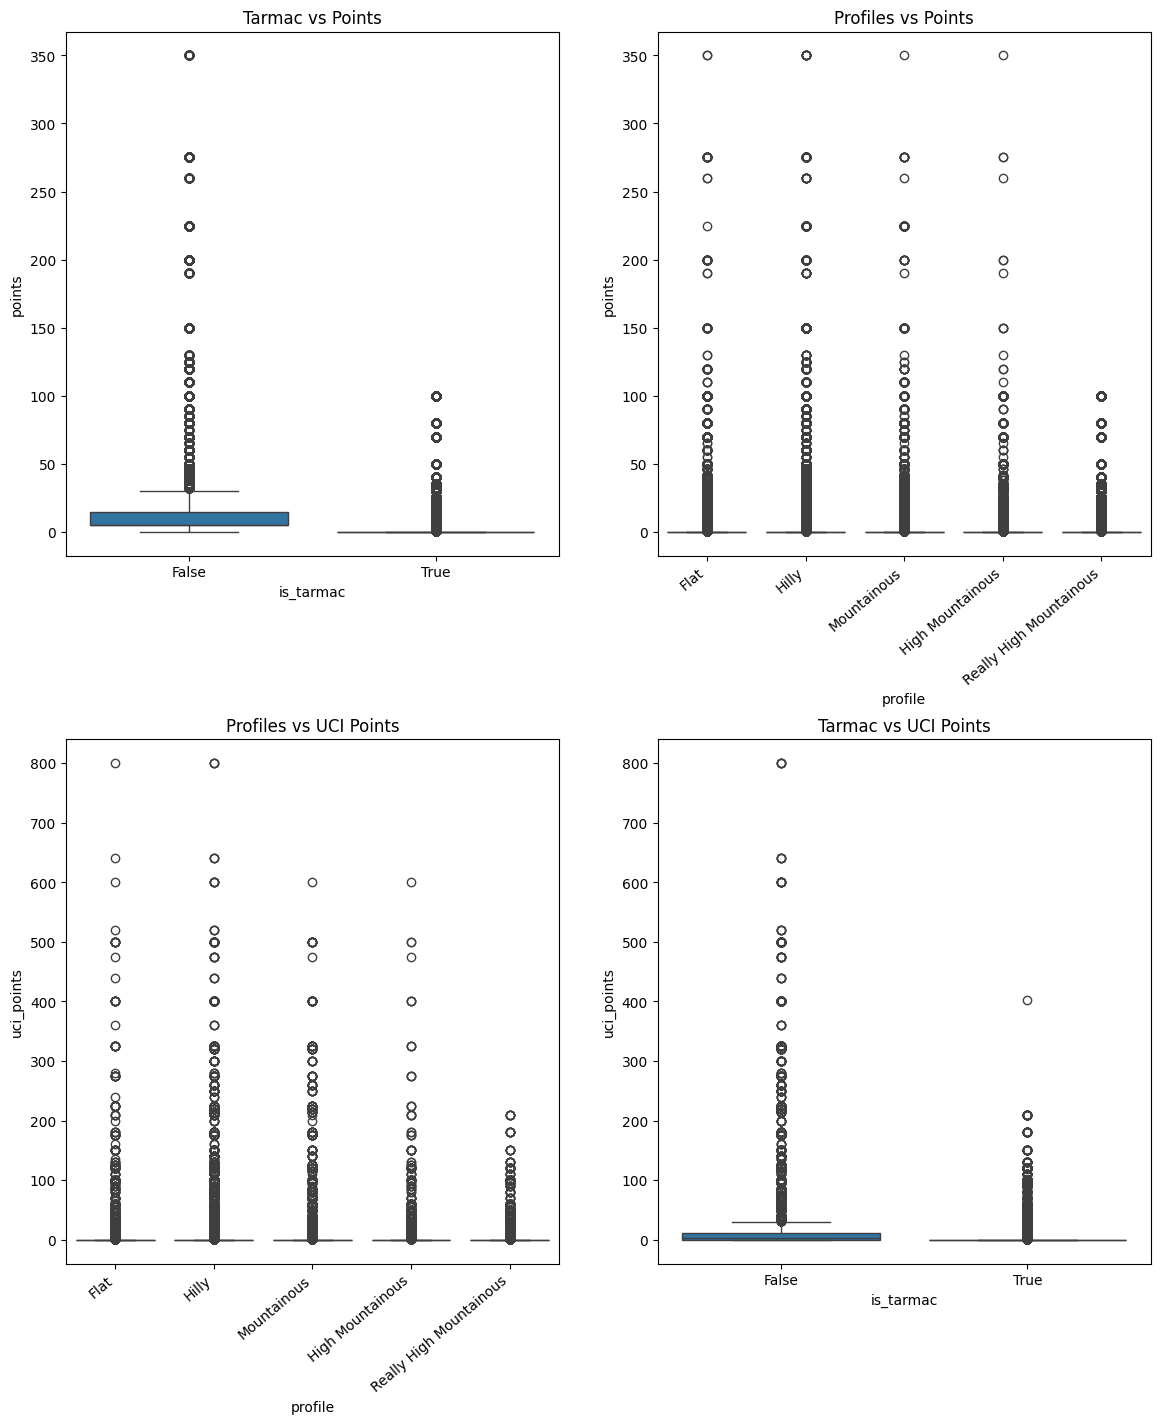

In [64]:

tpu_box_feat = ['is_tarmac', 'profile', 'points', 'uci_points']
tpu_box_dr = MergedDataset[tpu_box_feat].copy()


fig = plt.figure(figsize=(14, 16))
gs = plt.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.35)

ax1 = fig.add_subplot(gs[0, 0])
profiles = seaborn.boxplot(x='is_tarmac', y='points', data=tpu_box_dr, ax=ax1)
ax1.set_title('Tarmac vs Points')


ax2 = fig.add_subplot(gs[0, 1])
profiles = seaborn.boxplot(x='profile', y='points', data=tpu_box_dr, ax=ax2)
profiles.set_xticks(profiles.get_xticks())
profiles.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax2.set_title('Profiles vs Points')
plt.xticks(rotation=40, ha='right',horizontalalignment='right')



# 5.2 Race Surface vs Cyclist UCI Points

ax3 = fig.add_subplot(gs[1, 1])
profiles = seaborn.boxplot(x='is_tarmac', y='uci_points', data=tpu_box_dr, ax=ax3)
ax3.set_title('Tarmac vs UCI Points')

ax4 = fig.add_subplot(gs[1, 0])
profiles = seaborn.boxplot(x='profile', y='uci_points', data=tpu_box_dr, ax=ax4)
ax4.set_xticks(profiles.get_xticks())
ax4.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax4.set_title('Profiles vs UCI Points')


plt.xticks(rotation=40, ha='right',horizontalalignment='right')
# plt.tight_layout()
plt.show()
plt.close()



The analysis of box plots comparing points and UCI points across tarmac, non-tarmac, and race profiles reveals a structured scoring system that values versatility across terrains and disciplines. In both systems, non-tarmac events—likely off-road or mountain bike races—award significantly higher points, with medians around 225 and 450 for points and UCI points, respectively, compared to lower values for tarmac races. This indicates a greater emphasis on non-tarmac disciplines, potentially to encourage participation. 

Across profiles, points are fairly similar, with medians generally between 75-100 points, though flat and extreme mountainous profiles (like "Really High Mountainous") show slightly higher medians. Outliers with much higher points in each category likely represent prestigious events, such as key stages in Grand Tours or significant classics. 

The variability within profiles, especially in hilly and mountainous categories, suggests a range of race difficulties. Flat races, although often standardized, still hold a respectable median value, while high mountainous profiles don’t always award the highest average points, yet include notable outliers. The scoring structure encourages cyclists to compete across various race types, with specialization still possible in specific profiles or terrains. 

For the UCI points specifically, the balanced distribution across race profiles on tarmac suggests an effort to value different road racing profiles equally, while the prominent role of non-tarmac events highlights a focus on promoting diverse cycling disciplines. Overall, both systems seem aimed at fostering well-rounded cyclists capable of excelling across different terrains, while also highlighting prestigious events within each category.

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **race**:

- 

# **Data transformation**

## Dataset cyclists

### Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [65]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

/tmp/ipykernel_776275/56667317.py:18: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



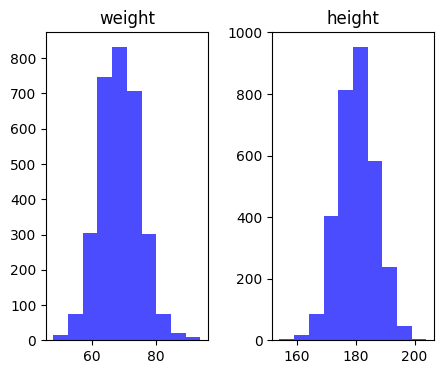

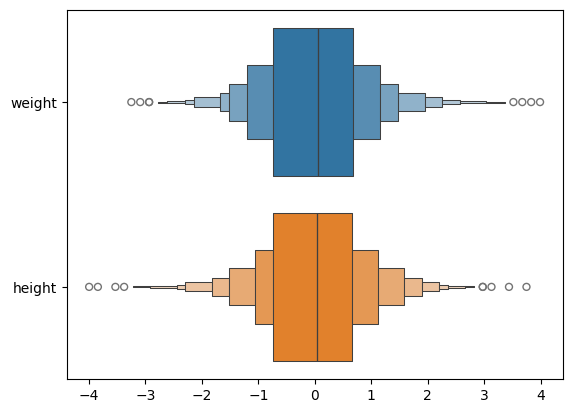

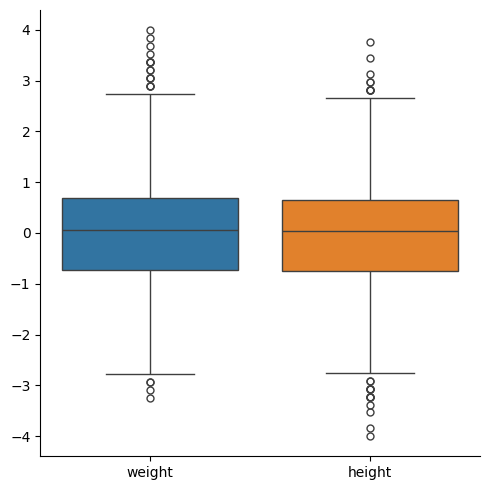

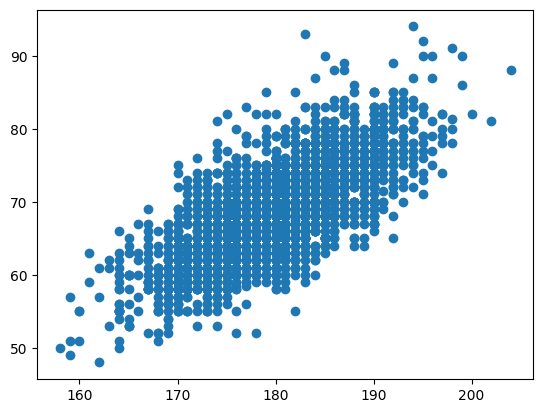

In [66]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [67]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = stats.multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

/tmp/ipykernel_776275/56667317.py:18: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



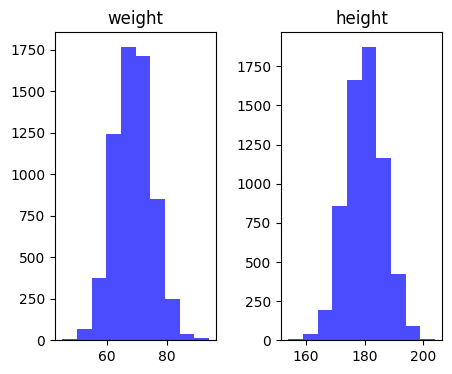

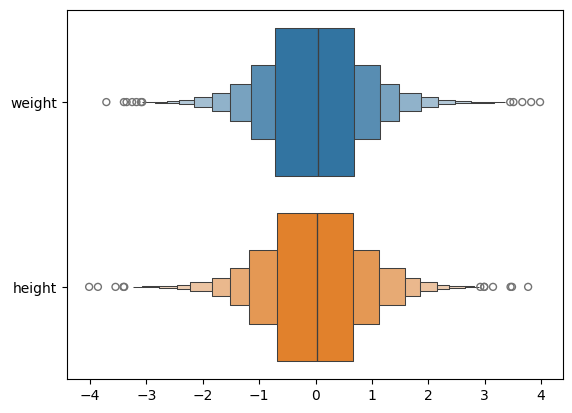

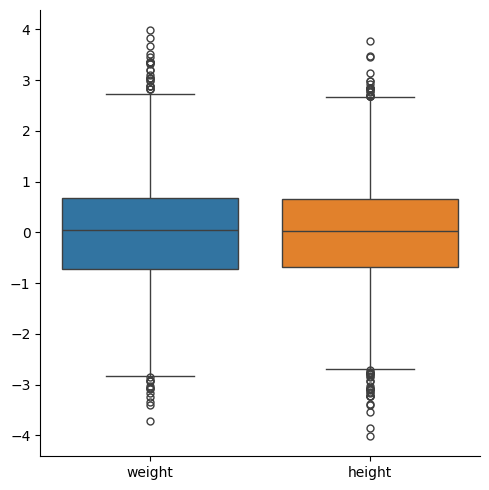

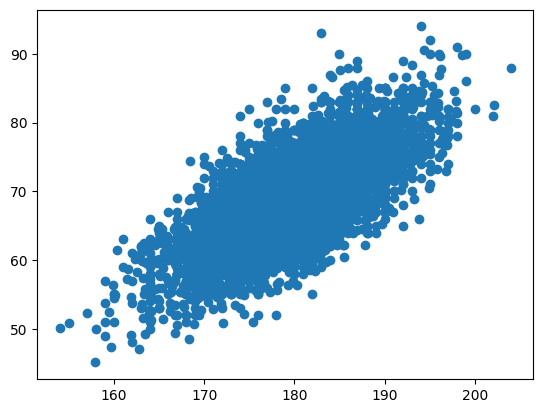

In [68]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti.

### Fill data of birth_year column (Riccardo)

In [71]:
DatasetRace[DatasetRace['cyclist'] == 'aaron-kemps']

_url                        name  points  \
21068      volta-a-catalunya/2006/stage-6  Volta Ciclista a Catalunya       0   
36663      volta-a-catalunya/2005/stage-4  Volta Ciclista a Catalunya       0   
89896      volta-a-catalunya/2005/stage-5  Volta Ciclista a Catalunya       0   
93394             paris-nice/2005/stage-1                Paris - Nice       0   
99815            paris-nice/2005/prologue                Paris - Nice       0   
...                                   ...                         ...     ...   
545271  omloop-het-nieuwsblad/2008/result          Omloop Het Volk ME       0   
559782            paris-nice/2007/stage-2                Paris - Nice       0   
575051          paris-roubaix/2006/result             Paris - Roubaix       5   
576970      vuelta-a-espana/2006/stage-18             Vuelta a España       0   
589444      vuelta-a-espana/2006/stage-19             Vuelta a España       0   

        uci_points    length  climb_total  profile  startlist_quality  \
21068          NaN  166400.0          NaN      2.0                882   
36663          NaN  237700.0          NaN      5.0                850   
89896          NaN   17100.0          NaN      5.0                850   
93394          NaN  186500.0          NaN      1.0               1091   
99815          NaN    4000.0          NaN      1.0               1091   
...            ...       ...          ...      ...                ...   
545271         NaN  199000.0          NaN      2.0                627   
559782         NaN  177000.0          NaN      3.0                823   
575051         NaN  259000.0          NaN      1.0                641   
576970         NaN  153000.0       2987.0      5.0               1026   
589444         NaN  205300.0       2998.0      1.0               1026   

        average_temperature                 date  position      cyclist  \
21068                   NaN  2006-05-20 04:02:01       138  aaron-kemps   
36663                   NaN  2005-05-19 06:22:09       116  aaron-kemps   
89896                   NaN  2005-05-20 00:37:18       143  aaron-kemps   
93394                   NaN  2005-03-07 04:19:15        25  aaron-kemps   
99815                   NaN  2005-03-06 00:05:15        77  aaron-kemps   
...                     ...                  ...       ...          ...   
545271                  NaN  2008-03-01 04:55:25       130  aaron-kemps   
559782                  NaN  2007-03-13 03:57:36        62  aaron-kemps   
575051                  NaN  2006-04-09 06:07:54        79  aaron-kemps   
576970                  NaN  2006-09-14 03:57:39       102  aaron-kemps   
589444                  NaN  2006-09-15 05:30:14       105  aaron-kemps   

        cyclist_age  is_tarmac  is_cobbled  is_gravel  \
21068            22       True       False      False   
36663            21       True       False      False   
89896            21       True       False      False   
93394            21       True       False      False   
99815            21       True       False      False   
...             ...        ...         ...        ...   
545271           24      False       False      False   
559782           23       True       False      False   
575051           22      False       False      False   
576970           23       True       False      False   
589444           23       True       False      False   

                        cyclist_team   delta  
21068        Liberty Seguros - Würth   827.0  
36663   Liberty Seguros - Würth Team  1320.0  
89896   Liberty Seguros - Würth Team   428.0  
93394   Liberty Seguros - Würth Team    41.0  
99815   Liberty Seguros - Würth Team    17.0  
...                              ...     ...  
545271                        Astana  1099.0  
559782                        Astana    19.0  
575051       Liberty Seguros - Würth  1160.0  
576970                        Astana  1330.0  
589444                        Astana   676.0  

[61 rows x 18 columns]

In [ ]:
PreProcessing = DatasetRace.dropna(subset=["cyclist", "date", "cyclist_age"])

PreparedDatasetRace = pd.DataFrame({
    'name': PreProcessing["cyclist"],
    'date': list(map(lambda x, y: float(x.split("-")[0]) - y, PreProcessing["date"], PreProcessing["cyclist_age"]))
})

#Serve per vedere se per ogni ciclista ci sono più date di nascita calcolate, se si c'è un problema
GroupByCyclist = PreparedDatasetRace.groupby("name")
Counts = GroupByCyclist["date"].nunique()
# Modificato: Il ciclista può avere più date di nascita calcolate se ha partecipato a più gare in un anno 
# (massimo 2 date, e differenza in valore assoluto tra le date delle gare minore di 2)
for name in Counts.keys():
    if Counts[name] != 1:
        cyclist_dates = GroupByCyclist.get_group(name)['date'].unique()
        len_dates = len(cyclist_dates)
        if len_dates > 2 or (len_dates == 2 and np.abs(cyclist_dates[0] - cyclist_dates[1]) >  1):
            print(f"Risulta che l' atleta {name} non abbia una sola data ma: [{', '.join(map(str, cyclist_dates))}]")

Non si sono presentati problemi, per ogni atleta si è calcolata una sola data di nascita considerando tutte le sue corse, quindi i dati interessati (date e cyclist_age) non sono sbagliati. Ora si usano questi dati per metterli dentro le date di nascita del dataset cyclists.

In [86]:
Association = {name: date for date, name in zip(GroupByCyclist["date"].mean(), Counts.keys())}

DatasetCyclists["birth_year"] = DatasetCyclists["birth_year"].fillna(DatasetCyclists["_url"].map(Association))

print(f"Ciclisti con anno di nascita disponibile dentro la ricerca: {len(list(set(Association.keys()).intersection(set(DatasetCyclists.dropna(subset=['birth_year'])['_url']))))}")

Ciclisti con anno di nascita disponibile dentro la ricerca: 6284


La ricerca non è servita a niente per riempire i valori mancanti (ma è servita per ricalcolare tutte le date di nascite giuste, visto che sono tutte del 1970), perchè tutti i ciclisti di cui si è calcolate le età già avevano l' eta disponibile, quindi si prova con la ricerca su google

In [87]:
DatasetCyclists.loc[DatasetCyclists["_url"] == "scott-davies", "birth_year"] = 1995
DatasetCyclists.loc[DatasetCyclists["_url"] == "vladimir-malakov", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "antonio-zanini", "birth_year"] = 1965
DatasetCyclists.loc[DatasetCyclists["_url"] == "filippo-simonetti", "birth_year"] = 1971
DatasetCyclists.loc[DatasetCyclists["_url"] == "carlos-garcia", "birth_year"] = 1964
DatasetCyclists.loc[DatasetCyclists["_url"] == "alexandr-osipov", "birth_year"] = 1961
DatasetCyclists.loc[DatasetCyclists["_url"] == "nicolai-kosyakov", "birth_year"] = 1960
DatasetCyclists.loc[DatasetCyclists["_url"] == "nevens-guy", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "oscar-pumar", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "javier-luquin", "birth_year"] = 1963
DatasetCyclists.loc[DatasetCyclists["_url"] == "thierry-lauder", "birth_year"] = 1974
DatasetCyclists.loc[DatasetCyclists["_url"] == "batik-odriozola", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "sergei-jermachenko", "birth_year"] = 1961

### View final dataset cleaned

              Total values  Missing values  Usable values
Elements                                                 
_url                  6324               0           6324
name                  6324               0           6324
birth_year            6324               0           6324
weight                6324               0           6324
height                6324               0           6324
nationality           6324               0           6324
expected_url          6324               0           6324


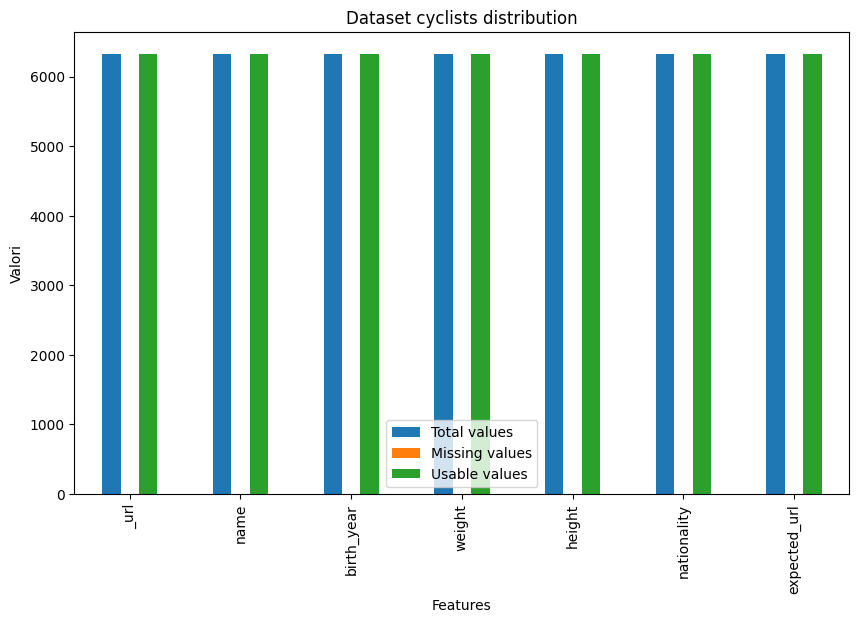

In [88]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

## Dataset race



### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [89]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Replace `nan` values of cyclists_age column (Riccardo)

In [90]:
DatasetRace['date'] = pd.to_datetime(DatasetRace['date'])
DatasetRace['race_year'] = DatasetRace['date'].dt.year

MergedDataset = DatasetRace.merge(DatasetCyclists[['_url', 'birth_year']], left_on='cyclist', right_on='_url', how='left')
MergedDataset['aged_at_race'] = MergedDataset['race_year'] - MergedDataset['birth_year']

DatasetRace['cyclist_age'] = MergedDataset['aged_at_race']



### Fill data of cyclists_team columns

In [56]:
for name in set(DatasetRace["cyclist"]):
    TotalDifferentTeams = len(set(DatasetRace[DatasetRace['cyclist'] == name]['cyclist_team']))
    
    
    print(f"Cyclist {name} è stato in {TotalDifferentTeams} team diversi")
    
    if(TotalDifferentTeams > 1): break

Cyclist alexander-edmondson è stato in 7 team diversi


In [114]:
DatasetRace[DatasetRace['delta'] < 0]

_url             name  points  uci_points  \
72072   vuelta-a-espana/1992/stage-19  Vuelta a España       5         NaN   
72073   vuelta-a-espana/1992/stage-19  Vuelta a España       4         NaN   
72074   vuelta-a-espana/1992/stage-19  Vuelta a España       3         NaN   
72075   vuelta-a-espana/1992/stage-19  Vuelta a España       2         NaN   
72076   vuelta-a-espana/1992/stage-19  Vuelta a España       1         NaN   
...                               ...              ...     ...         ...   
232883       paris-nice/1990/stage-7a     Paris - Nice       4         NaN   
232884       paris-nice/1990/stage-7a     Paris - Nice       3         NaN   
232885       paris-nice/1990/stage-7a     Paris - Nice       2         NaN   
232886       paris-nice/1990/stage-7a     Paris - Nice       1         NaN   
527809    tour-de-suisse/1993/stage-4   Tour de Suisse      30         NaN   

          length  climb_total  profile  startlist_quality                date  \
72072    37900.0        294.0      NaN               1033 1992-05-15 00:46:18   
72073    37900.0        294.0      NaN               1033 1992-05-15 00:46:18   
72074    37900.0        294.0      NaN               1033 1992-05-15 00:46:18   
72075    37900.0        294.0      NaN               1033 1992-05-15 00:46:18   
72076    37900.0        294.0      NaN               1033 1992-05-15 00:46:18   
...          ...          ...      ...                ...                 ...   
232883  102000.0          NaN      NaN                995 1990-03-11 02:27:45   
232884  102000.0          NaN      NaN                995 1990-03-11 02:27:45   
232885  102000.0          NaN      NaN                995 1990-03-11 02:27:45   
232886  102000.0          NaN      NaN                995 1990-03-11 02:27:45   
527809  212300.0          NaN      NaN                655 1993-06-18 00:02:25   

        position                   cyclist  cyclist_age  is_tarmac  \
72072         11            johan-bruyneel         28.0       True   
72073         12               raul-alcala         28.0       True   
72074         13         joachim-halupczok         24.0       True   
72075         14  djamolidine-abduzhaparov         28.0       True   
72076         15            guido-bontempi         32.0       True   
...          ...                       ...          ...        ...   
232883         7            francis-moreau         25.0       True   
232884         8          laurent-jalabert         22.0       True   
232885         9        claudio-chiappucci         27.0       True   
232886        10       jean-claude-colotti         29.0       True   
527809         2            marco-saligari         28.0       True   

        is_cobbled  is_gravel              cyclist_team   delta  race_year  
72072        False      False   O.N.C.E. - Look - Mavic -2635.0       1992  
72073        False      False   PDM - Ultima - Concorde -2638.0       1992  
72074        False      False          GB-MG Maglificio -2541.0       1992  
72075        False      False  Carrera Jeans - Vagabond -2542.0       1992  
72076        False      False  Carrera Jeans - Vagabond -2545.0       1992  
...            ...        ...                       ...     ...        ...  
232883       False      False            Histor - Sigma -5562.0       1990  
232884       False      False                   Toshiba -5562.0       1990  
232885       False      False  Carrera Jeans - Vagabond -5562.0       1990  
232886       False      False     RMO - Mavic - Liberia -6906.0       1990  
527809       False      False                  Ariostea  -106.0       1993  

[86 rows x 18 columns]

Questa colonna non verrà riempita, perchè qualche ciclista non sta nella stessa squadra in ogni gara.

### Replace `nan` values of `delta`, `climb_total`, `profile` and `uci_points`  columns (Oleskiy)

#### Introduction

* Our approach to filling the `nan` data involved comparing three possible methods. The first was to implement an algorithm that runs multiple regressors, both linear and non-linear, and selects the best one based on specified metrics. 

* The second was to cluster the the races based on features most correlated with the predicted column, fit multiple probability distribution  (e.g., `stats.gamma`. `stats.lognorm`), and select the optimal one based on  `kstest` + `momemtum_score` + `density_score` overall metric. 
  
* The third and final method was to fit a `KNNImputer`. 

To predicte the  `climb_total`, `profile` was used the first approach, since it it the most flexible, since it gave different best regressor, based on `RMSE` metric.

What follows is the code of the three methods. But before, we need to preper the dataframe.

#### Regressors comparing algorithm

This code compares and evaluates multiple machine learning regression models (including Random Forest, XGBoost, Linear Regression, etc.) for predicting a specific feature. It:

- Takes a dataset and trains multiple regression models
- Evaluates each model using metrics (RMSE, R², cross-validation)
- Creates visualizations comparing model performance
- Generates residual plots for the best performing model
- Returns the trained models, performance summary, and predictions for missing values

It's essentially a model evaluation and selection pipeline that helps identify the best regression model for a specific prediction task.

#### Density based approach

This code compares different fitted distribution on a cluster of similar points, e.g. `stats.burr`, `stats.gaussian_mix`, and choose the best one based on the weighted sum of scores (see [densities_based.py:125](data_pred_code/densities_based.py)).

- Segments data into clusters based on similar features
- Fits statistical distributions to each segment
- Predicts missing values using the best-fitted distributions
- Provides confidence scores for predictions

It's essentially fits a statistical distribution for each cluster of points obtained with `KMeans`.

#### K-Nearest Neighbor imputation approach


- Takes a dataframe, feature definitions, and a target feature to predict
- Uses KNN imputation to fill in missing values by finding similar data points
- If requested, calculates prediction accuracy metrics (RMSE, R², MAE, MSE)
- Creates error visualizations

It's essentially a specialized imputation function that uses KNN to fill missing values by looking at similar samples in the dataset, with built-in error checking and performance validation.


#### Relevant features picking

We notice that the regressors perform better if we add derived features

In [57]:
def engineering_features_t1(df) -> tuple[pd.DataFrame, dict]:
    
    engineered_features = {
        'points_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season_score': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season': {
            'type': 'categorical',
            'agg': pd.Series.mode
        },
        'team_presents': {
            'type': 'numeric',
            'agg': pd.Series.sum
        },
        'adjusted_delta': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },

        'startlist_score_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        }
    }
            
    # Process date features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear

    # Calculate derived features
    df['points_per_km'] = (df['points'] / df['length']* 0.001).fillna(0)


    # Create seasonal feature
    df['season_score'] = np.sin(2 * np.pi * df['day_of_year'] / 365)

    temp = df['month'].apply(lambda x: 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' if x in [9, 10, 11] else 'winter')
    label_enc = LabelEncoder().fit_transform(temp.to_numpy())
    df['season'] = pd.Series(label_enc, index=df.index)
    df['team_presents'] = df['cyclist_team'].notnull().astype(int)
    df['startlist_score_per_km'] = df['startlist_quality'] / df['length']

    df['adjusted_delta'] = df['delta'] / df['length']

    return df, engineered_features


In [58]:
# Define features with their properties and aggregation methods
normal_features = {
    'length': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'points': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'startlist_quality': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'is_tarmac': {
        'type': 'boolean',
        'agg': 'first'
    },
    'profile': {
        'type': 'categorical',
        'agg': pd.Series.mode
    },
    'position': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'cyclist_age': {
        'type': 'numeric',
        'agg': pd.Series.median
    }
    
}

DatasetRace_temp = DatasetRace[list(normal_features.keys()) + ['climb_total', 'date', 'cyclist', 'cyclist_team', 'delta', '_url']].copy()


preprocess_helper_imputer(DatasetRace_temp, normal_features)
_, engineered_features = engineering_features_t1(DatasetRace_temp)


FEATURES = {**normal_features, **engineered_features}
preprocess_helper_scaler(DatasetRace_temp, FEATURES)


# Generate pred_features dictionary
pred_features = {name: {'type': props['type']} for name, props in FEATURES.items()}

# Generate aggregation dictionary
agg_dict = {name: props['agg'] for name, props in FEATURES.items()}
agg_dict['climb_total'] = pd.Series.mean
agg_dict['date'] = 'first'

# Perform groupby with generated aggregation dictionary
GroupedRaces = DatasetRace_temp.groupby(["_url"]).agg(agg_dict)

GroupedRaces.sample(frac=0.4).head(5)


length    points  startlist_quality  \
_url                                                                  
dauphine/1990/stage-4         0.251139  0.667758          -1.218236   
tour-de-france/2012/stage-11 -0.291024 -0.069290           1.582535   
giro-d-italia/2001/stage-15  -1.723884 -0.112332          -0.474692   
giro-d-italia/2018/stage-5   -0.213572 -0.130283          -0.690136   
giro-d-italia/2009/stage-15  -0.120630 -0.132419          -0.330187   

                              is_tarmac  profile  position  cyclist_age  \
_url                                                                      
dauphine/1990/stage-4               1.0      5.0 -1.442205    -0.124186   
tour-de-france/2012/stage-11        1.0      4.0  0.138770     0.394493   
giro-d-italia/2001/stage-15         1.0      0.0 -0.035506    -0.124186   
giro-d-italia/2018/stage-5          1.0      2.0  0.240861     0.135153   
giro-d-italia/2009/stage-15         1.0      1.0  0.236869    -0.124186   

                              points_per_km  season_score  season  \
_url                                                                
dauphine/1990/stage-4              0.111419      0.431042       2   
tour-de-france/2012/stage-11      -0.054501     -0.568691       2   
giro-d-italia/2001/stage-15       -0.006992      0.408919       2   
giro-d-italia/2018/stage-5        -0.073440      0.884706       1   
giro-d-italia/2009/stage-15       -0.075149      0.619897       1   

                              team_presents  adjusted_delta  \
_url                                                          
dauphine/1990/stage-4             -7.422091       -0.346846   
tour-de-france/2012/stage-11      69.766369        0.697843   
giro-d-italia/2001/stage-15     -100.257016        0.577694   
giro-d-italia/2018/stage-5        86.076998       -0.177207   
giro-d-italia/2009/stage-15       37.394141        0.397891   

                              startlist_score_per_km  climb_total  \
_url                                                                
dauphine/1990/stage-4                      -0.306015          NaN   
tour-de-france/2012/stage-11               -0.109670       4987.0   
giro-d-italia/2001/stage-15                 0.014358        540.0   
giro-d-italia/2018/stage-5                 -0.257179       2237.0   
giro-d-italia/2009/stage-15                -0.241156       3104.0   

                                            date  
_url                                              
dauphine/1990/stage-4        1990-06-02 04:38:05  
tour-de-france/2012/stage-11 2012-07-12 04:43:54  
giro-d-italia/2001/stage-15  2001-06-03 01:11:35  
giro-d-italia/2018/stage-5   2018-05-09 04:06:33  
giro-d-italia/2009/stage-15  2009-05-24 04:19:28

#### Predicting  `climb_total` `nan` values

##### Using Regressors


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


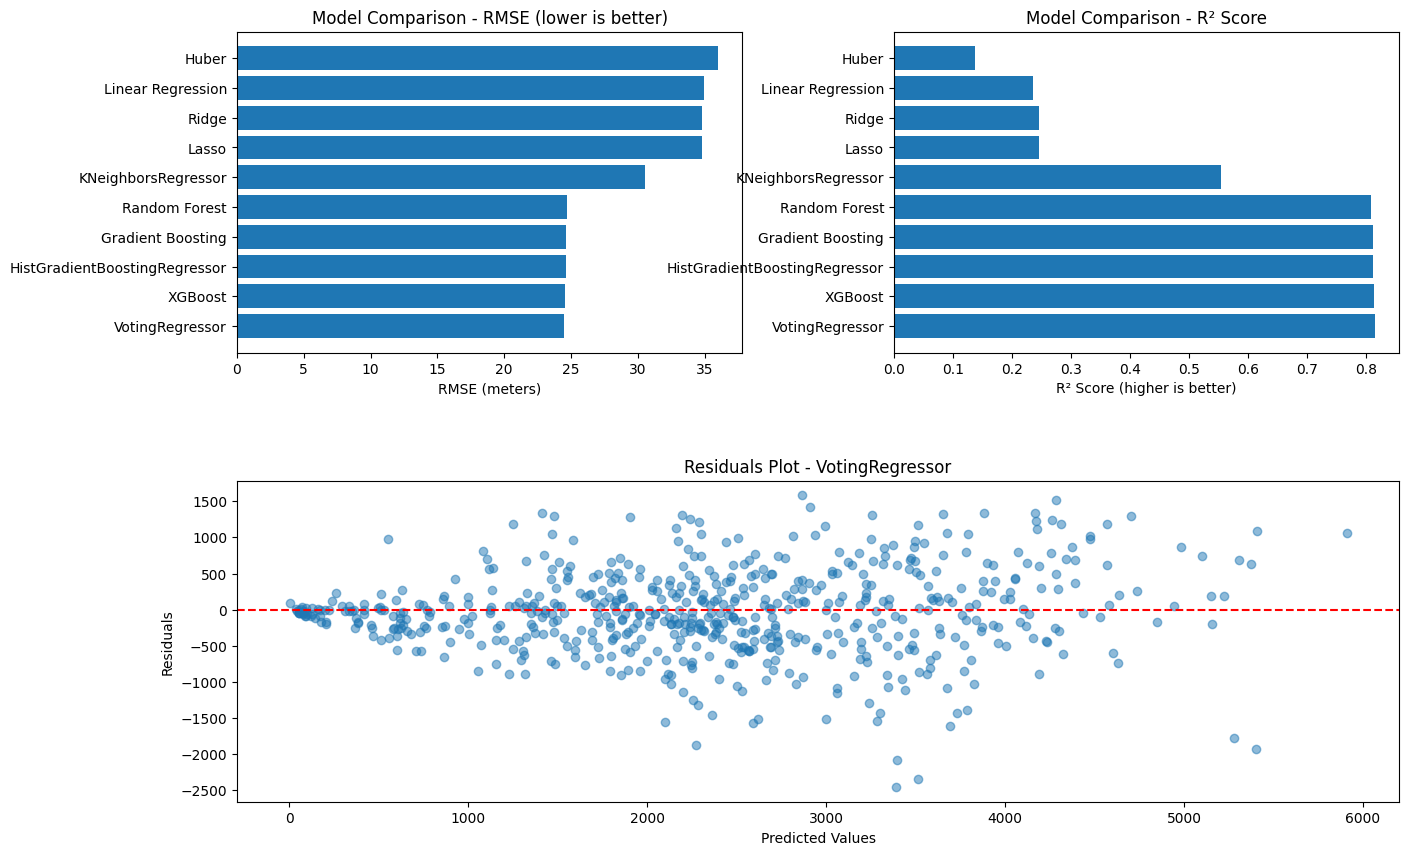


Summary of all models:
                                    RMSE        R²      CV RMSE  CV RMSE Std
VotingRegressor                24.466891  0.816046   697.341130    72.082232
XGBoost                        24.553091  0.813440   710.236327    80.718121
HistGradientBoostingRegressor  24.590373  0.812304   698.350106    69.816314
Gradient Boosting              24.619167  0.811423   706.073832    67.669959
Random Forest                  24.719130  0.808342   721.594140    67.087254
KNeighborsRegressor            30.522219  0.554488  1072.972486   116.156598
Lasso                          34.810356  0.246247  1086.617898   175.371586
Ridge                          34.817578  0.245622  1088.229911   180.434816
Linear Regression              34.927180  0.236078  1090.857811   184.174589
Huber                          36.007754  0.137063  1047.276904   184.680354
Visualizations for the best model:


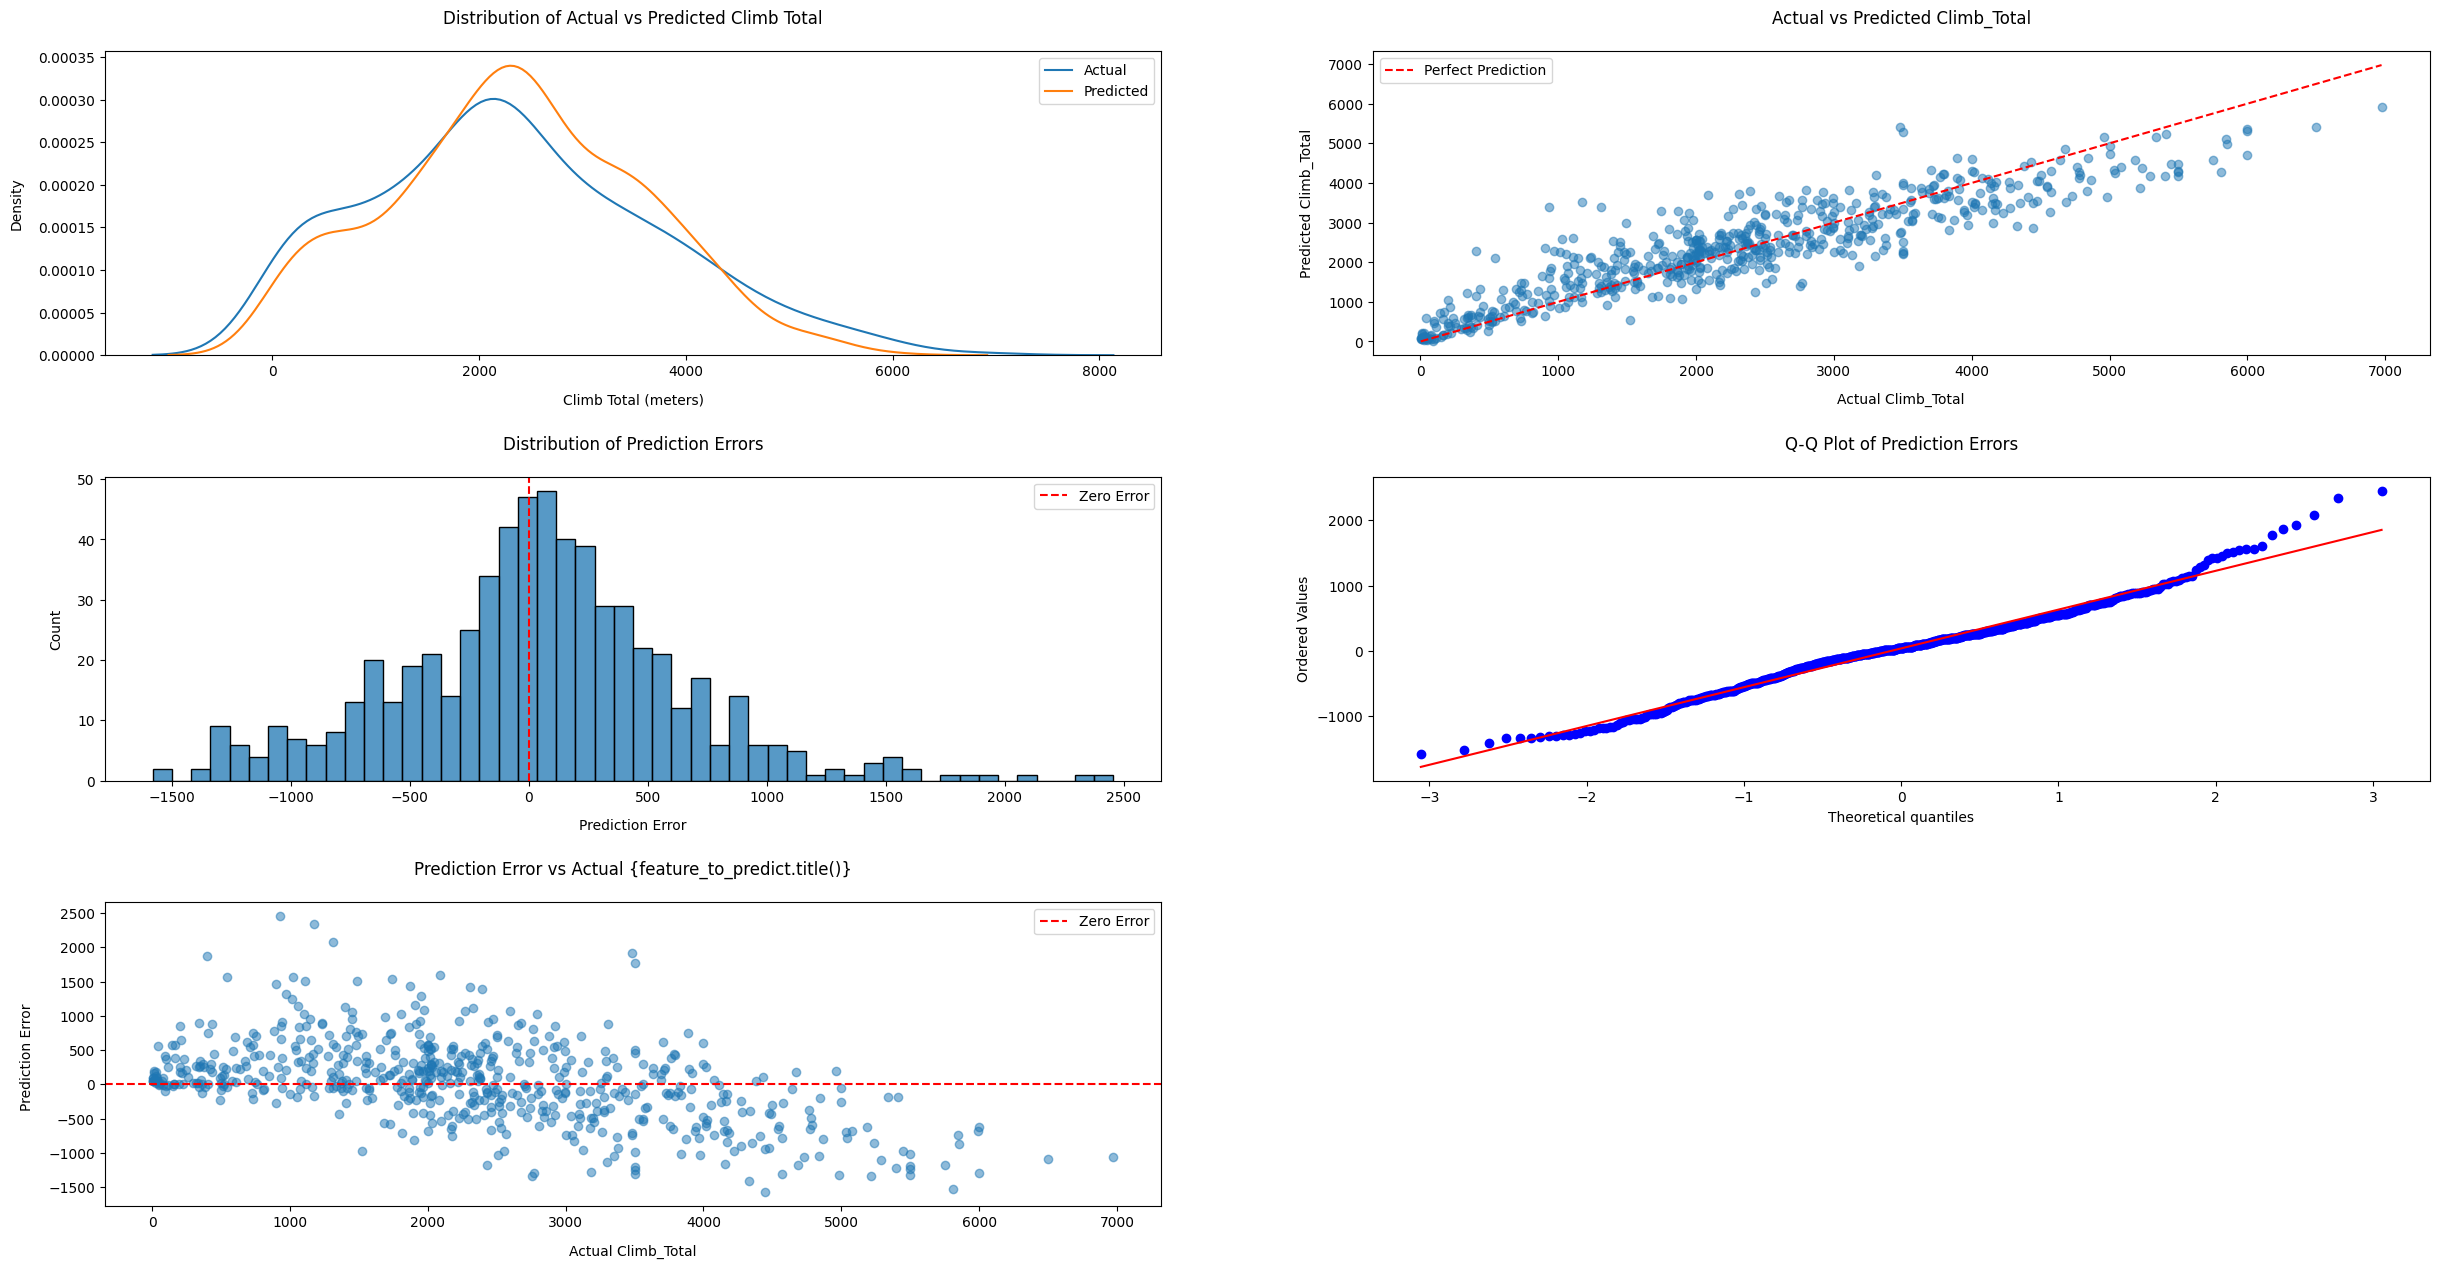

In [59]:
results, summary, climb_total_pred = compare_regressors(GroupedRaces, "climb_total", features=pred_features)

##### Using Segmentation and Density Approach

Now we will execute the above segmentation and density approach code to predict the missing values in the dataset. Since the engineered features don't provide extra information, we don't use them with the density based approach.



 Feature statistics before imputation:
length: 0 missing (0.00%)
points: 0 missing (0.00%)
startlist_quality: 0 missing (0.00%)
profile: 0 missing (0.00%)
position: 0 missing (0.00%)
cyclist_age: 0 missing (0.00%)


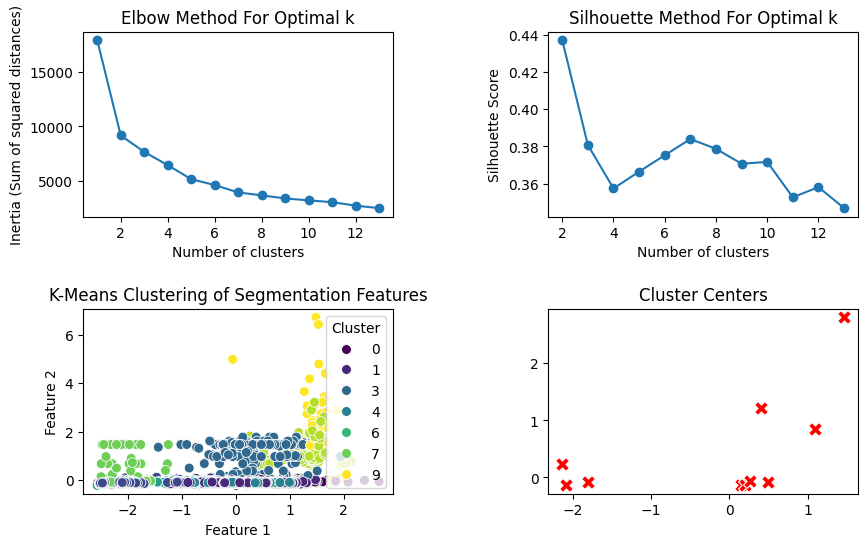

number of segments: 133


Fitting distributions: 100%|██████████| 33/33 [00:01<00:00, 16.90it/s]
/home/lesi-nedo/miniforge3/envs/DM/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



number of chunks: 766


100%|██████████| 3066/3066 [00:00<00:00, 104988.58it/s]



Metrics:
RMSE: 32.02 meters
R²: 0.401
MAE: 798.72 meters
MSE: 1024.98
Length true data: 613
Length predicted data: 613
Mean true data: 2438.611745513866
Mean predicted data: 2428.866231647635
STD of true data: 1325.539926738594
STD of predicted data: 1040.385836100791


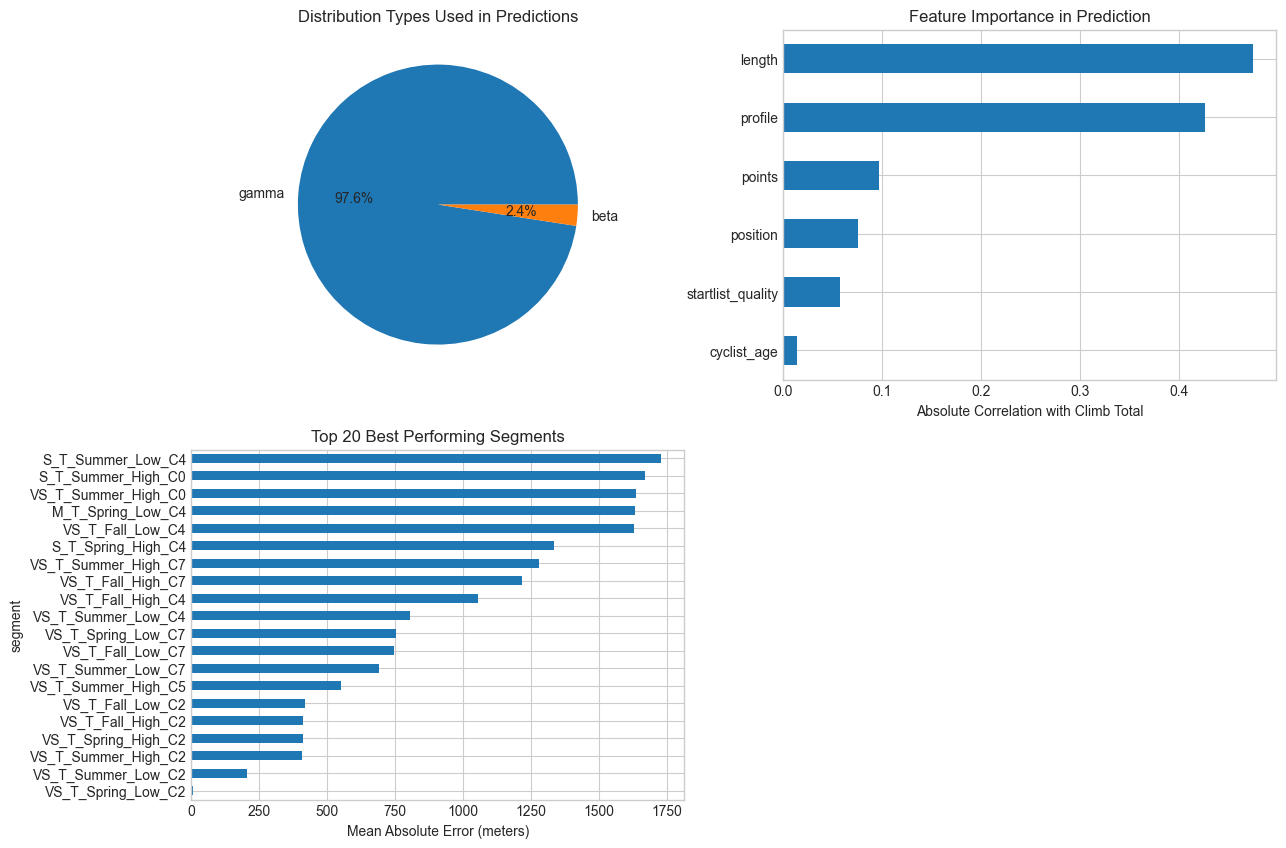

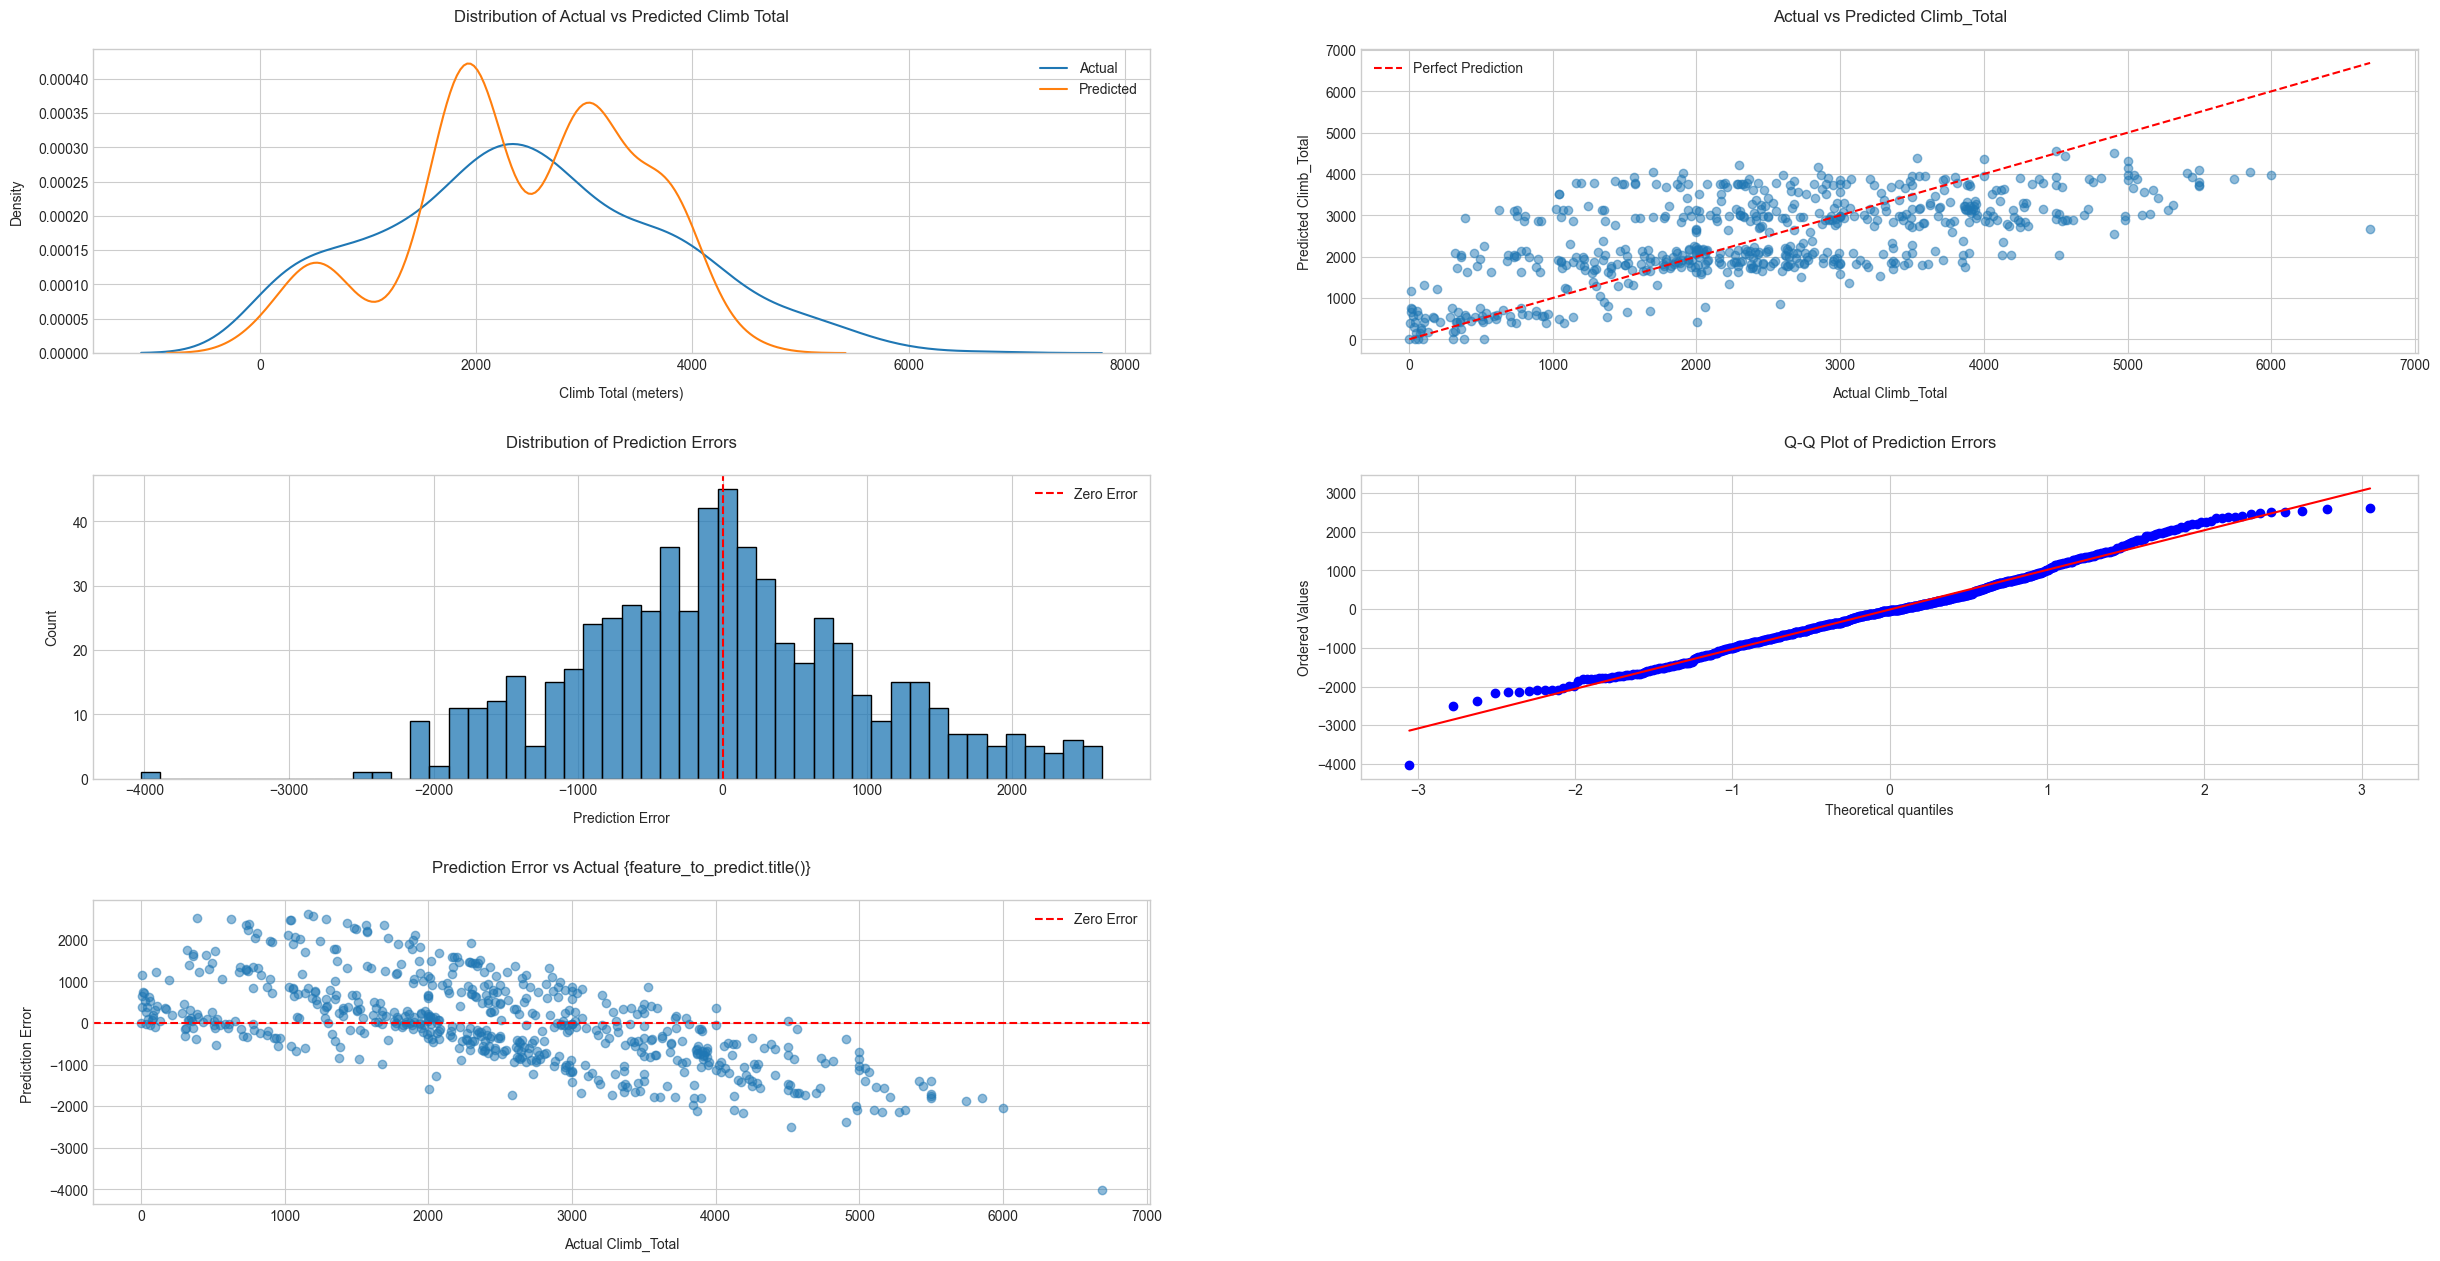

In [60]:
df_test = GroupedRaces[GroupedRaces['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']
df_test.loc[random_indices, 'climb_total'] = np.nan


local_normal_features = normal_features.copy()
# del local_normal_features['points']
# del local_normal_features['cyclist_age']
# del local_normal_features['startlist_quality']
# del local_normal_features['position']
# del local_normal_features['profile']
del local_normal_features['is_tarmac']



predictions, stats_races = predict_feature_density(
    df_test, segmentation_features=local_normal_features, n_clusters_final=2, feature_to_predict='climb_total'
)


print_density_info(stats_races, predictions, y_test, 'climb_total')
create_prediction_visualizations(predictions, y_test, stats_races, feature_name="climb_total")


del df_test

##### Using KNNImputer.


INFO:data_pred_code.KNNImputer_based:Starting prediction process...
INFO:data_pred_code.KNNImputer_based:Applying KNN imputation...
INFO:data_pred_code.KNNImputer_based:Calculating validation metrics...
INFO:data_pred_code.KNNImputer_based:y_pred shape: (613,), y_true shape: (613,)
INFO:data_pred_code.KNNImputer_based:Validation metrics: RMSE=28.01, R2=0.71



Metrics:
MSE: 784.44
RMSE: 28.01
MAE: 588.82
R2: 0.71
SAMPLES_USED: 613


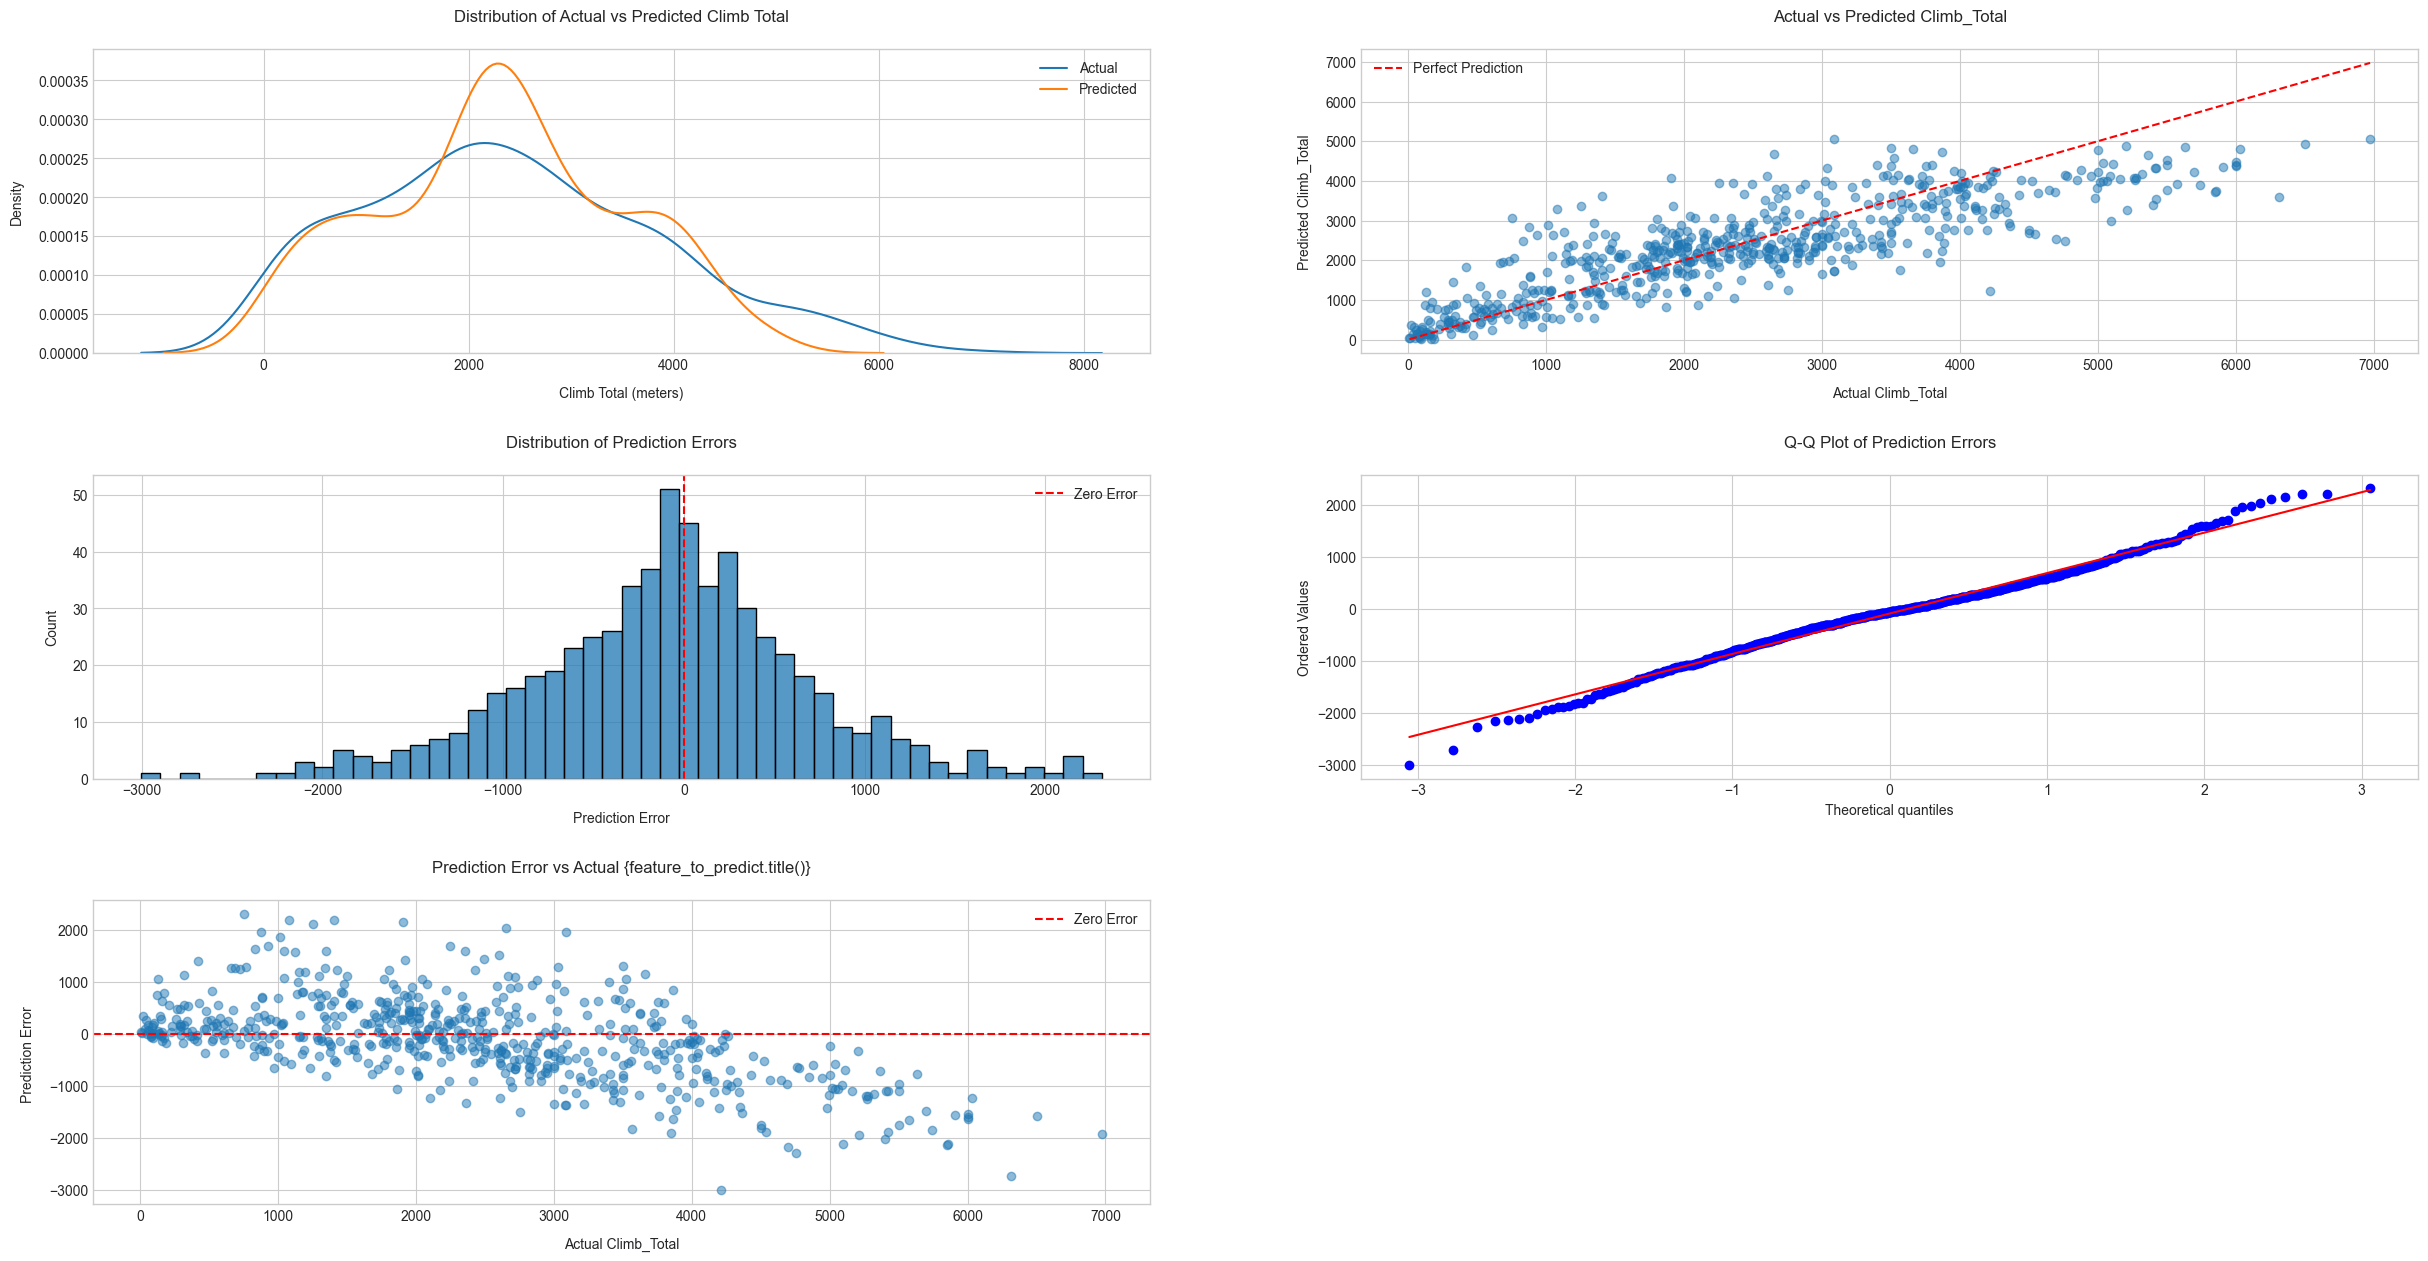

In [61]:

df_test = GroupedRaces[GroupedRaces['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']

df_test.loc[random_indices, 'climb_total'] = np.nan
local_pred_features = normal_features.copy()
# del local_pred_features['points']


metrics = predict_feature_knnimp(df_test, n_neighbors=7, feature_to_predict='climb_total', type='numeric', y_true=y_test, features=local_pred_features)

metrics

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")

del df_test

##### Conclusion on  `climb_total` `nan` values prediction 

Based on the comparison between the `RMSE` and `R²` values of the previous approaches, we decide to use the Voting Regressor to fill the missing values in `climb_total`.

In [62]:
climb_total_pred_v1 = climb_total_pred.apply(lambda x: round(x, 0))

temp_obj = DatasetRace.loc[DatasetRace['climb_total'].isna(), '_url'].map(climb_total_pred_v1)

# Update the 'climb_total' column in races_v1 only for NaN entries
DatasetRace.loc[temp_obj.index, 'climb_total'] = temp_obj
print(f"Number of missing values in climb_total: {DatasetRace['climb_total'].isna().sum()}")

Number of missing values in climb_total: 0


#### Predicting `profile` `nan` values

Since the best approach for predicting the `profile` NaN values was the regressors comparing approach, we will only show the results of running the `compare_regressor` algorithm and skip the other two. For more in depth analysis, refer to the file [OleksiyDataTrans.ipynb](extra_notebooks/OleksiyDataTrans.ipynb).


##### Dataset preparation

In [63]:
DatasetRace_profile = DatasetRace_temp.drop(columns=['profile']).copy()

# Update the 'climb_total' column with true values and predicted values for NaN entries
DatasetRace_profile['climb_total'] = DatasetRace['climb_total']

# Updating the profile column with the original  values
DatasetRace_profile['profile'] = DatasetRace['profile']
print(f"Number of missing values in profile column: {DatasetRace['profile'].isna().sum()}")

# scaling the 'climb_total' column
preprocess_helper_scaler(DatasetRace_profile, {'climb_total': {'type': 'numeric'}})

DatasetRace_profile.sample(frac=0.3).head(10)

del DatasetRace_temp
del GroupedRaces

Number of missing values in profile column: 147595


In [64]:
normal_features_prof = normal_features.copy()
del normal_features_prof['profile']
normal_features_prof['climb_total'] = {'type': 'numeric', 'agg': 'first'}
FEATURES_PROF = {**normal_features_prof, **engineered_features}

pred_features_prof = {name: {'type': props['type']} for name, props in FEATURES_PROF.items()}

agg_dict_prof = {name: props['agg'] for name, props in FEATURES_PROF.items()}
agg_dict_prof['date'] = 'first'
agg_dict_prof['profile'] = 'first'

DatasetRace_profile_grouped = DatasetRace_profile.groupby(["_url"]).agg(agg_dict_prof)

DatasetRace_profile_grouped.sample(frac=0.4).head(5)

length    points  startlist_quality  \
_url                                                                   
tour-de-france/2004/stage-6    0.452514 -0.084451           1.193685   
vuelta-a-espana/1985/stage-3   0.468004  0.006958          -0.461555   
vuelta-a-espana/2005/stage-1  -2.475167 -0.142233          -0.369597   
paris-nice/2005/stage-7       -0.492399 -0.139067          -0.025412   
vuelta-a-espana/1989/stage-10  0.545456  1.459410          -0.782093   

                               is_tarmac  position  cyclist_age  climb_total  \
_url                                                                           
tour-de-france/2004/stage-6          1.0  0.298260     0.135153    -0.721418   
vuelta-a-espana/1985/stage-3         1.0 -0.310344    -0.772535     0.897207   
vuelta-a-espana/2005/stage-1         1.0  0.468318    -0.124186    -1.673188   
paris-nice/2005/stage-7              1.0 -0.573361     0.005484     0.203401   
vuelta-a-espana/1989/stage-10        1.0 -1.442205    -0.513196    -0.257854   

                               points_per_km  season_score  season  \
_url                                                                 
tour-de-france/2004/stage-6        -0.069806     -0.494220       2   
vuelta-a-espana/1985/stage-3       -0.049787      1.052203       1   
vuelta-a-espana/2005/stage-1        0.474101     -1.490454       2   
paris-nice/2005/stage-7            -0.072296      1.103426       1   
vuelta-a-espana/1989/stage-10       0.261749      0.969814       1   

                               team_presents  adjusted_delta  \
_url                                                           
tour-de-france/2004/stage-6         9.708280       -0.330681   
vuelta-a-espana/1985/stage-3      -69.966876       -0.339979   
vuelta-a-espana/2005/stage-1      -26.617091        0.422040   
paris-nice/2005/stage-7            18.942634       -0.035507   
vuelta-a-espana/1989/stage-10      -7.422091       -0.342574   

                               startlist_score_per_km                date  \
_url                                                                        
tour-de-france/2004/stage-6                 -0.197082 2004-07-09 04:33:41   
vuelta-a-espana/1985/stage-3                -0.276302 1985-04-26 05:11:25   
vuelta-a-espana/2005/stage-1                 2.963893 2005-08-27 00:09:45   
paris-nice/2005/stage-7                     -0.193466 2005-03-13 03:28:29   
vuelta-a-espana/1989/stage-10               -0.293921 1989-05-03 05:20:28   

                               profile  
_url                                    
tour-de-france/2004/stage-6        1.0  
vuelta-a-espana/1985/stage-3       NaN  
vuelta-a-espana/2005/stage-1       1.0  
paris-nice/2005/stage-7            4.0  
vuelta-a-espana/1989/stage-10      NaN

##### Using `comapare_regressors` 


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


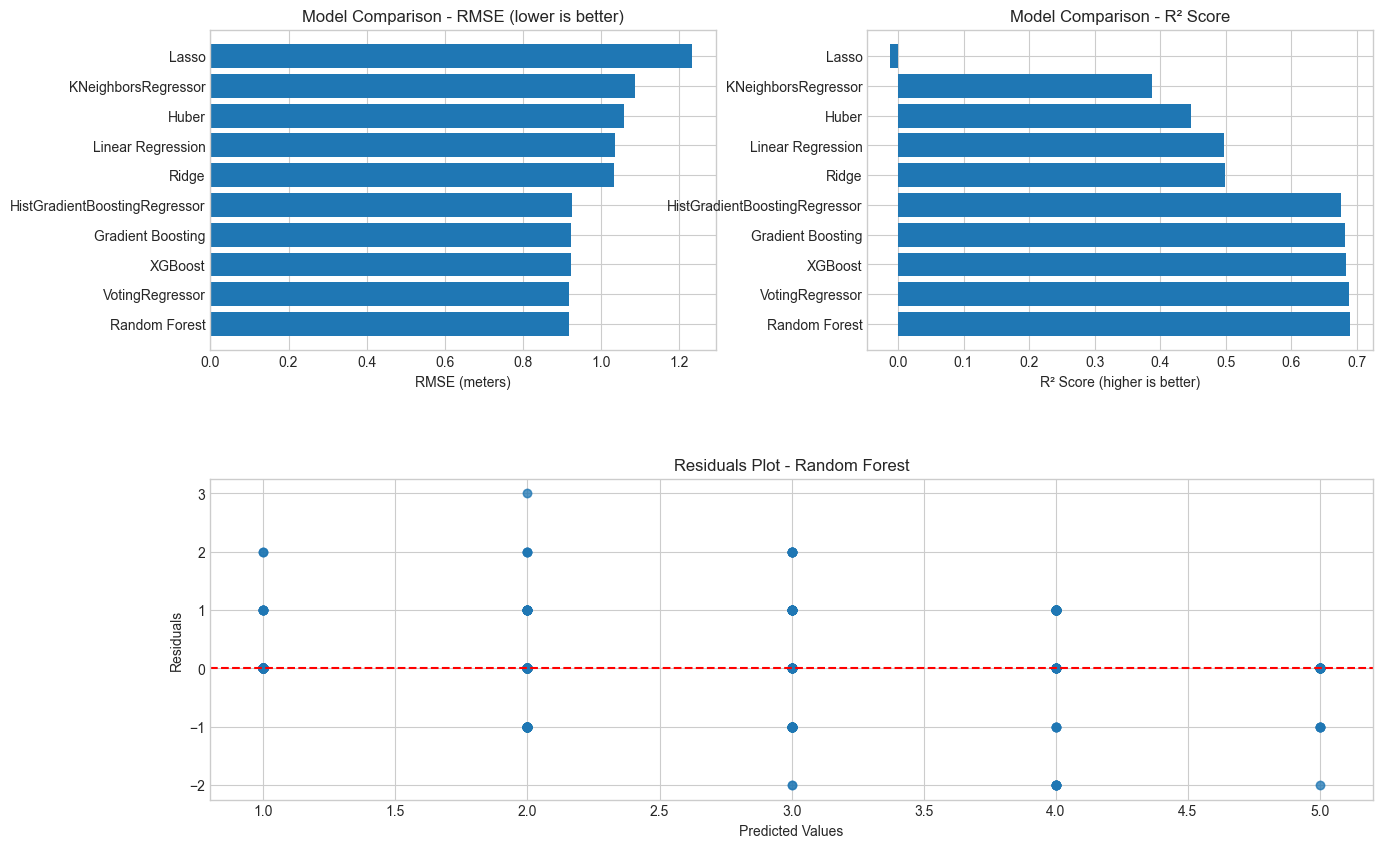


Summary of all models:
                                   RMSE        R²   CV RMSE  CV RMSE Std
Random Forest                  0.917237  0.689065  0.868430     0.047188
VotingRegressor                0.917800  0.688301  0.858162     0.031023
XGBoost                        0.921712  0.682954  0.860919     0.031117
Gradient Boosting              0.922820  0.681426  0.867670     0.036825
HistGradientBoostingRegressor  0.926669  0.676078  0.883626     0.029719
Ridge                          1.033890  0.498073  0.975550     0.107346
Linear Regression              1.034676  0.496546  0.982520     0.108425
Huber                          1.059662  0.446124  0.974498     0.121518
KNeighborsRegressor            1.086404  0.388062  1.210613     0.089386
Lasso                          1.231842 -0.011493  1.479355     0.133666
Visualizations for the best model:


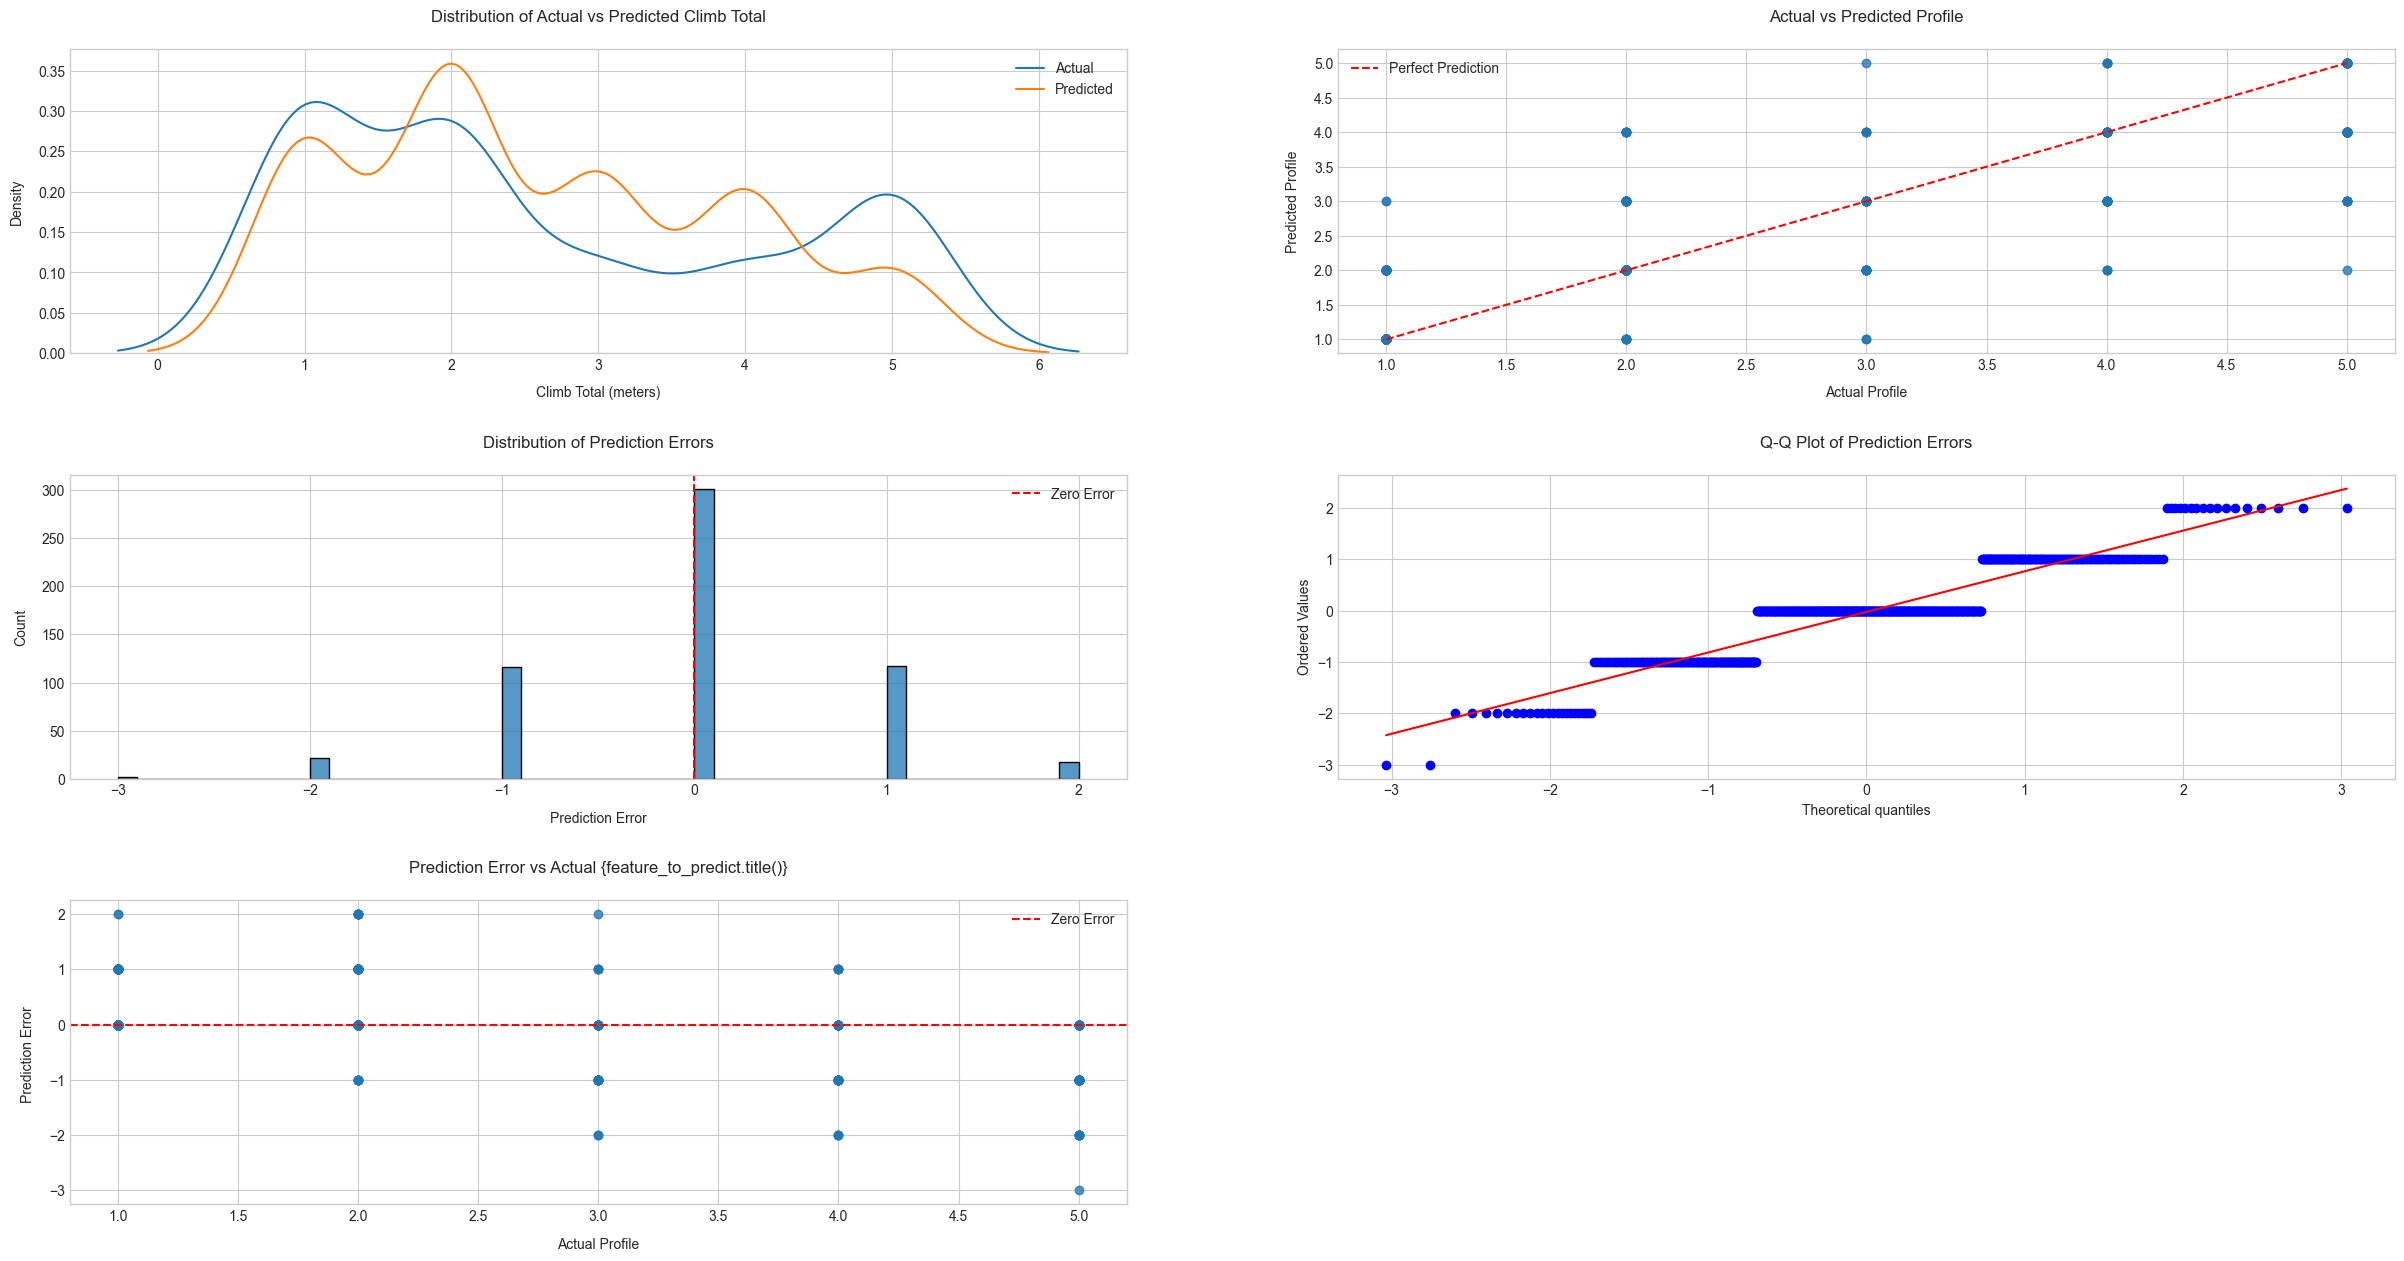

In [65]:
results_profile, summary_prof, profile_pred =  compare_regressors(DatasetRace_profile_grouped, "profile", features=pred_features_prof)

##### Conclusion on  `profile` `nan` values prediction 

In [66]:
profile_pred_v1 = profile_pred.apply(lambda x: round(x, 0))

temp_obj_profile = DatasetRace.loc[DatasetRace['profile'].isna(), '_url'].map(profile_pred_v1)

# Update the 'profile' column
DatasetRace.loc[temp_obj_profile.index, 'profile'] = temp_obj_profile

DatasetRace['profile'].isna().sum()

np.int64(0)

#### Predicting `uci_points` `nan` values

Now we will proceed to predict the `uci_points`. Since the best approach to predict the `nan` values was the regressors comparing one, we are showing only its results.

Warning: might take some minutes to run.

##### Dataset preparation

In [67]:
DatasetRace_uci_points = DatasetRace_profile.copy()

DatasetRace_uci_points['uci_points'] = DatasetRace['uci_points']

noraml_features_uci_points = normal_features_prof.copy()

FEATURES_UCI_POINTS = {**noraml_features_uci_points, **engineered_features}

pred_features_uci_points = {name: {'type': props['type']} for name, props in FEATURES_UCI_POINTS.items()}

agg_dict_uci_points = {name: props['agg'] for name, props in FEATURES_UCI_POINTS.items()}
agg_dict_uci_points['date'] = 'first'
agg_dict_uci_points['uci_points'] = 'mean'

DatasetRace_uci_points_groupd = DatasetRace_uci_points.groupby(["_url", "cyclist"]).agg(agg_dict_uci_points)


DatasetRace_uci_points_groupd.sample(frac=0.4).head(5)

length    points  \
_url                           cyclist                                    
giro-d-italia/2005/stage-7     aurelien-clerc        0.684870 -0.235118   
volta-a-catalunya/2016/stage-5 bart-de-clercq        0.316199 -0.235118   
giro-d-italia/2023/stage-16    thomas-champion       0.560947 -0.235118   
giro-d-italia/2008/stage-16    jose-humberto-rujano -2.383774  0.746269   
vuelta-a-espana/1995/stage-17  daniel-clavero        0.192276  0.419140   

                                                     startlist_quality  \
_url                           cyclist                                   
giro-d-italia/2005/stage-7     aurelien-clerc                -0.451045   
volta-a-catalunya/2016/stage-5 bart-de-clercq                -0.146271   
giro-d-italia/2023/stage-16    thomas-champion               -0.698018   
giro-d-italia/2008/stage-16    jose-humberto-rujano          -0.112115   
vuelta-a-espana/1995/stage-17  daniel-clavero                -0.571904   

                                                     is_tarmac  position  \
_url                           cyclist                                     
giro-d-italia/2005/stage-7     aurelien-clerc              1.0  0.740247   
volta-a-catalunya/2016/stage-5 bart-de-clercq              1.0 -0.418211   
giro-d-italia/2023/stage-16    thomas-champion             1.0 -0.025163   
giro-d-italia/2008/stage-16    jose-humberto-rujano        1.0 -1.431861   
vuelta-a-espana/1995/stage-17  daniel-clavero              1.0 -1.390488   

                                                     cyclist_age  climb_total  \
_url                           cyclist                                          
giro-d-italia/2005/stage-7     aurelien-clerc          -0.642865    -0.009131   
volta-a-catalunya/2016/stage-5 bart-de-clercq           0.394493    -0.042242   
giro-d-italia/2023/stage-16    thomas-champion         -1.161545     2.708343   
giro-d-italia/2008/stage-16    jose-humberto-rujano    -0.642865    -0.963211   
vuelta-a-espana/1995/stage-17  daniel-clavero          -0.383526     1.162871   

                                                     points_per_km  \
_url                           cyclist                               
giro-d-italia/2005/stage-7     aurelien-clerc            -0.103253   
volta-a-catalunya/2016/stage-5 bart-de-clercq            -0.103253   
giro-d-italia/2023/stage-16    thomas-champion           -0.103253   
giro-d-italia/2008/stage-16    jose-humberto-rujano       3.206904   
vuelta-a-espana/1995/stage-17  daniel-clavero             0.055605   

                                                     season_score  season  \
_url                           cyclist                                      
giro-d-italia/2005/stage-7     aurelien-clerc            0.804251       1   
volta-a-catalunya/2016/stage-5 bart-de-clercq            1.174601       1   
giro-d-italia/2023/stage-16    thomas-champion           0.639627       1   
giro-d-italia/2008/stage-16    jose-humberto-rujano      0.559129       1   
vuelta-a-espana/1995/stage-17  daniel-clavero           -1.719653       0   

                                                     team_presents  \
_url                           cyclist                               
giro-d-italia/2005/stage-7     aurelien-clerc             0.608709   
volta-a-catalunya/2016/stage-5 bart-de-clercq             0.608709   
giro-d-italia/2023/stage-16    thomas-champion            0.608709   
giro-d-italia/2008/stage-16    jose-humberto-rujano       0.608709   
vuelta-a-espana/1995/stage-17  daniel-clavero            -1.642821   

                                                     adjusted_delta  \
_url                           cyclist                                
giro-d-italia/2005/stage-7     aurelien-clerc              0.253504   
volta-a-catalunya/2016/stage-5 bart-de-clercq             -0.326043   
giro-d-italia/2023/stage-16    thomas-champion             0.774101   
giro-d-italia/2008/stage-16    j

##### Using `compare_regressors`


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


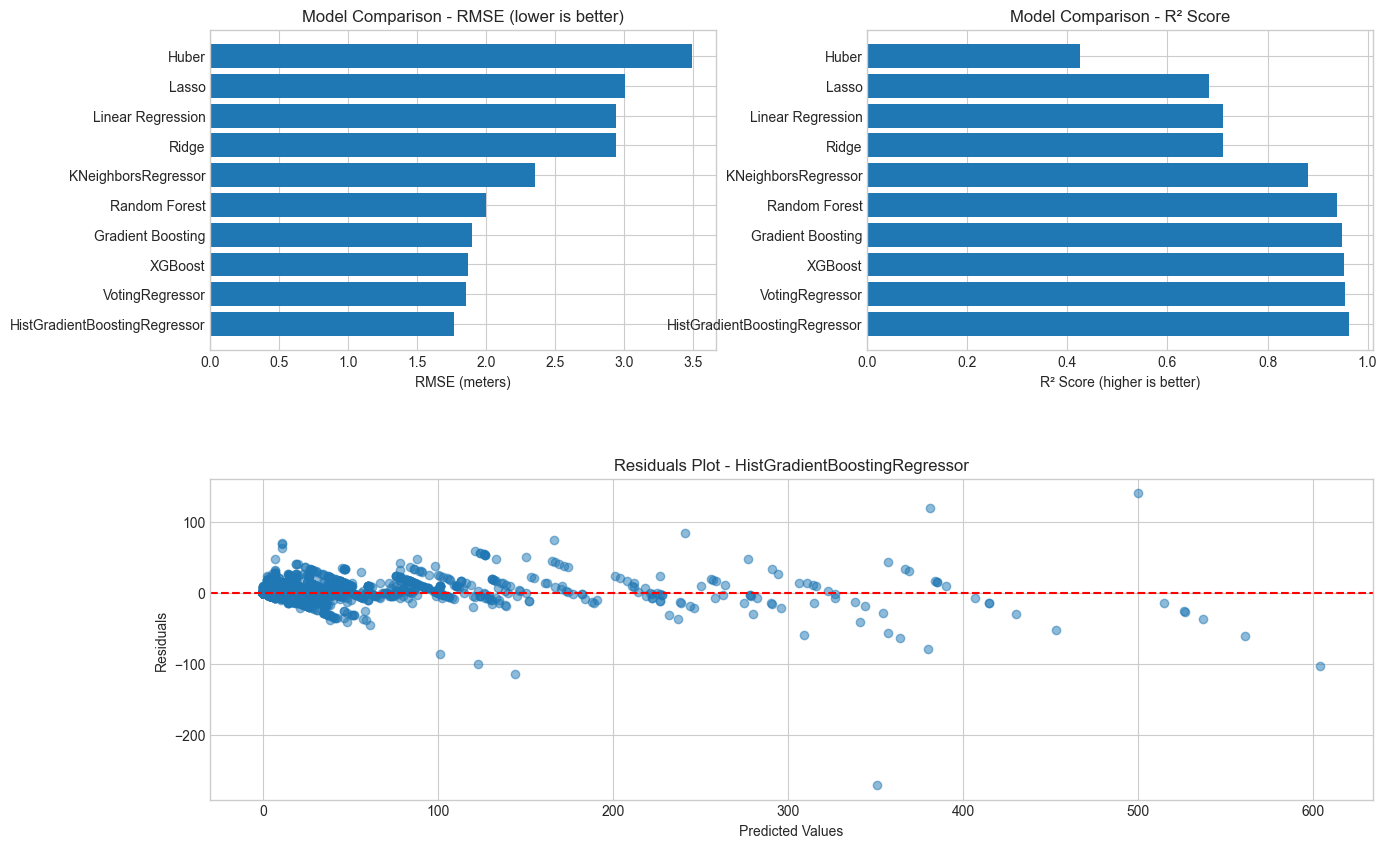


Summary of all models:
                                   RMSE        R²    CV RMSE  CV RMSE Std
HistGradientBoostingRegressor  1.763990  0.962521   6.903658     1.361306
VotingRegressor                1.852645  0.954399   6.727754     1.477069
XGBoost                        1.865179  0.953153   7.000329     1.544377
Gradient Boosting              1.899268  0.949633   6.918824     1.825369
Random Forest                  1.995826  0.938582   6.816444     1.182537
KNeighborsRegressor            2.357374  0.880459   8.504792     1.325099
Ridge                          2.939102  0.711158   9.920782     2.820678
Linear Regression              2.939107  0.711156   9.920840     2.820589
Lasso                          3.005902  0.683989  10.418399     4.331743
Huber                          3.490290  0.425555  13.401086     6.869639
Visualizations for the best model:


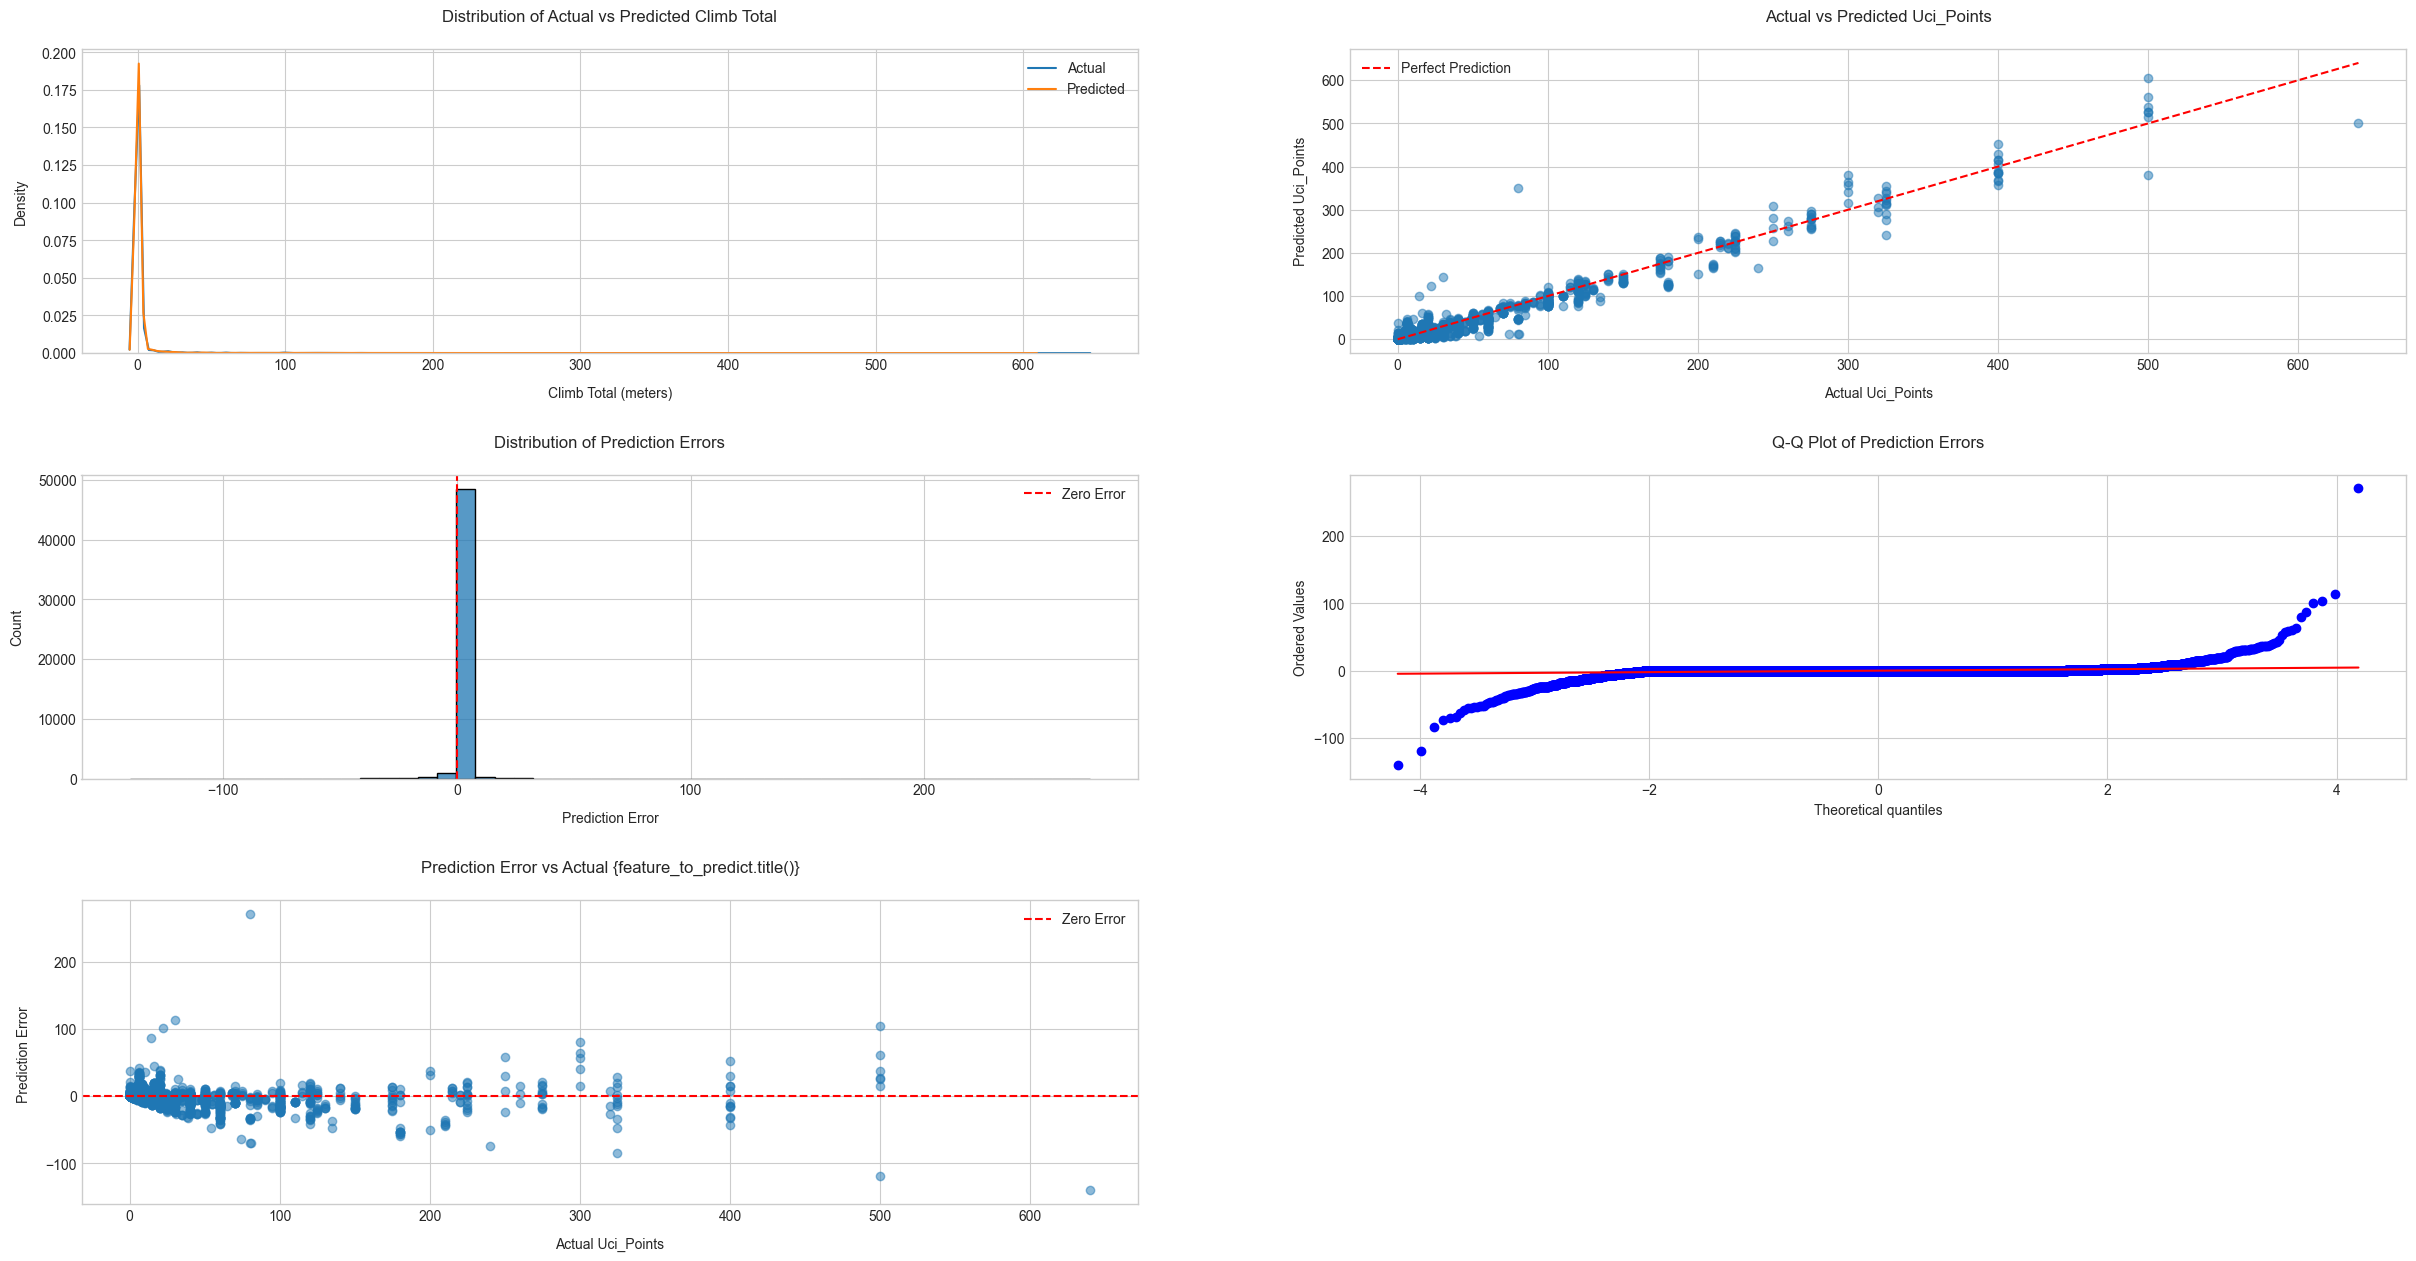

In [68]:
results_uci_points, summary_uci_points, uci_points_pred =  compare_regressors(DatasetRace_uci_points_groupd, "uci_points", features=pred_features_uci_points)

##### Conclusion on  `uci_points` `nan` values prediction 

In [69]:

uci_points_pred_v1 = uci_points_pred.apply(lambda x: round(x, 0))

temp_obj_uci_points = DatasetRace.loc[DatasetRace['uci_points'].isna(), ['_url', 'cyclist']].apply(lambda x: uci_points_pred_v1[x['_url'], x['cyclist']], axis=1)

# Update the 'uci_points' column
DatasetRace.loc[temp_obj_uci_points.index, 'uci_points'] = temp_obj_uci_points

print(f"Number of missing values in uci_points: {DatasetRace['uci_points'].isna().sum()}")



Number of missing values in uci_points: 0


### View final dataset cleaned

                   Total values  Missing values  Usable values
Elements                                                      
_url                     586939               0         586939
name                     586939               0         586939
points                   586939               0         586939
uci_points               586939               0         586939
length                   586939               0         586939
climb_total              586939               0         586939
profile                  586939               0         586939
startlist_quality        586939               0         586939
date                     586939               0         586939
position                 586939               0         586939
cyclist                  586939               0         586939
cyclist_age              586939               0         586939
is_tarmac                586939               0         586939
is_cobbled               586939               0        

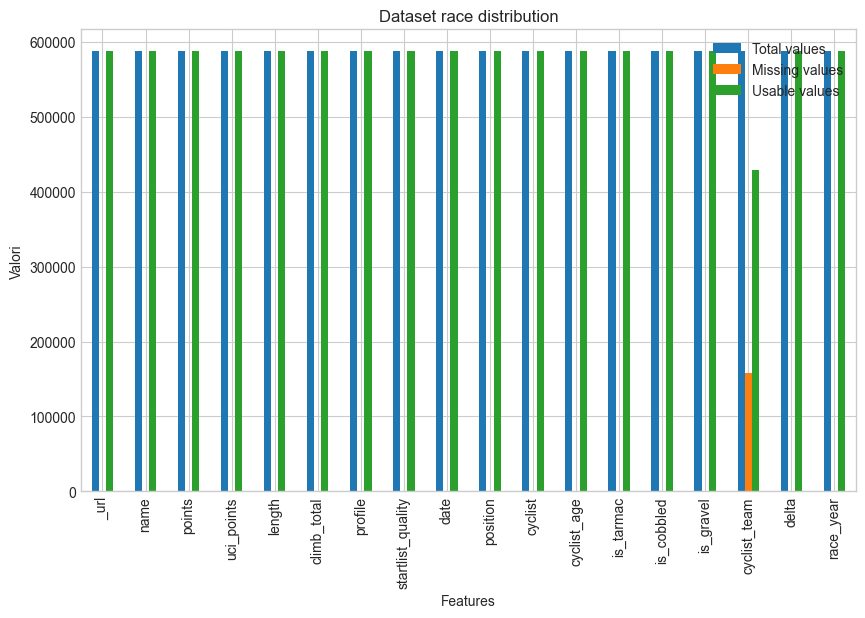

In [70]:
PlotMissingUsableData(DatasetRace, "race")

### Saving cleaned races dataset and cleaned cyclist dataset

In [71]:
from utils import move_to_tmp
# But before we need to remove cyclist that are not present in the races dataset

DatasetCyclists = DatasetCyclists[DatasetCyclists['_url'].isin(DatasetRace['cyclist'].unique())]
print(len(DatasetCyclists))
print(DatasetCyclists.duplicated().sum())

# !WARNING! This operation will overwrite the original files
# !WARNING! Uncomment the following lines to save the filled datasets

# Now we can save the dataset to a csv file


# move_to_tmp('dataset/races_filled.csv')
# DatasetRace.to_csv('dataset/races_filled.csv', index=False)
# move_to_tmp('dataset/cyclists_filled.csv')
# DatasetCyclists.to_csv('dataset/cyclists_filled.csv', index=False)

6082
0


## Feature engineering


Since we want to experiment with different clustering algorithms and different outliers detection algorithms, and for some of them dimensionality plays a big role, we decided to define new features from the original data to retain most of the uncut information while reducing the dimensionality. 

### Dataset preparation

In [41]:
# try:
DatasetRace = pd.read_csv("dataset/races_filled.csv")
DatasetCyclists = pd.read_csv("dataset/cyclists_filled.csv")
# except NameError:
#     DatasetRace = pd.read_csv("dataset/races_filled.csv")
#     DatasetCyclists = pd.read_csv("dataset/cyclists_filled.csv")

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             586939               0         586939
birth_year               586939               0         586939
weight                   586939               0         586939
height                   586939               0         586939
nationality              586939               0         586939
expected_url             586939               0         586939
name_race                586939               0         586939
points                   586939               0         586939
uci_points               586939               0         586939
length                   586939               0         586939
climb_total              586939               0         586939
profile                  586939               0         586939
startlist_quality        586939               0         586939
date                     586939               0        

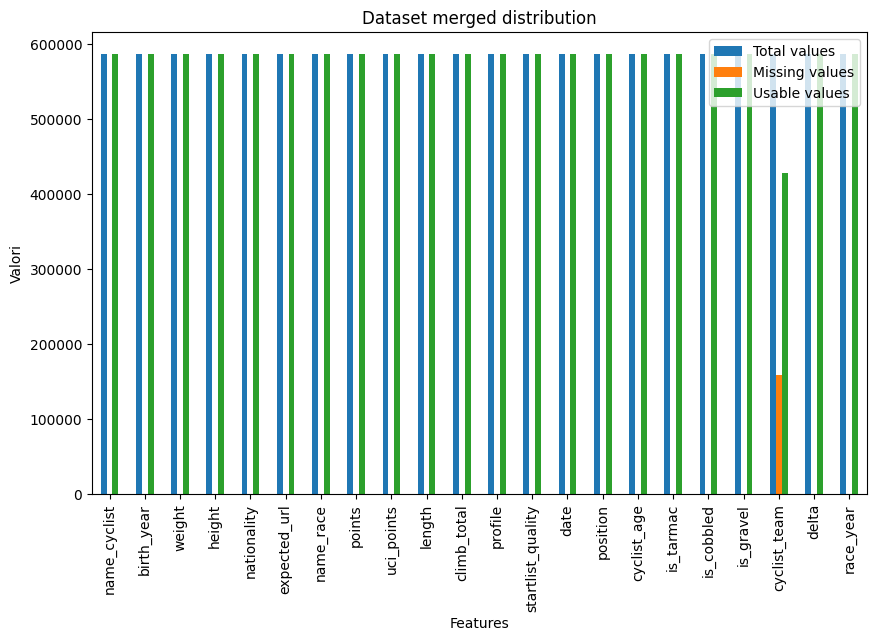

In [42]:
MergedDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergedDataset["name_x"]
del MergedDataset["name_y"]
del MergedDataset['cyclist']

MergedDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergedDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergedDataset, "merged")

### Feature `pca_race_points`

As we have seen in the Data Understanding section, there is an almost linear correlation between `points` and `uci_points`. Thus, it makes sense to apply the `PCA` algorithm to merge them into one dense vector.

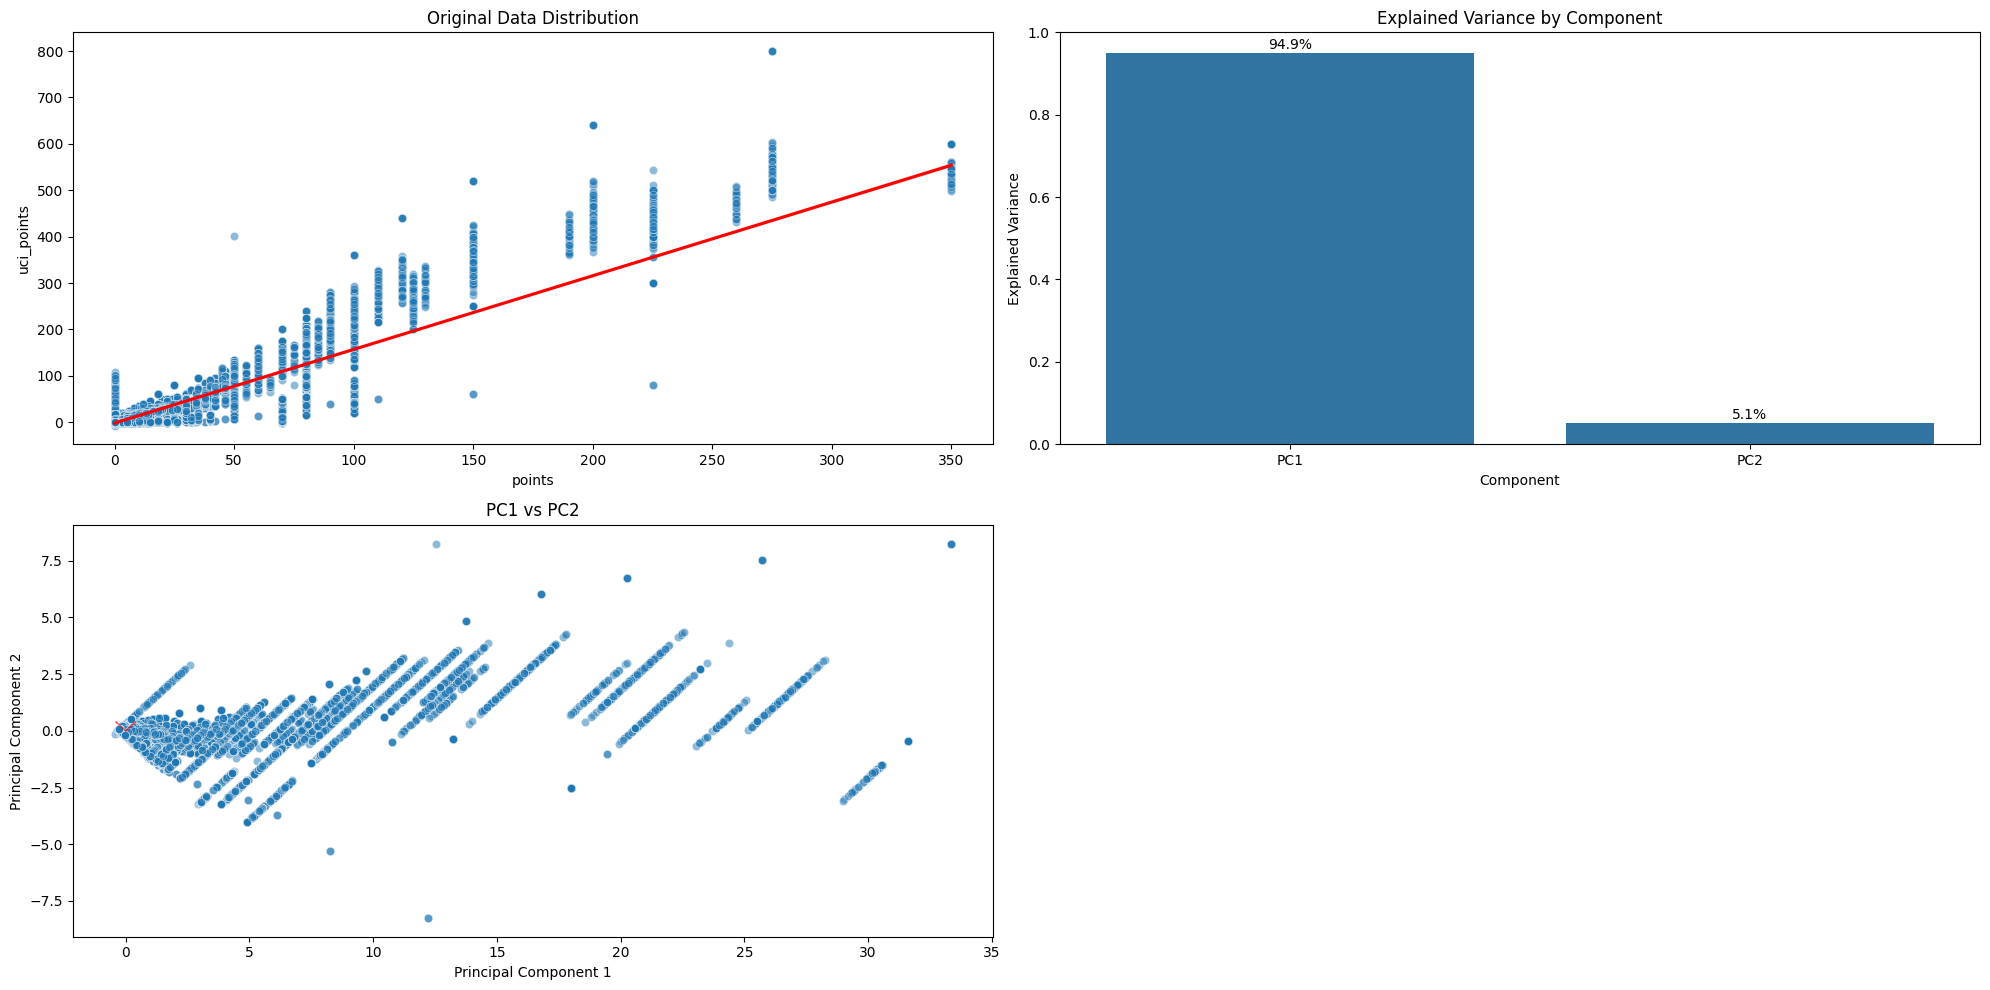


PCA Components Information:

Explained Variance Ratio:
PC1: 94.9% (Cumulative: 94.9%)
PC2: 5.1% (Cumulative: 100.0%)

Component Weights:

PC1:
  points: 0.707
  uci_points: 0.707

PC2:
  points: -0.707
  uci_points: 0.707

Transformed Data Statistics:
                PC1           PC2
count  5.869390e+05  5.869390e+05
mean  -1.200906e-17  2.990158e-17
std    1.377466e+00  3.202971e-01
min   -4.517315e-01 -8.253736e+00
25%   -2.687123e-01  6.379432e-02
50%   -2.687123e-01  6.379432e-02
75%   -2.687123e-01  6.379432e-02
max    3.337010e+01  8.261178e+00


In [7]:
# Importing our custom functions
from outliers_code.pca_reducer import combine_race_points


MergedDataset = combine_race_points(MergedDataset, add_to_df=False, plot_analysis=True)

Since the PC1 explains 94.9% of the variance between the two variables, we will use it as the common feature moving forward.

### Feature `physical_score`


In [8]:
MergedDataset['weight_height_ratio'] = MergedDataset['weight'] / (MergedDataset['height'])

MergedDataset['physical_score'] = (
    MergedDataset['weight_height_ratio'] * 0.6 +
    MergedDataset['cyclist_age'] * 0.4
)

### Feature `race_difficulty`


In [9]:
MergedDataset['race_difficulty'] = (
    MergedDataset['length'] * 0.325 +
    MergedDataset['climb_total'] * 0.525 +
    MergedDataset['is_tarmac'].astype(int) * 0.15
) / 100

### Feature `combined_score_per_km`

In [10]:
km = (MergedDataset['length'] * 0.001)
MergedDataset['points_per_km'] = MergedDataset['pca_race_points'] / km
MergedDataset['startlist_per_km'] = MergedDataset['startlist_quality'] / km
MergedDataset['combined_score_per_km'] = (0.6 * (MergedDataset['points_per_km']) + 
                                         0.4 * (MergedDataset['startlist_per_km']))

### Feature `consistency_score`

In [11]:
performance_features = ['pca_race_points', 'position', 'delta']

merged = MergedDataset.groupby('cyclist')
group_size = merged.size()
single_value_group = group_size[group_size == 1].index

std_dev = merged[performance_features].transform('std')
mean_std_dev = std_dev.mean(axis=1)

mean_std_dev[MergedDataset['cyclist'].isin(single_value_group)] = 0

MergedDataset['consistency_score'] = mean_std_dev

### Feature `race_performance_score`

In [ ]:
race_max_pos = MergedDataset.groupby('name_race')['position'].max().reset_index()
race_max_pos = race_max_pos.rename(columns={'position': 'max_position'})
# Invert position so higher is better
MergedDataset['position_modified'] = MergedDataset.parallel_apply(lambda x: race_max_pos[race_max_pos['name_race'] == x['name_race']]['max_position'].values[0] - x['position'], axis=1)

# 1. Combine performance metrics into a single 'race_performance_score':
MergedDataset['race_performance_score'] = (
    (MergedDataset['position_modified'] * 0.7) +  
    (MergedDataset['points_per_km'] * 0.3)
)


## Outliers Detection

In [5]:
# Package required: torch, thus don't run if not installed
# Python lower than 3.13 is required (and probably lower than something, but I don't know what)

packages = [
    'thinc',
    'srsly',
    'fastai'
]

for package in packages:
    check_and_install(package)



### Adding the features

#### Firstly, we need to encode the categorical data

Is being encoded by the `TabularPandas` class from the `fastai` package.


In [6]:
MergedDataset = pd.read_csv("dataset/engineered_df.csv")

In [7]:
from outliers_code.utils import encode_tabular_data

cont_features = ['pca_race_points', 'physical_score', 'race_difficulty', 'combined_score_per_km', 'consistency_score', 'race_performance_score']
cat_features = ['nationality']

df_encoded = encode_tabular_data(MergedDataset, cat_features, cont_features)

In [8]:
df_encoded.sample(5)

nationality  pca_race_points  physical_score  race_difficulty  \
76946            35        -0.195077       -0.643135        -1.646770   
7160              8        -0.195077        1.450873         0.269322   
497570           61        -0.195077        0.135738         0.652754   
97203            25        -0.027149       -1.146865         1.949638   
5089              3        -0.195077       -1.435238         0.475658   

        combined_score_per_km  consistency_score  race_performance_score  
76946                0.353478          -0.130073                1.506412  
7160                -0.264194          -0.033817               -1.288927  
497570              -0.189028          -0.172091                0.305468  
97203               -0.287083          -0.116729               -0.522778  
5089                -0.269715          -0.103446                1.195842

### Local Outlier Factor (LOF) Algorithm

The first algorithm to detect races row outliers is LOF, which is great for datasets where the data density varies. It detects outliers by computing, for each point, the distance to its k-nearest neighbors. Afterwards, LOF computes a local reachability density (LRD). The LRD measures how densely packed its neighborhood is, based on the distance to its k-nearest neighbors. A point with sparse surroundings will have a high LOF score, and a point with dense surroundings will have a low LOF score. Thus, to identify outliers, it is sufficient to find those points that have a high LOF score.

Processing params: LOFParams(n_neighbors=48, contamination=np.float64(0.05), leaf_size=29, p=np.int64(1), metric=np.str_('euclidean'))
Processing params: LOFParams(n_neighbors=26, contamination=np.float64(0.1), leaf_size=46, p=np.int64(2), metric=np.str_('manhattan'))
Processing params: LOFParams(n_neighbors=21, contamination=np.float64(0.01), leaf_size=34, p=np.int64(1), metric=np.str_('euclidean'))
Processing params: LOFParams(n_neighbors=37, contamination=np.float64(0.2), leaf_size=22, p=np.int64(2), metric=np.str_('euclidean'))
Processing params: LOFParams(n_neighbors=42, contamination=np.float64(0.2), leaf_size=33, p=np.int64(2), metric=np.str_('minkowski'))
Processing params: LOFParams(n_neighbors=29, contamination=np.float64(0.05), leaf_size=26, p=np.int64(1), metric=np.str_('minkowski'))
Processing params: LOFParams(n_neighbors=42, contamination=np.float64(0.1), leaf_size=40, p=np.int64(2), metric=np.str_('manhattan'))
Processing params: LOFParams(n_neighbors=39, contamination=

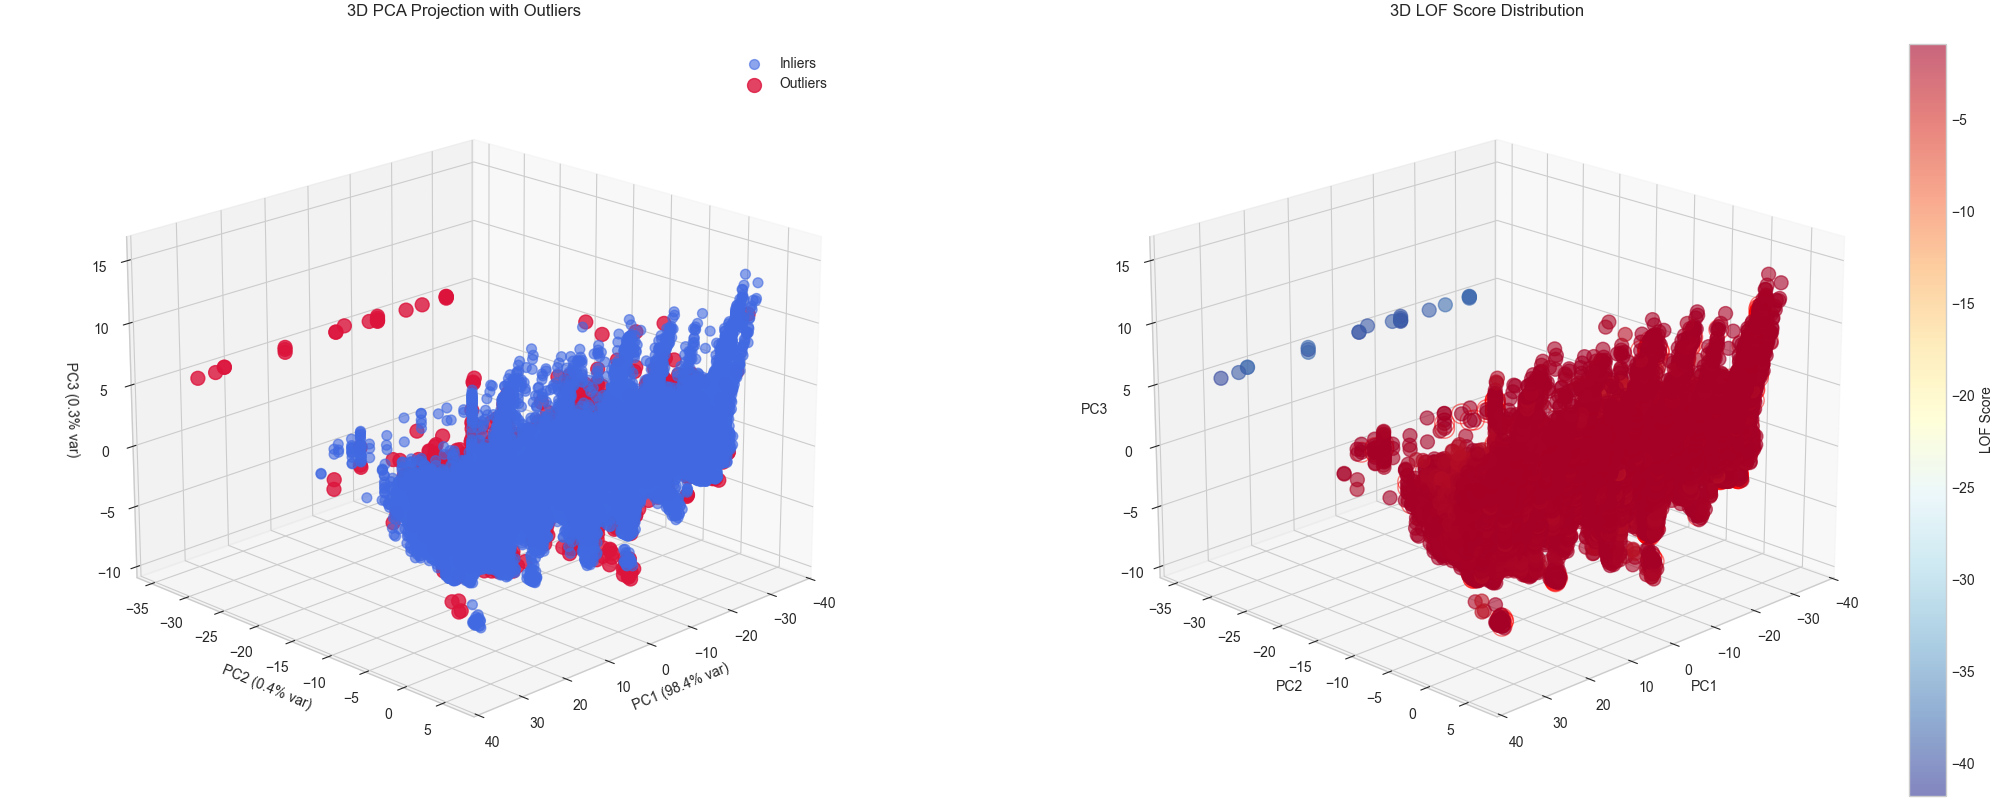

In [10]:
%matplotlib widget

# import local class
from outliers_code.outliers_detection_lof import LOFOutliersDetector

detector = LOFOutliersDetector()

# outliers_lof = detector.fit_predict_with_search(df_encoded)
outliers_lof = detector.fit_predict_with_search(df_encoded)

Processing params: IForestParams(n_estimators=259, max_samples=np.float64(0.3451087785902911), max_features=np.float64(0.8428679899770655), contamination=np.float64(0.05714324545026054), bootstrap=np.True_)Processing params: IForestParams(n_estimators=223, max_samples=np.float64(0.14234164904793928), max_features=np.float64(0.643264568215513), contamination=np.float64(0.054382654641930345), bootstrap=np.True_)
Processing params: IForestParams(n_estimators=293, max_samples=np.float64(0.3033337945378659), max_features=np.float64(0.86932743158279), contamination=np.float64(0.08073926393846742), bootstrap=np.True_)

Processing params: IForestParams(n_estimators=266, max_samples=np.float64(0.17520428048833914), max_features=np.float64(0.1919871559299957), contamination=np.float64(0.07860265317174697), bootstrap=np.True_)
Processing params: IForestParams(n_estimators=130, max_samples=np.float64(0.49143574203813056), max_features=np.float64(0.25446345153624894), contamination=np.float64(0.042

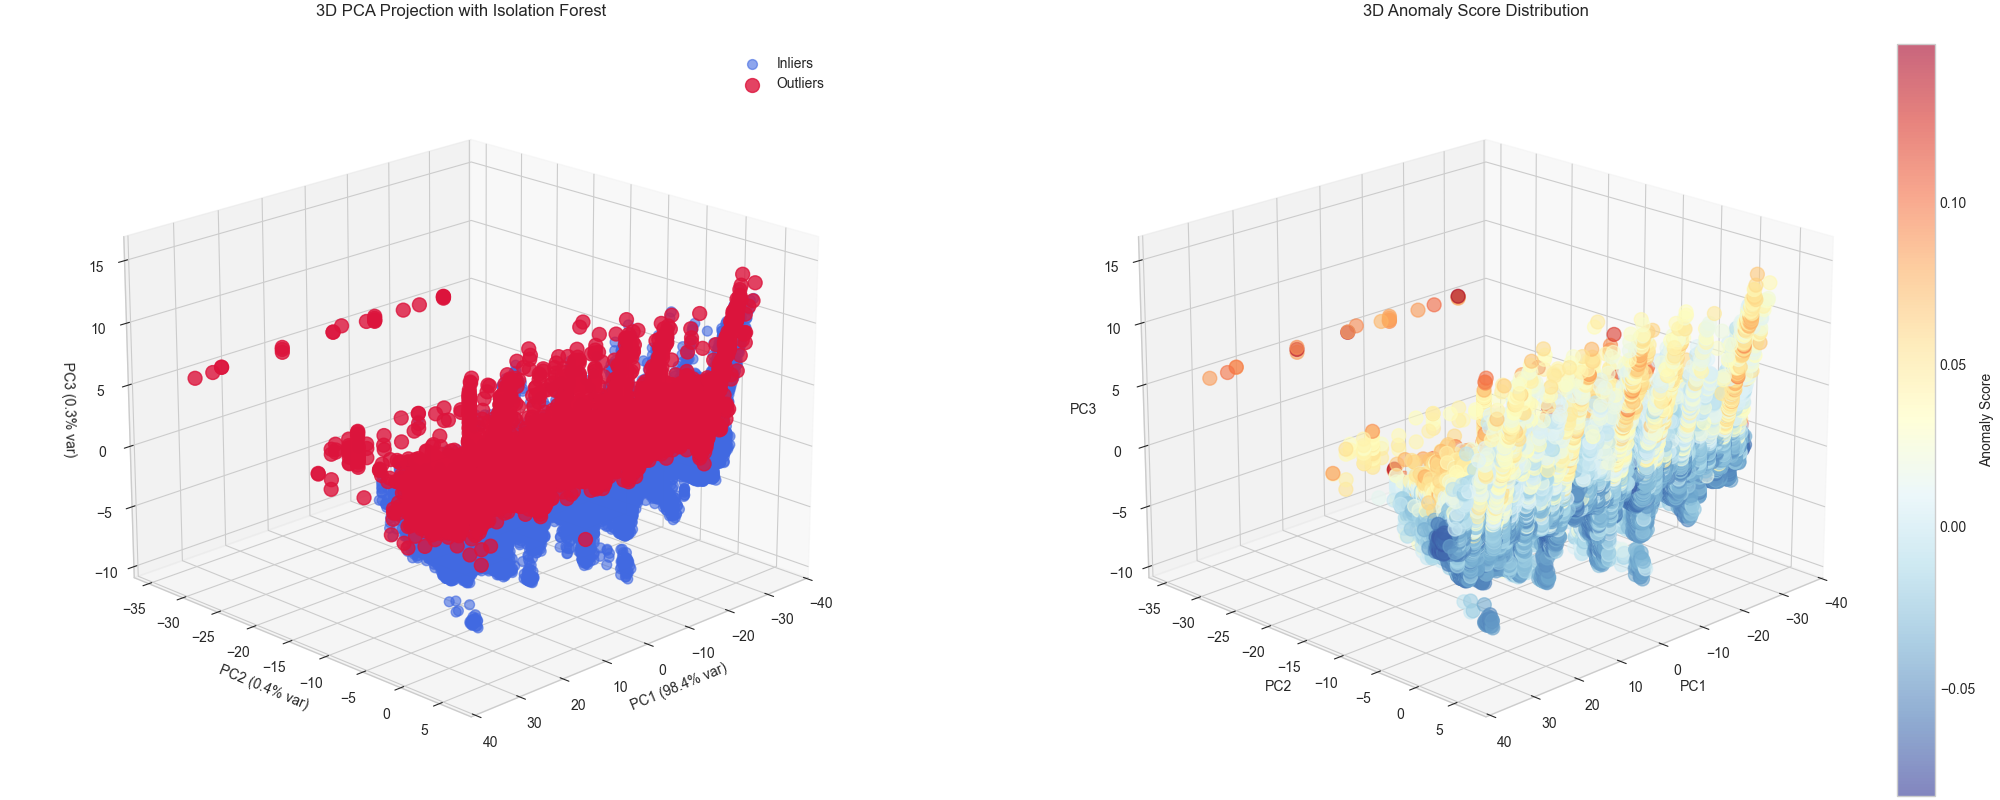

In [11]:
%matplotlib widget
from outliers_code.outliers_detection_iso_for import IsolationForestDetector

detector = IsolationForestDetector()

results =  detector.fit_predict_with_search(df_encoded)
outliers_iso_for = results[0]

In [ ]:
from outliers_code.outliers_detection_oc_svm import OneClassSVMDetector

detector = OneClassSVMDetector( nu=0.07, kernel='rbf', gamma='scale')

# detector.fit_predict_with_search(df_encoded, n_iter=20, cv=5, verbose=1)

# outliers_oc_svm = detector.fit_predict(df_encoded)

#### **OneClassSVM** on GPU

**Note:** Run the code below with caution, especially in a virtual environment. The code will try to install all the CUDA packages necessary to run SVM on the GPU to speed up things.

One-Class SVM Will Run ON GPU ID: 0


Parameter Search:   0%|          | 0/25 [00:00<?, ?it/s]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.005810901922325413, gamma=0.000558361036545902)


Parameter Search:   4%|▍         | 1/25 [00:02<00:48,  2.03s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.008959889590750801, gamma=0.0021508497682879188)


Parameter Search:   8%|▊         | 2/25 [00:04<00:54,  2.37s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.005752506327317738, gamma=0.00014958554990881045)


Parameter Search:  12%|█▏        | 3/25 [00:06<00:46,  2.13s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.0073080578147475764, gamma=0.003782521907778681)


Parameter Search:  16%|█▌        | 4/25 [00:08<00:45,  2.19s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.00903016907071267, gamma=0.024147427203613025)


Parameter Search:  20%|██        | 5/25 [00:11<00:47,  2.36s/it]

Processing params: SVMParams(kernel=np.str_('sigmoid'), nu=0.014798476331378783, gamma=0.0053078325313637206)


Parameter Search:  24%|██▍       | 6/25 [00:15<00:58,  3.09s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.006895014833261192, gamma=0.7627900884414892)


Parameter Search:  28%|██▊       | 7/25 [00:22<01:13,  4.10s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.013261801171375771, gamma=0.00238980649277467)


Parameter Search:  32%|███▏      | 8/25 [00:25<01:06,  3.93s/it]

Processing params: SVMParams(kernel=np.str_('sigmoid'), nu=0.014663242428079187, gamma=0.9669301065250641)


Parameter Search:  36%|███▌      | 9/25 [02:01<08:41, 32.62s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.014845295587121426, gamma=0.010986497774669672)


Parameter Search:  40%|████      | 10/25 [02:05<05:56, 23.75s/it]

Processing params: SVMParams(kernel=np.str_('sigmoid'), nu=0.005836627354482037, gamma=0.026983359814865018)


Parameter Search:  44%|████▍     | 11/25 [02:07<03:59, 17.11s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.007682921702033081, gamma=0.032980544305759855)


Parameter Search:  48%|████▊     | 12/25 [02:09<02:44, 12.65s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.014318088609024681, gamma=1.4257045958991481e-05)


Parameter Search:  52%|█████▏    | 13/25 [02:13<01:58,  9.91s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.011280293230080372, gamma=0.806958218784233)


Parameter Search:  56%|█████▌    | 14/25 [02:20<01:39,  9.00s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.009766013296242576, gamma=0.006030530574663096)


Parameter Search:  60%|██████    | 15/25 [02:23<01:11,  7.13s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.01365907494320684, gamma=0.025989358963096405)


Parameter Search:  64%|██████▍   | 16/25 [02:26<00:54,  6.09s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.0139166857451654, gamma=0.0003458253119015551)


Parameter Search:  68%|██████▊   | 17/25 [02:30<00:42,  5.33s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.005233144584821015, gamma=0.3253442849777249)


Parameter Search:  72%|███████▏  | 18/25 [02:32<00:30,  4.42s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.013783538404790838, gamma=7.274360039628768e-05)


Parameter Search:  76%|███████▌  | 19/25 [02:36<00:25,  4.17s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.009477375603603743, gamma=7.26046441690474e-05)


Parameter Search:  80%|████████  | 20/25 [02:38<00:18,  3.71s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.013162623017121833, gamma=0.0008143745646446145)


Parameter Search:  84%|████████▍ | 21/25 [02:42<00:14,  3.65s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.012618444735958474, gamma=0.4149347243559777)


Parameter Search:  88%|████████▊ | 22/25 [02:46<00:11,  3.73s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.007190629487782085, gamma=0.025388249209033813)


Parameter Search:  92%|█████████▏| 23/25 [02:48<00:06,  3.31s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.009795995556278423, gamma=0.045238704070239694)


Parameter Search:  96%|█████████▌| 24/25 [02:51<00:03,  3.21s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.012421120001482617, gamma=0.09951348536519294)


Parameter Search: 100%|██████████| 25/25 [02:54<00:00,  7.00s/it]



GPU One-Class SVM Detection Results

Best Parameters:
  Kernel:     rbf
  Nu:         0.006
  Gamma:      0.0006
  Score:      1.0000

Detection Statistics:
  Total points:      586,939
  Outliers found:    3,409 (0.6%)
  Inliers retained:  583,530 (99.4%)

Anomaly Score Distribution:
  Min score:     -2989.07
  Max score:     56.01
  Mean score:    -1502.30
  Median score:  -1511.84

Score Percentiles:
  25th: -2604.85
  75th: -887.65
  90th: -85.80
  95th: -59.64
  99th: 0.59

Visualization Controls:
  - Use mouse to rotate 3D plots
  - Scroll to zoom in/out
  - Right-click and drag to pan



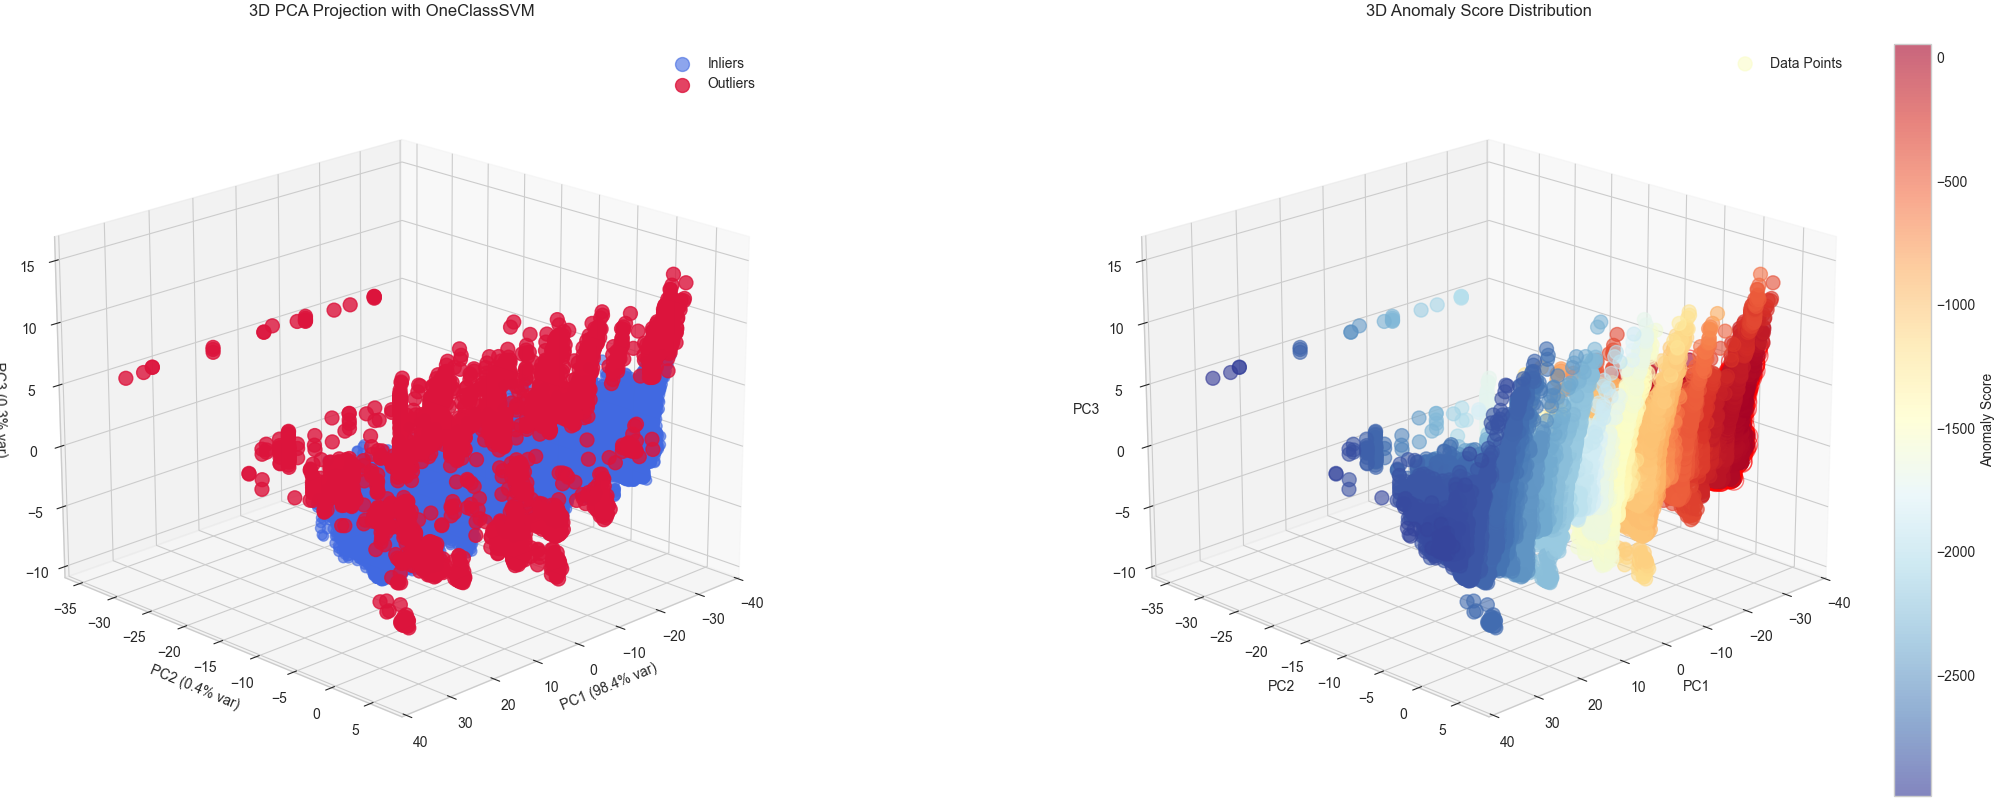

Variance explained by 3 PCs: 99.1%

Interactive Controls:
- Use arrow keys to rotate and tilt the plots
- Close the plot window to exit


In [9]:
%matplotlib widget

# Warning: installing gpu libraries
# 
# git clone https://github.com/Xtra-Computing/thundersvm.git 
# cd thundersvm
# mkdir build
# cd build
# cmake .. -DUSE_CUDA=ON -DUSE_DOUBLE=ON 
# make -j4
# cd ../python
# pip install . (ensure you are in rapids-24.10 environment)


from outliers_code.outliers_detection_oc_svm_gpu import GPUOneClassSVMDetector

# detector = GPUOneClassSVMDetector(nu=0.07, kernel='rbf', gamma='scale')
detector = GPUOneClassSVMDetector()

results = detector.fit_predict_with_search(df_encoded, n_iter=25)
outliers_oc_svm_gpu = results[0]


In [ ]:
MergedDataset.drop(columns=['race_year', 'weight_height_ratio', 'points_per_km', 'startlist_per_km', 'position_modified',], inplace=True)
MergedDataset.drop(columns=cont_features)

outliers_lof_df = MergedDataset.loc[outliers_lof.index]
outliers_iso_for_df = MergedDataset.loc[outliers_iso_for.index]
outliers_oc_svm_df = MergedDataset.loc[outliers_oc_svm_gpu.index]

outliers_lof_df.to_csv("dataset/outliers_lof.csv", index=False)
outliers_iso_for_df.to_csv("dataset/outliers_iso_for.csv", index=False)
outliers_oc_svm_df.to_csv("dataset/outliers_oc_svm.csv", index=False)

### Review about distribution data

In [ ]:
PlotMissingUsableData(MergedDataset, "Merge dataset")

In [ ]:
PlotDistributionFeatures(MergedDataset,
                         ['birth_year', 'weight', 'height', 'points', 'uci_points', 'length', 'climb_total', 'profile',
                          'startlist_quality', 'date', 'position', 'cyclist', 'cyclist_age', 'delta'])

## Review data understanding

**NOTA**:

Cosa mostrare:

- Grafici delle features distributions (per ognuno degl' entrambi dataset)
- Grafici delle correlazioni (di tutto insieme)

Si eliminano gl' outlier identificati

- Grafici delle features distributions (per ognuno degl' entrambi dataset)
- Grafici delle correlazioni (di tutto insieme)

Scrivere alla fine delle considerazioni (il necessario, le più evidenti, perchè il completo va per il report)

# **Clustering**

## K-means clustering

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Dataset = pd.read_csv("dataset/engineered_df.csv")

# Supponiamo che 'Dataset' contenga i dati originali e 'Features' sia già definito come elenco delle colonne di interesse
Features = ['pca_race_points', 'physical_score', 'race_difficulty', 'combined_score_per_km',
            'consistency_score', 'race_performance_score']

def ClusterKMeans(n):

    # Esegui KMeans clustering
    kmeans = KMeans(n_clusters=n, random_state=40)
    Dataset['kmeans_cluster'] = kmeans.fit_predict(Dataset[Features])

    for centroid in [i[1] for i in Dataset.groupby("kmeans_cluster")]:
        
        print(f"Cluster: {list(set(centroid['kmeans_cluster']))[0]}")
        print(centroid[Features].describe())
        print("-"*100)

    # Usa PCA per ridurre a 2 dimensioni per la visualizzazione
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(Dataset[Features])

    # Aggiungi le componenti PCA al Dataset per la visualizzazione
    Dataset['PCA1'] = pca_components[:, 0]
    Dataset['PCA2'] = pca_components[:, 1]

    # Visualizza il clustering in un grafico a dispersione
    plt.figure(figsize=(10, 6))
    for cluster in Dataset['kmeans_cluster'].unique():
        subset = Dataset[Dataset['kmeans_cluster'] == cluster]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('KMeans Clustering (Visualizzato con PCA)')
    plt.legend()
    plt.show()
    
    del Dataset['kmeans_cluster']
    

for i in range(2, 10):
    ClusterKMeans(i)


## DBSCAN clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Dict, Any
import seaborn
import pandas
import copy
from sklearn.neighbors import NearestNeighbors
from datasets import load_dataset
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler

import pandas as pd

MergedDataset = pd.read_csv("dataset/engineered_df.txt")

clustering_features = MergedDataset[[
    'physical_score', 'race_difficulty', 
    'combined_score_per_km', 'race_performance_score'
]].iloc[0:10000]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(clustering_features)
data_scaled = scaler.transform(clustering_features)

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import itertools

eps_values = np.arange(0.2, 2.5, 0.3)
min_samples_values = [50, 100, 150, 200]
metrics = ['euclidean', 'manhattan', 'cosine', 'chebyshev']

best_score = -1
best_params = {}

for eps, min_samples, metric in itertools.product(eps_values, min_samples_values, metrics):
    try:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        labels = dbscan.fit_predict(data_scaled)

        # Verifica se ci sono almeno 2 cluster
        if len(set(labels)) > 1:
            score = silhouette_score(data_scaled, labels)

            # Aggiorna i migliori parametri se il punteggio è migliorato
            if score > best_score:
                best_score = score
                best_params = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'metric': metric,
                    'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
                }
    except Exception as e:
        print(f"Errore con eps={eps}, min_samples={min_samples}, metric={metric}: {e}")

print(f"\nMiglior combinazione trovata:")
print(f"eps: {best_params['eps']}")
print(f"min_samples: {best_params['min_samples']}")
print(f"metric: {best_params['metric']}")
print(f"Numero di cluster: {best_params['n_clusters']}")
print(f"Silhouette Score: {best_score:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/engineered_df.txt'

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Parametri
k = 50  # Numero minimo di punti per formare un cluster (MinPts)
metric = 'chebyshev'  # Cambia la metrica qui (es. 'euclidean', 'manhattan', 'chebyshev', 'cosine')

# Calcolo della distanza del k-esimo vicino utilizzando la metrica scelta
nearest_neighbors = NearestNeighbors(n_neighbors=k, metric=metric)
nearest_neighbors.fit(data_scaled)
distances, indices = nearest_neighbors.kneighbors(data_scaled)

# Ordinamento delle distanze del k-esimo vicino
kth_distances = np.sort(distances[:, k-1])

# Plot della curva per individuare il valore di 'eps'
plt.figure(figsize=(10, 5))
plt.plot(kth_distances)
plt.xlabel("Punti ordinati secondo la distanza al k-esimo vicino")
plt.ylabel(f"{k}-esimo Vicino Distanza")
plt.title(f"Selezione del parametro eps per DBSCAN con MinPts = {k} e metrica = {metric}")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

eps_value = 1.7  # valore scelto in base al grafico
dbscan = DBSCAN(eps=eps_value, min_samples=k)
dbscan.fit(data_scaled)


In [ ]:
# Controlla la distribuzione dei cluster
labels =dbscan.labels_
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("Numero di punti per ciascun cluster:", cluster_counts)

In [ ]:
import seaborn
seaborn.scatterplot(data=clustering_features, x="physical_score", y="race_difficulty", hue=dbscan.labels_, legend='full')

In [ ]:
print('Silhouette %s' % silhouette_score(data_scaled, dbscan.labels_))

## Hierarchical clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# metodo di linkage predefinito: 'ward'
linkage_methods = ['ward', 'complete', 'average', 'single']
Z = linkage(data_scaled)

for t in range(2, 15): 
    clusters = fcluster(Z, t=t, criterion='maxclust')
    score = silhouette_score(data_scaled, clusters)
    print(f"Silhouette score per t={t}: {score}")

for method in linkage_methods:

    Z = linkage(data_scaled, method=method)

    plt.figure(figsize=(15, 7))
    plt.title(f"Dendrogramma per Agglomerative Clustering - Metodo: {method.capitalize()}")
    plt.xlabel("Punti di dati")
    plt.ylabel("Distanza")
    dendrogram(Z, truncate_mode='level', p=5)  # Puoi cambiare p per vedere più dettagli
    plt.show()

    t = 4  # numero di cluster
    clusters = fcluster(Z, t=t, criterion='maxclust')

    # Verifica il numero di punti per ciascun cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    print(f"Numero di punti per ciascun cluster con metodo '{method}':", cluster_counts)

Il metodo ward sembra il più bilanciato tra quelli provati, riuscendo a identificare 5 cluster con distribuzione accettabile dei punti.
Il metodo complete e average tendono a formare un cluster dominante, ma differiscono nella suddivisione degli outliers.
Il metodo single è chiaramente meno adatto, dato che forma un unico grande cluster e considera i pochi punti rimanenti come outliers.

In [ ]:
Z = linkage(data_scaled, method='ward')

plt.figure(figsize=(15, 7))
plt.title(f"Dendrogramma per Agglomerative Clustering - Metodo: {method.capitalize()}")
plt.xlabel("Punti di dati")
plt.ylabel("Distanza")
dendrogram(Z, truncate_mode='level', p=5)  # Puoi cambiare p per vedere più dettagli
plt.show()
t = 4  # numero di cluster
clusters = fcluster(Z, t=t, criterion='maxclust')

# Verifica il numero di punti per ciascun cluster
unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(f"Numero di punti per ciascun cluster con metodo 'ward':", cluster_counts)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Inizializza il modello, metric='euclidean' per default
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_cluster.fit_predict(data_scaled)
agg_cluster.labels_

In [ ]:
seaborn.scatterplot(data=clustering_features, x="physical_score", y="race_difficulty", hue=agg_cluster.labels_, legend='full', palette=seaborn.color_palette(n_colors=len(np.unique(agg_cluster.labels_))))